# Clustering the Beaded Helix Transtion from R- to L-Helix

## Import Libraries and Define CV Subroutines

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyemma
from shapeGMM import gmm_shapes
import MDAnalysis as md

In [5]:
def weighted_cross_validate_cluster_scan(traj_data, n_train_frames, cluster_array = np.arange(2,9,1).astype(int), n_partitions=10, n_attempts = 5, weighted_train_filename = "weighted_train.dat", weighted_predict_filename = "weighted_predict.dat"):
    # meta data from input array
    n_frames = traj_data.shape[0]
    # set parameters
    n_predict_frames = n_frames - n_train_frames
    print("Number of frames to train each model:", n_train_frames)
    print("Number of frames to predict each model:", n_predict_frames)
    sys.stdout.flush()
    # open data files
    weighted_train_log_lik = np.empty((cluster_array.size,n_partitions),dtype=np.float64)
    weighted_predict_log_lik = np.empty((cluster_array.size,n_partitions),dtype=np.float64)
    for partition in range(n_partitions):
        # shuffle trajectory data
        np.random.shuffle(traj_data)
        # create training and predict data
        train_data = traj_data[:n_train_frames]
        predict_data = traj_data[n_train_frames:]
        for cluster_index, cluster_size in enumerate(cluster_array):
            w_log_lik = []
            w_objs = []
            for attempt in range(n_attempts):
                wsgmm = gmm_shapes.ShapeGMM(cluster_size,kabsch_thresh=1e-1,init_cluster_method='random',init_iter=5, verbose=True)
                wsgmm.fit_weighted(train_data)
                w_log_lik.append(wsgmm.log_likelihood)
                w_objs.append(wsgmm)
            # determine maximum
            w_arg = np.argmax(w_log_lik)
            # save training log likes
            weighted_train_log_lik[cluster_index,partition] = w_log_lik[w_arg]
            # save prediction log likes
            weighted_predict_log_lik[cluster_index,partition] = w_objs[w_arg].predict_weighted(predict_data)[2]


    # write to data files
    weighted_train_file = open(weighted_train_filename,"w")
    weighted_predict_file = open(weighted_predict_filename,"w")
    # initialize counter
    count = 0
    for cluster_index, cluster_size in enumerate(cluster_array):
        weighted_train_file.write("%d" % (cluster_size))
        weighted_predict_file.write("%d" % (cluster_size))
        for partition in range(n_partitions):
            # write to training files
            weighted_train_file.write("%32.8f" % (weighted_train_log_lik[cluster_index,partition]))
            # write to predict files
            weighted_predict_file.write("%32.8f" % (weighted_predict_log_lik[cluster_index,partition]))
        # new line in files and flush buffer
        weighted_train_file.write("\n")
        weighted_train_file.flush()
        weighted_predict_file.write("\n")
        weighted_predict_file.flush()
        count += 1
    # close files
    weighted_train_file.close()
    weighted_predict_file.close()
    return weighted_train_log_lik, weighted_predict_log_lik

In [6]:
# reorder cluster numbers based on populations in descending order
def reorder_gmm_cluster_obj(sgmm_obj):
    # determine metadata based on clusters
    n_frames = sgmm_obj.n_frames
    cluster_ids, cluster_populations = np.unique(sgmm_obj.clusters,return_counts=True)
    n_clusters = cluster_ids.size
    print("Number of clusters:", n_clusters)
    print("Populations prior to reorder:", cluster_populations/n_frames)
    # determine sort key
    sort_key = np.argsort(cluster_populations)[::-1]
    sorted_cluster_ids = cluster_ids[sort_key]
    new_clusters = np.empty(n_frames,dtype=int)
    for frame in range(n_frames):
        new_clusters[frame] = np.argwhere(sorted_cluster_ids == sgmm_obj.clusters[frame])
    cluster_ids, cluster_populations = np.unique(new_clusters,return_counts=True)
    print("Populations after reorder:", cluster_populations/n_frames)
    # repopulate object
    sgmm_obj.precisions = sgmm_obj.precisions[sort_key]
    sgmm_obj.lpdets = sgmm_obj.lpdets[sort_key]
    sgmm_obj.centers = sgmm_obj.centers[sort_key]
    sgmm_obj.weights = sgmm_obj.weights[sort_key]
    sgmm_obj.ln_weights = sgmm_obj.ln_weights[sort_key]
    sgmm_obj.clusters = new_clusters

## Read trajectory

In [2]:
prmtopFileName = "helix_template.pdb"
trajFileName = "helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
trajData = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    trajData[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Perform Cross Validation Cluster Scan (can take a while)

In this scan, it is possible for divide by zero errors to arise.  This occurs when there are very few (maybe only 1) frame per cluster.  We have only observed this for very simple systems such as this beaded helix example. 

In [12]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)

In [13]:
# run cluster CV scan
weighted_train_log_lik, weighted_predict_log_lik = weighted_cross_validate_cluster_scan(trajData,1000,cluster_array = cluster_array, n_partitions=10, weighted_train_filename="weighted_train_2_7.dat", weighted_predict_filename="weighted_predict_2_7.dat")

Number of frames to train each model: 1000
Number of frames to predict each model: 9001
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.544 0.456]
0 [0.53850479 0.46149521] 40505.07459846219
1 [0.53542958 0.46457042] 40921.951207011894
2 [0.53416292 0.46583708] 40994.15727882918
3 [0.53336448 0.46663552] 40999.453354833204
4 [0.53281929 0.46718071] 41001.53101975991
5 [0.5325777 0.4674223] 41002.26286721623
6 [0.53233361 0.46766639] 41002.457049259516
7 [0.53205222 0.46794778] 41002.752071644674
8 [0.53183318 0.46816682] 41003.09207494137
9 [0.53171006 0.46828994] 41003.27454799554
10 [0.5316354 0.4683646] 41003.34820898298
11 [0.53158094 0.46841906] 41003.38713776167
12 [0.53153485 0.46846515] 41003.41274686618
13 [0.53148701 0.46851299] 41003.43853716653
14 [0.53143367 0.46856633] 41003.460419295756
15 [0.53136726 0.46863274] 

25 [0.40210485 0.10072529 0.49716986] 43922.06485037365
26 [0.40210854 0.10072203 0.49716943] 43922.066441143186
27 [0.4021119  0.10071905 0.49716905] 43922.067794548915
28 [0.40211496 0.10071634 0.4971687 ] 43922.06894665664
29 [0.40211775 0.10071387 0.49716838] 43922.06992791167
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.02  0.542 0.438]
0 [0.04167495 0.53065134 0.4276737 ] 41280.09210108767
1 [0.0585346  0.52206425 0.41940115] 42831.79416497266
2 [0.07480338 0.51418018 0.41101645] 43434.81012039049
3 [0.096858   0.50390836 0.39923365] 43868.39389350595
4 [0.10894496 0.49817399 0.39288105] 43958.98518037873
5 [0.11575775 0.49470119 0.38954106] 43996.186465511826
6 [0.12035699 0.49206723 0.38757578] 44009.438121584026
7 [0.12417688 0.48968536 0.38613776] 44017.68728941318
8 [0.12660667 0.48844833 0.384945  ] 44024.92786955

33 [0.12499964 0.3869704  0.48802996] 44047.299287116104
34 [0.12501804 0.38697084 0.48801112] 44047.31767537592
35 [0.12503024 0.38697089 0.48799886] 44047.33282886722
36 [0.12503864 0.3869705  0.48799086] 44047.345599745604
37 [0.12504469 0.38696962 0.48798569] 44047.35654797408
38 [0.12504926 0.38696825 0.48798249] 44047.36606638505
39 [0.12505292 0.38696636 0.48798072] 44047.37444654498
40 [0.12505604 0.38696393 0.48798002] 44047.381914629375
41 [0.12505888 0.38696094 0.48798018] 44047.38865230903
42 [0.12506164 0.38695733 0.48798102] 44047.39480999758
43 [0.12506449 0.38695306 0.48798245] 44047.400516097645
44 [0.12506759 0.38694803 0.48798438] 44047.405884145046
45 [0.1250711  0.38694214 0.48798676] 44047.41101897961
46 [0.12507521 0.38693524 0.48798955] 44047.416022764715
47 [0.12508013 0.38692714 0.48799272] 44047.42100164919
48 [0.12508615 0.38691759 0.48799625] 44047.42607405245
49 [0.12509361 0.38690625 0.48800013] 44047.4313820064
50 [0.12510296 0.38689268 0.48800436] 44047

67 [0.49221666 0.20508337 0.11286788 0.18983209] 44648.13717547915
68 [0.49221264 0.2057419  0.11294885 0.18909661] 44648.46186430775
69 [0.49220796 0.20644219 0.11304803 0.18830182] 44648.87059054599
70 [0.49220265 0.2071086  0.11314921 0.18753954] 44649.21906612083
71 [0.49219651 0.20773631 0.11326115 0.18680604] 44649.54328006341
72 [0.4921893  0.20831273 0.11338024 0.18611772] 44649.81798669876
73 [0.49218116 0.20886828 0.11352749 0.18542307] 44650.1298479724
74 [0.49217152 0.20944298 0.11370327 0.18468223] 44650.48611011253
75 [0.49216025 0.21011415 0.11390988 0.18381572] 44650.97522091304
76 [0.49214737 0.21124989 0.11416348 0.18243926] 44652.10351910487
77 [0.49213159 0.21272504 0.11428633 0.18085705] 44653.89528458011
78 [0.49212198 0.21415942 0.11430884 0.17940977] 44655.423394133155
79 [0.49211768 0.21532957 0.11434099 0.17821175] 44656.28358658165
80 [0.49211449 0.2162858  0.11436093 0.17723878] 44656.81648432914
81 [0.49211132 0.21715005 0.1143497  0.17638893] 44657.3183323

83 [0.28394742 0.10283059 0.23017782 0.38304416] 44778.75718992597
84 [0.28396634 0.10284365 0.23014673 0.38304328] 44778.75970547153
85 [0.28398504 0.10285592 0.23011659 0.38304245] 44778.762098987034
86 [0.28400356 0.10286739 0.23008738 0.38304168] 44778.76436675304
87 [0.28402192 0.10287805 0.23005908 0.38304095] 44778.766506897795
88 [0.28404011 0.10288793 0.23003169 0.38304028] 44778.76851933625
89 [0.28405811 0.10289704 0.2300052  0.38303965] 44778.770405599746
90 [0.28407591 0.1029054  0.22997961 0.38303907] 44778.77216859906
91 [0.28409347 0.10291306 0.22995494 0.38303854] 44778.77381235551
92 [0.28411076 0.10292004 0.22993116 0.38303804] 44778.77534173144
93 [0.28412775 0.1029264  0.22990827 0.38303758] 44778.77676217964
94 [0.2841444  0.10293218 0.22988628 0.38303715] 44778.77807952312
95 [0.28416068 0.10293741 0.22986516 0.38303675] 44778.77929977106
96 [0.28417658 0.10294214 0.2298449  0.38303638] 44778.78042897028
97 [0.28419208 0.1029464  0.22982549 0.38303603] 44778.7814

107 [0.2337939  0.38080268 0.11301781 0.27238561] 44748.03491150727
108 [0.23391918 0.3808042  0.11308708 0.27218954] 44748.12895123243
109 [0.23405517 0.38080456 0.11314908 0.27199118] 44748.2116583817
110 [0.23420291 0.38080484 0.11320206 0.27179019] 44748.28490179756
111 [0.23436199 0.38080495 0.11324601 0.27158704] 44748.34983019322
112 [0.23453143 0.38080493 0.11328171 0.27138193] 44748.40685608275
113 [0.2347096  0.38080507 0.11331019 0.27117514] 44748.455989647744
114 [0.23489378 0.38080517 0.11333293 0.27096812] 44748.49729576059
115 [0.23508047 0.38080522 0.11335102 0.27076329] 44748.53119215872
116 [0.23526516 0.38080527 0.11336528 0.27056429] 44748.55838391169
117 [0.23544429 0.38080534 0.11337644 0.27037393] 44748.580257433016
118 [0.23561449 0.38080545 0.11338508 0.27019497] 44748.59768599782
119 [0.235772   0.38080561 0.1133907  0.27003169] 44748.60925786661
120 [0.23591645 0.38080579 0.11339494 0.26988282] 44748.61907816928
121 [0.23604914 0.38080601 0.11339825 0.2697466

32 [0.10571855 0.28275927 0.22774563 0.38377656] 44673.36134821154
33 [0.10577987 0.28227635 0.2281747  0.38376908] 44673.45902584038
34 [0.10584861 0.28189177 0.22849897 0.38376065] 44673.5329043737
35 [0.10592188 0.28158749 0.22873922 0.38375141] 44673.596657669026
36 [0.10599833 0.28134884 0.22891142 0.38374141] 44673.65393092796
37 [0.10607708 0.28116377 0.22902846 0.38373069] 44673.70698008484
38 [0.10616055 0.28102187 0.2290983  0.38371928] 44673.759984078846
39 [0.10624731 0.28091377 0.22913183 0.38370709] 44673.81150414674
40 [0.10633727 0.2808318  0.22913685 0.38369409] 44673.86242643044
41 [0.10643095 0.28076926 0.22911954 0.38368025] 44673.913043080924
42 [0.10652983 0.28072013 0.22908446 0.38366559] 44673.963428524796
43 [0.10663501 0.28068014 0.22903504 0.38364981] 44674.01318614574
44 [0.10675341 0.28064522 0.22896837 0.383633  ] 44674.06566749817
45 [0.10688908 0.28061014 0.22888607 0.38361471] 44674.12079989978
46 [0.10705018 0.28057039 0.22878487 0.38359456] 44674.1838

65 [0.07932705 0.46334513 0.08396301 0.19972264 0.17364217] 45251.853413521785
66 [0.07928261 0.46331754 0.0840026  0.20054162 0.17285563] 45253.13823930562
67 [0.07924475 0.46330133 0.0840234  0.20116374 0.17226678] 45254.08159746603
68 [0.07922999 0.46329379 0.0840373  0.2016284  0.17181052] 45254.45273453068
69 [0.079226   0.46328994 0.084046   0.20200053 0.17143753] 45254.64822974567
70 [0.07922543 0.46328801 0.08405226 0.20230956 0.17112474] 45254.78333732216
71 [0.07922577 0.46328593 0.08405906 0.20257458 0.17085465] 45254.88993596658
72 [0.07922718 0.46328502 0.08406448 0.20281079 0.17061253] 45254.981920135695
73 [0.07922888 0.46328491 0.08406946 0.20303086 0.17038589] 45255.06861211142
74 [0.07923241 0.46328531 0.08407288 0.20324636 0.17016304] 45255.18622132365
75 [0.07923732 0.46328613 0.08407674 0.20346624 0.16993357] 45255.31184209536
76 [0.07924387 0.4632873  0.08408103 0.20369211 0.16969569] 45255.45288391141
77 [0.07925256 0.46328881 0.08408595 0.20390732 0.16946536] 45

15 [0.07420847 0.15509016 0.24318066 0.11370708 0.41381363] 45138.41207202467
16 [0.07420324 0.15990154 0.23894159 0.11437419 0.41257944] 45159.38047652841
17 [0.07385253 0.16488962 0.23446258 0.11504726 0.41174801] 45176.17916784943
18 [0.07396333 0.169216   0.23027085 0.11500203 0.41154779] 45190.66934997451
19 [0.07481912 0.17257701 0.22656302 0.1145806  0.41146025] 45199.74598747963
20 [0.07606547 0.17465747 0.22353264 0.11447254 0.41127188] 45206.28195085435
21 [0.07749531 0.17546953 0.22140525 0.11450866 0.41112125] 45214.41640511388
22 [0.07826535 0.17612045 0.22018132 0.11442445 0.41100843] 45223.59092503751
23 [0.07903283 0.17609793 0.21981018 0.11424352 0.41081554] 45230.03797832356
24 [0.07989702 0.17551337 0.21975464 0.1144156  0.41041938] 45235.92022003941
25 [0.08082283 0.17490457 0.21949717 0.11476884 0.41000659] 45239.52221442367
26 [0.08188825 0.17487704 0.21858787 0.11493418 0.40971265] 45243.37289027561
27 [0.08273329 0.17603149 0.21690418 0.11485712 0.40947391] 4524

Weights from initial clusters in fit_weighted: [0.26  0.178 0.043 0.143 0.376]
0 [0.24031685 0.19414912 0.05506202 0.15996861 0.3505034 ] 42971.65378606108
1 [0.22928239 0.1667254  0.07199109 0.16949802 0.36250309] 44501.38538286084
2 [0.21943099 0.16237762 0.0820599  0.17861224 0.35751925] 44907.20854190316
3 [0.21332522 0.16356827 0.08960703 0.18436436 0.34913512] 45053.612500931195
4 [0.21057398 0.16698585 0.09308814 0.18702821 0.34232382] 45141.59757775615
5 [0.20856904 0.17378759 0.09499283 0.18840475 0.33424578] 45200.98525433126
6 [0.2074646  0.18123475 0.09603788 0.18889541 0.32636736] 45236.89237314825
7 [0.20616924 0.18737606 0.09667897 0.18981786 0.31995787] 45263.0147901955
8 [0.20578005 0.19249612 0.09686092 0.19043907 0.31442384] 45282.43282599868
9 [0.2063413  0.19674783 0.09650672 0.19040662 0.30999753] 45298.65493604326
10 [0.20733798 0.200156   0.0959268  0.18990527 0.30667395] 45309.39288251151
11 [0.20826045 0.20277826 0.09536711 0.18940568 0.30418851] 45315.3033173

104 [0.22959808 0.22453217 0.0915988  0.16663412 0.28763682] 45413.76340101247
105 [0.22957596 0.22452469 0.09162333 0.16664603 0.28762999] 45413.766349886675
106 [0.22955451 0.22451693 0.09164801 0.16665801 0.28762254] 45413.769261930174
107 [0.22953363 0.22450886 0.09167305 0.16666996 0.2876145 ] 45413.7721889673
108 [0.22951328 0.22450045 0.09169861 0.16668178 0.28760588] 45413.77517452644
109 [0.2294934  0.2244917  0.09172478 0.1666934  0.28759671] 45413.77825552564
110 [0.22947395 0.22448258 0.09175162 0.1667048  0.28758705] 45413.78146267034
111 [0.22945489 0.22447309 0.09177912 0.16671592 0.28757698] 45413.78482008418
112 [0.22943617 0.22446309 0.09180899 0.16672677 0.28756498] 45413.78876258418
113 [0.22941769 0.22445248 0.09184002 0.16673732 0.2875525 ] 45413.792914984246
114 [0.22939941 0.22444122 0.0918718  0.16674758 0.28754   ] 45413.79728458518
115 [0.2293813  0.22442936 0.09190405 0.16675755 0.28752773] 45413.80185322642
116 [0.22936337 0.22441697 0.09193646 0.16676726 0

5 [0.02063464 0.22070523 0.07607616 0.50763234 0.17495163] 44510.39923485156
6 [0.02037396 0.21738472 0.07782984 0.50566876 0.17874273] 44524.83028803059
7 [0.02032358 0.21555357 0.08000886 0.50352989 0.1805841 ] 44531.81866723771
8 [0.02038419 0.21447059 0.08208439 0.5013422  0.18171862] 44538.16811552678
9 [0.02062373 0.21424899 0.08358707 0.49954019 0.18200003] 44546.398225959914
10 [0.02104933 0.2147336  0.08589156 0.49668199 0.18164351] 44564.7100333997
11 [0.02191819 0.21610556 0.08633677 0.49497724 0.18066224] 44576.991484968356
12 [0.02218955 0.21866508 0.08703636 0.49338526 0.17872375] 44590.73842005336
13 [0.02248967 0.22152797 0.08764732 0.49196854 0.1763665 ] 44600.050567817285
14 [0.02232497 0.22355993 0.08842261 0.49109292 0.17459957] 44606.07329205744
15 [0.02225498 0.22470728 0.08895    0.49060482 0.17348292] 44608.27267217402
16 [0.0222926  0.22537317 0.0892771  0.49030983 0.1727473 ] 44609.11324948423
17 [0.02076342 0.22688309 0.09170463 0.48952025 0.17112862] 44742.2

64 [0.11561    0.1705702  0.1078198  0.11059654 0.10769467 0.38770878] 45613.4445154212
65 [0.11557805 0.17066603 0.10772041 0.11059774 0.10772906 0.38770871] 45613.4672628188
66 [0.11554939 0.17074943 0.10762387 0.11059906 0.10776963 0.38770861] 45613.48653445496
67 [0.11552449 0.17082211 0.10752872 0.11060043 0.10781577 0.38770848] 45613.50326097724
68 [0.1155035  0.17088628 0.1074334  0.11060184 0.10786663 0.38770834] 45613.5183800079
69 [0.11548644 0.17094404 0.10733624 0.11060335 0.10792176 0.38770818] 45613.53274707309
70 [0.11547297 0.1709976  0.1072364  0.11060489 0.10798013 0.38770801] 45613.54684078197
71 [0.11546297 0.17104857 0.10713327 0.11060648 0.10804088 0.38770783] 45613.5610703998
72 [0.11545632 0.17109813 0.10702657 0.11060814 0.1081032  0.38770765] 45613.57571114341
73 [0.11545303 0.17114707 0.10691631 0.11060988 0.10816624 0.38770747] 45613.590935070184
74 [0.11545331 0.17119584 0.10680273 0.11061171 0.10822913 0.38770728] 45613.60685293087
75 [0.11545762 0.1712445

47 [0.15642593 0.07777323 0.19884725 0.06228885 0.23142721 0.27323754] 46030.153203018715
48 [0.15641213 0.07776664 0.1988646  0.06228429 0.2315008  0.27317154] 46030.17181938448
49 [0.15639968 0.07776165 0.19888026 0.06228022 0.23154595 0.27313224] 46030.1821292578
50 [0.15638845 0.07775864 0.19889441 0.06227657 0.23157306 0.27310887] 46030.18854639375
51 [0.15637832 0.07775635 0.19890706 0.06227342 0.23159029 0.27309456] 46030.19325768032
52 [0.15636918 0.07775527 0.19891845 0.06227062 0.23160089 0.27308559] 46030.19646662742
53 [0.15636094 0.07775448 0.19892874 0.06226811 0.23160833 0.27307941] 46030.19903813681
54 [0.1563535  0.07775377 0.19893801 0.06226585 0.23161418 0.27307469] 46030.20114536424
55 [0.1563468  0.07775308 0.19894639 0.06226381 0.2316193  0.27307063] 46030.20289539132
56 [0.15634075 0.07775242 0.19895395 0.06226197 0.23162417 0.27306674] 46030.20436269508
57 [0.15633529 0.0777518  0.19896077 0.06226031 0.23162905 0.27306278] 46030.20560247148
58 [0.15633037 0.0777

77 [0.17158284 0.09504856 0.25465597 0.07728074 0.14351751 0.25791438] 45897.78727080609
78 [0.171563   0.09506429 0.25464719 0.07728498 0.14351732 0.25792321] 45897.79066869211
79 [0.17154756 0.09507621 0.25463869 0.07728852 0.14351725 0.25793176] 45897.79309438995
80 [0.17153698 0.09508393 0.25463046 0.07729161 0.143517   0.25794002] 45897.79459565203
81 [0.17152911 0.09508913 0.25462251 0.07729423 0.14351703 0.25794799] 45897.79572345131
82 [0.17152311 0.09509262 0.25461481 0.07729642 0.14351734 0.2579557 ] 45897.79658284698
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.244 0.232 0.209 0.065 0.007 0.243]
0 [0.21579758 0.24058558 0.20037801 0.0731443  0.007      0.26309453] 42924.61209386195
1 [0.20204121 0.27625439 0.16339333 0.07981843 0.007      0.27149264] 44167.625504101256
2 [0.19090857 0.29880752 0.13986031 0.08342565

32 [0.01898032 0.08977405 0.17749242 0.22808508 0.16178452 0.32388362] 45684.306127247284
33 [0.01898208 0.08971403 0.17680525 0.22799119 0.16187789 0.32462956] 45684.99714442564
34 [0.01898489 0.08963772 0.17599872 0.22792249 0.16194484 0.32551134] 45685.945697438445
35 [0.01898903 0.08954671 0.17523911 0.22788179 0.16198197 0.32636139] 45687.213492120514
36 [0.01899402 0.08942081 0.17476713 0.22785507 0.1620046  0.32695836] 45688.07050472911
37 [0.01899969 0.08925538 0.17443543 0.22783601 0.16201874 0.32745476] 45688.52342590947
38 [0.01900543 0.08906115 0.1741116  0.22782136 0.16202769 0.32797276] 45688.89490893158
39 [0.01900943 0.08885347 0.17375926 0.22780924 0.1620334  0.32853521] 45689.26654814645
40 [0.01900963 0.0886616  0.17340738 0.22779888 0.16203706 0.32908546] 45689.597925322574
41 [0.01900639 0.08850599 0.17305856 0.22779064 0.16203937 0.32959904] 45689.87305426948
42 [0.01900136 0.08838186 0.17271135 0.22778475 0.1620408  0.33007988] 45690.099061371184
43 [0.01899603 0

46 [0.04757878 0.05156585 0.07942648 0.20258213 0.16760085 0.10538172
 0.34586418] 46031.23876936196
47 [0.0476107  0.05136753 0.07951899 0.20328156 0.16666681 0.10583937
 0.34571503] 46033.3039820727
48 [0.04783016 0.05090568 0.07970843 0.20392254 0.16563218 0.10641932
 0.34558169] 46034.88475292764
49 [0.04785485 0.05070628 0.07985538 0.20451894 0.16448345 0.10710927
 0.34547182] 46036.86584310314
50 [0.04776521 0.0506676  0.0799736  0.20505939 0.16337813 0.10777923
 0.34537684] 46038.065707242036
51 [0.0476827  0.05064882 0.08006963 0.20557251 0.16249725 0.10823528
 0.34529381] 46038.90687825185
52 [0.04761737 0.05063709 0.08014759 0.20601402 0.16185006 0.10851156
 0.34522231] 46039.31951005734
53 [0.04757363 0.05062913 0.08021078 0.20637128 0.16137602 0.10867735
 0.34516181] 46039.51583832058
54 [0.0475453  0.05062307 0.08026182 0.20666042 0.16101227 0.10878586
 0.34511126] 46039.63685734782
55 [0.04752627 0.05061731 0.08030333 0.20690646 0.1607162  0.10886152
 0.3450689 ] 46039.72

128 [0.04517388 0.05072353 0.07995666 0.2199245  0.14317549 0.11662256
 0.34442338] 46056.66139179524
129 [0.0451094  0.05072718 0.07995609 0.21993705 0.14317189 0.1166775
 0.3444209 ] 46056.777186779
130 [0.04505163 0.05073215 0.0799555  0.21996787 0.14317219 0.11670123
 0.34441943] 46056.89261651323
131 [0.04503519 0.05073702 0.0799549  0.21999752 0.14317423 0.1166823
 0.34441883] 46056.97525215901
132 [0.04506934 0.05074053 0.07995435 0.22002864 0.14317635 0.11661198
 0.34441881] 46057.024572704955
133 [0.04515578 0.05074215 0.07995389 0.22006819 0.14317745 0.11648343
 0.34441911] 46057.07259170479
134 [0.04530804 0.05074217 0.07995352 0.2201179  0.14317723 0.11628163
 0.34441951] 46057.158301721975
135 [0.04554694 0.05074159 0.07995323 0.22018341 0.14317458 0.11598031
 0.34441994] 46057.35666916724
136 [0.04578864 0.05073979 0.07995297 0.22023039 0.14316965 0.11569819
 0.34442038] 46057.66232877533
137 [0.04597162 0.05073929 0.07995274 0.22028032 0.14315938 0.11547576
 0.34442088] 

55 [0.22952795 0.27578157 0.17524469 0.11788141 0.01699747 0.06797363
 0.11659328] 45963.17741408163
56 [0.22970011 0.27560108 0.17499338 0.11794723 0.01699744 0.0681186
 0.11664216] 45963.428943397084
57 [0.22983379 0.2754568  0.17470801 0.11798857 0.01699741 0.06831759
 0.11669783] 45963.694976928455
58 [0.22993855 0.27534059 0.17434307 0.11800669 0.01699736 0.06860545
 0.11676828] 45964.14541372357
59 [0.23002322 0.27524391 0.17400322 0.11801365 0.01699727 0.06884552
 0.11687321] 45964.85813916824
60 [0.2300905  0.27516205 0.173765   0.11807453 0.01699718 0.06894701
 0.11696373] 45965.317647996795
61 [0.23014211 0.27509061 0.17352451 0.11816168 0.01699717 0.06902466
 0.11705927] 45965.71111511696
62 [0.23018516 0.27502454 0.17322844 0.11830073 0.01699717 0.06911395
 0.11715001] 45966.17249076287
63 [0.23022055 0.27496106 0.17288922 0.11847773 0.01699718 0.06923451
 0.11721974] 45966.67665112056
64 [0.23024966 0.27489527 0.17258367 0.11862122 0.01699721 0.06940003
 0.11725295] 45967.

42 [0.13441848 0.07176035 0.16874887 0.09271478 0.15419011 0.32888219
 0.04928522] 46136.92142442174
43 [0.13470551 0.07165628 0.16842398 0.09259484 0.15432278 0.32898055
 0.04931607] 46137.31387785301
44 [0.13498175 0.0714285  0.16821328 0.09246229 0.15448187 0.32909487
 0.04933745] 46137.739293917075
45 [0.13526996 0.07095491 0.16820899 0.09216548 0.15466481 0.32931427
 0.04942157] 46138.748741910604
46 [0.13558742 0.07032585 0.16828573 0.09185743 0.15490442 0.32956344
 0.04947571] 46140.553744157805
47 [0.13593619 0.06988011 0.16810193 0.0915168  0.15518248 0.32984635
 0.04953613] 46143.065398921506
48 [0.13627934 0.06965451 0.16766361 0.09113896 0.15547812 0.33015965
 0.0496258 ] 46145.42504792327
49 [0.13645697 0.06951741 0.16732714 0.09074882 0.15572223 0.33047289
 0.04975453] 46147.454047061845
50 [0.13631808 0.06933733 0.16742697 0.09040078 0.15585506 0.3307254
 0.04993638] 46149.77605224478
51 [0.13607827 0.06924945 0.16767404 0.09009797 0.15582838 0.33087496
 0.05019694] 4615

124 [0.16149533 0.05800188 0.15841354 0.13936805 0.14801417 0.26147874
 0.07322829] 46397.36662331978
125 [0.16147602 0.05797447 0.15847216 0.13936885 0.14800231 0.26147791
 0.07322828] 46397.38490018986
126 [0.1614716  0.0579574  0.15851923 0.13936955 0.14797727 0.2614772
 0.07322775] 46397.40267092489
127 [0.16147965 0.05794627 0.15855795 0.13937015 0.14794225 0.26147658
 0.07322714] 46397.41976574759
128 [0.16149779 0.0579402  0.15859074 0.13937067 0.1478981  0.26147606
 0.07322643] 46397.43766274056
129 [0.1615243  0.05793567 0.1586193  0.13937111 0.14784824 0.26147562
 0.07322575] 46397.45567095381
130 [0.16155731 0.05793282 0.15864478 0.1393715  0.14779335 0.26147525
 0.07322499] 46397.47504130803
131 [0.1615956  0.05793102 0.15866821 0.13937183 0.14773423 0.26147493
 0.07322419] 46397.495884189404
132 [0.16163829 0.05792873 0.15869036 0.13937211 0.14767253 0.26147467
 0.07322331] 46397.51787978019
133 [0.16168409 0.05792428 0.15871161 0.13937235 0.14761083 0.26147444
 0.0732224 

51 [0.22841898 0.06832777 0.05964301 0.19628305 0.16510661 0.07859682
 0.20362377] 46512.11399682717
52 [0.22856924 0.0683295  0.05965836 0.19613496 0.1651084  0.07857656
 0.20362297] 46512.139819342075
53 [0.22867752 0.06833125 0.05966596 0.19603151 0.16511021 0.07856115
 0.20362239] 46512.157101305806
54 [0.22875674 0.06833301 0.05966764 0.19595862 0.16511208 0.07854989
 0.20362201] 46512.169241516414
55 [0.22881575 0.06833467 0.0596657  0.19590632 0.16511403 0.07854169
 0.20362184] 46512.17775835075
56 [0.22885971 0.06833636 0.05966157 0.19586865 0.16511606 0.0785358
 0.20362184] 46512.18378174369
57 [0.2288925  0.06833813 0.05965646 0.19584104 0.16511822 0.07853162
 0.20362205] 46512.18803219332
58 [0.22891728 0.06834005 0.05965136 0.19581972 0.16512053 0.0785286
 0.20362246] 46512.191096048744
59 [0.22893567 0.06834228 0.05964618 0.19580325 0.16512305 0.07852644
 0.20362312] 46512.19334419323
60 [0.2289495  0.06834511 0.05964095 0.19578967 0.16512586 0.07852483
 0.20362408] 46512.

23 [0.1379658  0.11121631 0.12541295 0.03984555 0.12873579 0.04067053
 0.41615308] 45753.020976343236
24 [0.13675937 0.11110441 0.1266742  0.03988004 0.12862463 0.04095015
 0.41600719] 45756.08253196618
25 [0.13562805 0.11075434 0.12785335 0.03992395 0.12850612 0.04156016
 0.41577402] 45759.24848511662
26 [0.13456467 0.11107898 0.12903188 0.03991521 0.12834725 0.04174841
 0.4153136 ] 45763.298378847314
27 [0.13352425 0.11129246 0.13026561 0.03989246 0.12810408 0.04192441
 0.41499674] 45764.72995871073
28 [0.13245489 0.1114147  0.13160487 0.0398012  0.1277841  0.04217527
 0.41476497] 45766.48392814018
29 [0.13135093 0.11150436 0.1328749  0.03909241 0.12755278 0.04304419
 0.41458042] 45770.842610154694
30 [0.13040016 0.11156106 0.13389446 0.03927814 0.12741749 0.043018
 0.4144307 ] 45787.86413978768
31 [0.12986192 0.11163636 0.13454403 0.03942967 0.12722121 0.04299993
 0.41430689] 45789.828903145186
32 [0.12968398 0.11174579 0.13487236 0.03949149 0.12697827 0.0430192
 0.4142089 ] 45790.5

21 [0.52899999 0.47100001] 40362.4029811865
22 [0.52899999 0.47100001] 40362.40383658268
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.538 0.462]
0 [0.53499999 0.46500001] 39994.899417032684
1 [0.53500004 0.46499996] 40237.19552835056
2 [0.53500004 0.46499996] 40237.26592170324
3 [0.53500004 0.46499996] 40237.29681692033
4 [0.53500004 0.46499996] 40237.314911628375
5 [0.53500004 0.46499996] 40237.325757005165
6 [0.53500004 0.46499996] 40237.33235943469
7 [0.53500003 0.46499997] 40237.33642188737
8 [0.53500003 0.46499997] 40237.33894043362
9 [0.53500003 0.46499997] 40237.34051068152
10 [0.53500003 0.46499997] 40237.34149416044
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted:

17 [0.15409621 0.37978916 0.46611463] 43414.734476260535
18 [0.15404095 0.379877   0.46608205] 43414.87628772095
19 [0.1540154  0.37993406 0.46605053] 43414.984514548516
20 [0.15401855 0.37996002 0.46602143] 43415.05611417606
21 [0.15403899 0.37996574 0.46599527] 43415.09835269528
22 [0.15406336 0.37996366 0.46597298] 43415.13311708422
23 [0.15408805 0.37995759 0.46595436] 43415.16221951772
24 [0.15411272 0.37994892 0.46593836] 43415.18687436155
25 [0.15413699 0.37993858 0.46592443] 43415.207910944424
26 [0.15416062 0.37992715 0.46591223] 43415.22596812085
27 [0.15418352 0.37991501 0.46590146] 43415.241555939916
28 [0.15420569 0.3799024  0.4658919 ] 43415.25508977246
29 [0.15422719 0.37988944 0.46588337] 43415.26691147964
30 [0.15424807 0.37987622 0.46587571] 43415.277303946394
31 [0.15426843 0.37986278 0.46586879] 43415.28650194276
32 [0.15428835 0.37984914 0.46586251] 43415.294700695296
33 [0.1543079  0.37983532 0.46585678] 43415.302062841365
34 [0.15432715 0.37982132 0.46585153] 434

Weights from initial clusters in fit_weighted: [0.083 0.47  0.447]
0 [0.0992093  0.45608588 0.44470482] 40847.903415072404
1 [0.10989508 0.45666488 0.43344004] 42474.95165183925
2 [0.12576482 0.45940946 0.41482572] 43025.37287567313
3 [0.1375148  0.46251546 0.39996973] 43269.929294952424
4 [0.14404066 0.46428888 0.39167046] 43335.39956336759
5 [0.14732215 0.46542796 0.38724989] 43354.462595233534
6 [0.14974943 0.46607534 0.38417524] 43361.60532781751
7 [0.15134749 0.46644081 0.3822117 ] 43366.38165019835
8 [0.15206254 0.4666487  0.38128876] 43368.23025918278
9 [0.1524496  0.46677839 0.38077201] 43368.55325669588
10 [0.15271293 0.46685768 0.38042939] 43368.6879275556
11 [0.15291111 0.46690351 0.38018538] 43368.77027799509
12 [0.15307275 0.46692873 0.37999852] 43368.83211809682
13 [0.15320746 0.4669413  0.37985124] 43368.880133345614
14 [0.15332094 0.46694676 0.3797323 ] 43368.91798572872
15 [0.15341672 0.46694853 0.37963474] 43368.94800819091
16 [0.15349677 0.46694892 0.37955431] 43368.

7 [0.0968121  0.39591478 0.16684661 0.34042652] 44017.82971742139
8 [0.09911401 0.39506299 0.17800687 0.32781614] 44082.297249441675
9 [0.10138934 0.39464802 0.18516877 0.31879387] 44105.4824911786
10 [0.10391498 0.39439669 0.18974683 0.3119415 ] 44118.94350440357
11 [0.10565258 0.39417935 0.19402602 0.30614205] 44131.730602904376
12 [0.10664471 0.39390861 0.19857876 0.30086792] 44141.24904866116
13 [0.10743352 0.39366959 0.20253068 0.29636621] 44148.67940345629
14 [0.10814395 0.39353447 0.20579313 0.29252846] 44153.54716533656
15 [0.10864549 0.39348153 0.20864549 0.28922748] 44157.1086519077
16 [0.10887453 0.39346316 0.21123054 0.28643177] 44159.371445874865
17 [0.10904709 0.39345263 0.21350278 0.2839975 ] 44161.07758526852
18 [0.10918126 0.39344524 0.21531701 0.28205649] 44162.03766349217
19 [0.10928656 0.39343985 0.21672442 0.28054916] 44162.62346324866
20 [0.10937899 0.39343578 0.21784428 0.27934096] 44163.0531694658
21 [0.10946737 0.39343253 0.21877607 0.27832402] 44163.4493066352

24 [0.11060559 0.3684451  0.1644829  0.35646641] 44078.55024154858
25 [0.11095057 0.3681583  0.16477038 0.35612074] 44079.34580406052
26 [0.11134838 0.36795007 0.16498005 0.3557215 ] 44079.69758055731
27 [0.11189075 0.36779399 0.16513682 0.35517844] 44080.11261906618
28 [0.11256474 0.36767398 0.16525557 0.3545057 ] 44080.951933690834
29 [0.11319261 0.36757921 0.16534764 0.35388054] 44081.84396963401
30 [0.11375241 0.36750279 0.16542477 0.35332003] 44082.229275074926
31 [0.11426259 0.36744124 0.16548893 0.35280725] 44082.46937146713
32 [0.1147429  0.36739352 0.16553937 0.35232421] 44082.6624516862
33 [0.11520816 0.36735553 0.1655797  0.35185662] 44082.82776520258
34 [0.11569015 0.36732479 0.1656123  0.35137276] 44082.99986938068
35 [0.11620656 0.36730099 0.16563755 0.3508549 ] 44083.18763910248
36 [0.1167752  0.36728176 0.16565804 0.35028501] 44083.42577337862
37 [0.11738158 0.36726591 0.16567517 0.34967734] 44083.70074898117
38 [0.11801229 0.36725279 0.16568994 0.34904498] 44083.999299

90 [0.29813902 0.14884071 0.37379978 0.17922049] 44067.91043471539
91 [0.29829441 0.14886271 0.37379893 0.17904396] 44067.939240694934
92 [0.29844662 0.14888303 0.37379806 0.1788723 ] 44067.96766862715
93 [0.29859285 0.14890145 0.37379714 0.17870855] 44067.99580938158
94 [0.29873118 0.14891627 0.37379619 0.17855636] 44068.02291048321
95 [0.29885459 0.14893114 0.37379517 0.1784191 ] 44068.046701394414
96 [0.29896331 0.14894307 0.37379415 0.17829947] 44068.070122600395
97 [0.29905764 0.14895082 0.37379308 0.17819845] 44068.09386638984
98 [0.29913775 0.1489527  0.37379194 0.1781176 ] 44068.119092505694
99 [0.29920549 0.14893822 0.37379066 0.17806563] 44068.15412350736
100 [0.29925802 0.14889462 0.37378902 0.17805834] 44068.20910251287
101 [0.29928687 0.14879276 0.37378668 0.17813369] 44068.31907366366
102 [0.2992676  0.14859018 0.37378265 0.17835958] 44068.60579018342
103 [0.29915259 0.1483877  0.3737757  0.17868402] 44069.263529214106
104 [0.29895249 0.14837035 0.37376766 0.1789095 ] 440

73 [0.19465755 0.26235517 0.09606477 0.10460085 0.34232167] 44698.02441395543
74 [0.19464603 0.26237942 0.096787   0.10461714 0.34157041] 44699.15293781946
75 [0.19463455 0.26239803 0.09721628 0.10464142 0.34110972] 44699.89053292631
76 [0.1946242  0.26241289 0.09740904 0.10466611 0.34088777] 44700.116250561405
77 [0.19461518 0.26242492 0.09749337 0.10468471 0.34078182] 44700.170240978594
78 [0.19460734 0.26243483 0.09753483 0.10469733 0.34072567] 44700.18684703763
79 [0.19460044 0.26244316 0.09755841 0.10470586 0.34069212] 44700.19527400731
80 [0.19459429 0.26245034 0.09757358 0.10471176 0.34067003] 44700.200124542986
81 [0.19458873 0.26245667 0.09758417 0.10471585 0.34065458] 44700.203026250645
82 [0.19458364 0.26246234 0.09759201 0.10471867 0.34064334] 44700.204796919905
83 [0.19457894 0.26246748 0.09759806 0.10472062 0.3406349 ] 44700.20589210564
84 [0.19457459 0.2624722  0.09760286 0.10472194 0.34062842] 44700.20657714026
Number of frames being analyzed: 1000
Number of particles b

6 [0.27577173 0.14382514 0.20111351 0.07611473 0.3031749 ] 44168.89494974996
7 [0.27735823 0.14267101 0.20995715 0.07906293 0.29095068] 44278.58503488564
8 [0.27878828 0.1414489  0.21850893 0.0800476  0.28120629] 44385.6081391956
9 [0.27962966 0.14062268 0.22351871 0.08080936 0.27541958] 44434.080440900405
10 [0.27955685 0.14085947 0.22563426 0.08228312 0.2716663 ] 44456.17332975772
11 [0.27999152 0.14062361 0.2263869  0.08448734 0.26851062] 44490.627918267615
12 [0.28092833 0.1401201  0.22841513 0.08540159 0.26513485] 44523.822615598656
13 [0.28172235 0.14011598 0.23002587 0.08612457 0.26201123] 44546.20773469556
14 [0.28233181 0.14038055 0.23146273 0.08567473 0.26015018] 44571.47366951005
15 [0.28278942 0.14016947 0.23370034 0.0857496  0.25759116] 44590.949776426336
16 [0.28303939 0.13993152 0.2360165  0.08623273 0.25477986] 44601.25100087563
17 [0.2832243  0.13971078 0.23866779 0.08660701 0.25179011] 44607.76405761143
18 [0.28360273 0.13929722 0.24119393 0.08671571 0.24919041] 44612

114 [0.28482704 0.13101829 0.31562418 0.09181633 0.17671416] 44866.98454057103
115 [0.28484516 0.13099888 0.31561241 0.09182998 0.17671358] 44866.985973820716
116 [0.28486041 0.13098245 0.31560188 0.09184205 0.17671321] 44866.98708010129
117 [0.2848733  0.13096849 0.31559243 0.09185278 0.17671301] 44866.98794593764
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.079 0.512 0.03  0.233 0.146]
0 [0.05710282 0.48361439 0.05139758 0.26309197 0.14479324] 41541.10839648608
1 [0.04663526 0.46256698 0.07343288 0.25905002 0.15831485] 42750.44874857769
2 [0.05959723 0.43693972 0.09539566 0.22908444 0.17898295] 43697.63820525589
3 [0.07089458 0.4188318  0.10494496 0.21483212 0.19049654] 44321.90987581694
4 [0.0751428  0.40275071 0.11594619 0.20871032 0.19744998] 44534.367041420344
5 [0.07874053 0.39028975 0.12462745 0.20322123 0.20312104] 4

3 [0.08423837 0.16992494 0.34360368 0.04520904 0.35702397] 44136.12396746984
4 [0.0859555  0.16964429 0.34385497 0.05195194 0.34859329] 44250.09366361527
5 [0.08695071 0.16863633 0.34298478 0.0586461  0.34278208] 44314.164883348945
6 [0.09056897 0.16961534 0.34058031 0.06173169 0.33750368] 44357.13709200689
7 [0.09351774 0.17125805 0.33779059 0.06506453 0.33236909] 44375.582833661356
8 [0.09566458 0.17264494 0.33552218 0.06887921 0.32728909] 44396.96476372124
9 [0.09851919 0.17350239 0.33401058 0.07036716 0.32360068] 44417.51175489627
10 [0.1007942  0.17356698 0.33315075 0.07177847 0.3207096 ] 44423.518016156464
11 [0.10268781 0.17268588 0.33276461 0.07351319 0.31834851] 44431.129528921534
12 [0.10430579 0.17226812 0.33289266 0.07475733 0.3157761 ] 44440.8967592991
13 [0.10577891 0.1719787  0.3334813  0.07550446 0.31325664] 44449.4358031293
14 [0.10703123 0.17158842 0.33425462 0.07591243 0.3112133 ] 44455.55781817159
15 [0.10788932 0.17134753 0.33486987 0.07635686 0.30953643] 44459.215

54 [0.18219187 0.06446283 0.08793363 0.22936236 0.24411187 0.19193744] 45260.79806415445
55 [0.18116084 0.0637351  0.0885204  0.22938402 0.24422858 0.19297106] 45263.13091512665
56 [0.18022445 0.06333205 0.08874279 0.22946894 0.24438053 0.19385125] 45265.86479167403
57 [0.17945719 0.06294322 0.08882442 0.2295458  0.24464875 0.19458062] 45268.465676319436
58 [0.17882249 0.06280734 0.08886437 0.22916608 0.24510563 0.19523409] 45269.634931825625
59 [0.17829487 0.06269571 0.0888958  0.22876163 0.24551425 0.19583775] 45270.09644025618
60 [0.17792202 0.06248238 0.08892869 0.22842078 0.24584883 0.19639731] 45270.57510572273
61 [0.17774064 0.06212256 0.08897546 0.22813224 0.24611892 0.19691019] 45271.43082157807
62 [0.17753773 0.06186325 0.08902337 0.22788661 0.24632738 0.19736166] 45272.693972898
63 [0.17734974 0.0617736  0.08906492 0.22767579 0.24650076 0.1976352 ] 45273.454523153065
64 [0.17726495 0.06172319 0.08910828 0.22749327 0.24665767 0.19775264] 45274.03226215217
65 [0.1771541  0.061

146 [0.17747117 0.06239818 0.08943593 0.20078527 0.2677031  0.20220636] 45302.86473191577
147 [0.17735425 0.06258861 0.08947355 0.20109352 0.26718299 0.20230708] 45303.727042680366
148 [0.17727625 0.06265987 0.08949836 0.20142151 0.2667343  0.20240972] 45304.18356276215
149 [0.17727481 0.06261847 0.08952437 0.20178953 0.26627917 0.20251365] 45304.674605999775
150 [0.17735548 0.06246964 0.08954156 0.20222396 0.26577488 0.20263447] 45305.19527150803
151 [0.17760175 0.06214239 0.08954321 0.20270712 0.26521608 0.20278945] 45305.926578838604
152 [0.1778749  0.0617819  0.089489   0.20319392 0.26462662 0.20303366] 45307.338092634694
153 [0.17799221 0.06161857 0.08934011 0.20361176 0.2640319  0.20340545] 45308.957449396206
154 [0.17808599 0.0615113  0.08909314 0.20398134 0.26345233 0.20387592] 45310.00693665009
155 [0.17792577 0.061485   0.08901267 0.20424616 0.26288219 0.20444821] 45311.215130285134
156 [0.17760705 0.06160219 0.08908562 0.20437326 0.26230398 0.20502789] 45312.11973029331
157 

35 [0.04425784 0.20676766 0.09084091 0.20230367 0.17464254 0.28118737] 45290.120499603945
36 [0.04427355 0.20397406 0.09099933 0.20242911 0.17726908 0.28105486] 45293.63534810584
37 [0.04487598 0.20147629 0.09120308 0.20252437 0.17896288 0.28095739] 45296.82822552758
38 [0.04518959 0.19902433 0.09150043 0.20259455 0.18079654 0.28089456] 45301.99047703239
39 [0.0456079  0.19657805 0.09204745 0.20264748 0.18225217 0.28086694] 45305.86186211454
40 [0.04700113 0.19402651 0.09221757 0.20269952 0.18316689 0.28088837] 45313.794580831585
41 [0.04789166 0.19162208 0.09254603 0.20274639 0.18426639 0.28092745] 45327.66415308151
42 [0.04881418 0.18945993 0.09285297 0.20277471 0.18516228 0.28093593] 45353.9790635734
43 [0.05155392 0.18766817 0.09284947 0.20278355 0.18426201 0.28088287] 45383.977022916915
44 [0.05367148 0.1863316  0.09325193 0.20277342 0.18316196 0.2808096 ] 45404.769593836034
45 [0.0550413  0.18576347 0.09357033 0.20275064 0.18210758 0.28076668] 45420.75550875551
46 [0.05641016 0.1

13 [0.1271013  0.09813517 0.17770974 0.17675177 0.09435869 0.32594333] 45170.92561161162
14 [0.12908404 0.09741638 0.17659875 0.17663043 0.09517287 0.32509752] 45179.91098932732
15 [0.1308151  0.09689242 0.17555312 0.1765146  0.09553512 0.32468965] 45186.80118598902
16 [0.13212453 0.09624993 0.17451282 0.17685722 0.09558966 0.32466584] 45192.71281779146
17 [0.13300156 0.0957307  0.17345623 0.17755568 0.09510245 0.32515338] 45199.73821255728
18 [0.13351444 0.09535594 0.17254158 0.17842234 0.0939729  0.3261928 ] 45210.31971173935
19 [0.13386777 0.0955857  0.17193425 0.17886736 0.09322679 0.32651813] 45223.646519527705
20 [0.13409478 0.09642956 0.17148623 0.17917098 0.09318347 0.32563497] 45234.05163634625
21 [0.13425971 0.09716308 0.17110214 0.17945798 0.09334919 0.3246679 ] 45242.79859946689
22 [0.13437135 0.09809759 0.17090539 0.17957283 0.09348995 0.32356289] 45252.561642612745
23 [0.13442436 0.09856805 0.17081213 0.17961773 0.09474888 0.32182884] 45262.2329754749
24 [0.13443092 0.098

36 [0.27241003 0.07469108 0.14210846 0.2050897  0.12134745 0.18435328] 45349.88572809726
37 [0.2724106  0.07471348 0.14210555 0.20565951 0.12192825 0.18318261] 45350.59919806514
38 [0.2724199  0.07473602 0.14209435 0.20633377 0.12252755 0.18188839] 45351.5472146311
39 [0.27243603 0.07477737 0.1420771  0.2070579  0.12314226 0.18050934] 45352.770333933266
40 [0.2724569  0.07478298 0.14205553 0.20791717 0.1237795  0.17900792] 45354.8899934472
41 [0.27248364 0.07465445 0.14203037 0.20898148 0.12443862 0.17741144] 45358.30695143879
42 [0.27251917 0.07455631 0.14200187 0.20988546 0.12530029 0.17573691] 45363.76350661353
43 [0.27255642 0.07462947 0.14197297 0.21047943 0.12581037 0.17455133] 45368.24758011565
44 [0.2725863  0.07468673 0.14194592 0.21099009 0.12591344 0.17387752] 45369.869359095064
45 [0.27261412 0.07471636 0.14191835 0.21139506 0.12590393 0.17345217] 45370.31426929427
46 [0.27264201 0.07473545 0.14188958 0.21175318 0.12585974 0.17312004] 45370.53605250615
47 [0.27267058 0.0747

22 [0.09330728 0.17538283 0.17429412 0.20460983 0.06284635 0.28955958] 45215.031512833164
23 [0.09365312 0.17752496 0.1730198  0.20605513 0.06282407 0.28692291] 45218.76853357229
24 [0.09411141 0.17914991 0.17165052 0.20766022 0.06270611 0.28472184] 45222.03646132106
25 [0.09469337 0.18060246 0.17046169 0.20920973 0.06248464 0.28254809] 45226.36898557791
26 [0.09515535 0.18233697 0.16984693 0.21031645 0.0620775  0.28026679] 45231.1299539771
27 [0.09536617 0.18448191 0.16966361 0.21101375 0.06154203 0.27793253] 45235.90249945732
28 [0.09534291 0.18662593 0.16984193 0.21140984 0.0611272  0.27565219] 45241.29674445333
29 [0.09489769 0.18854576 0.17079559 0.21150898 0.06076051 0.27349147] 45248.986164636124
30 [0.09504629 0.1902737  0.17171084 0.21130903 0.06039537 0.27126477] 45258.03747421797
31 [0.09591752 0.19241123 0.17241093 0.21069541 0.06021595 0.26834896] 45267.15235547584
32 [0.09731275 0.19471901 0.1734001  0.2097706  0.05986418 0.26493336] 45275.989815004235
33 [0.09918504 0.19

114 [0.09652561 0.22614274 0.17462112 0.20811566 0.05067707 0.2439178 ] 45408.48922609521
115 [0.09560744 0.22605527 0.17439454 0.20764614 0.05185979 0.24443683] 45415.66929449374
116 [0.09569701 0.22583688 0.17420444 0.20711052 0.05223237 0.24491878] 45420.339085428735
117 [0.09582372 0.22564053 0.17412259 0.20677223 0.05239426 0.24524667] 45421.2356652323
118 [0.09590008 0.22549543 0.17407108 0.20648906 0.05258867 0.24545567] 45421.58188088187
119 [0.09592657 0.22538617 0.17404889 0.20623731 0.05279921 0.24560185] 45421.97946707089
120 [0.09592915 0.22528855 0.17406099 0.20601459 0.05299516 0.24571156] 45422.156888278536
121 [0.09591286 0.22520248 0.17411001 0.20581634 0.05315797 0.24580033] 45422.28057737956
122 [0.09587127 0.2251262  0.17419052 0.20563317 0.0533021  0.24587674] 45422.38910148972
123 [0.09580259 0.22505776 0.17429299 0.20545919 0.05344341 0.24594407] 45422.48168340808
124 [0.09569444 0.22499621 0.17440603 0.20529157 0.0536083  0.24600346] 45422.58644107446
125 [0.09

44 [0.30187783 0.09794022 0.12383386 0.19262881 0.05429887 0.09036226
 0.13905815] 45574.40865490795
45 [0.30187788 0.09821893 0.12383371 0.19337132 0.05430129 0.08954241
 0.13885446] 45576.35870533654
46 [0.30187794 0.09847734 0.12383354 0.19378532 0.0543031  0.08904868
 0.13867407] 45577.55671311632
47 [0.30187803 0.0987858  0.12383336 0.19417597 0.05430472 0.08849887
 0.13852325] 45578.29460027034
48 [0.30187813 0.09911545 0.12383318 0.19459425 0.05430618 0.08788291
 0.1383899 ] 45578.991014883395
49 [0.30187824 0.09941374 0.12383299 0.19491347 0.05430755 0.08738418
 0.13826983] 45579.61218256936
50 [0.30187836 0.09967569 0.1238328  0.19512299 0.05430885 0.08702242
 0.13815889] 45579.91602077163
51 [0.30187847 0.09988767 0.12383262 0.19528049 0.05430983 0.08674301
 0.1380679 ] 45580.11324569086
52 [0.30187859 0.10006047 0.12383244 0.19539495 0.0543106  0.08653561
 0.13798733] 45580.20722902058
53 [0.30187871 0.10019864 0.12383227 0.19547741 0.05431126 0.08637992
 0.1379218 ] 45580.2

125 [0.30188075 0.10763838 0.12382897 0.1849031  0.0543112  0.08581075
 0.14162684] 45609.993586890225
126 [0.30188075 0.10776179 0.12382896 0.18473382 0.05431153 0.08590346
 0.14157968] 45610.02016711837
127 [0.30188076 0.10787702 0.12382895 0.18458212 0.05431182 0.08599662
 0.1415227 ] 45610.043761088855
128 [0.30188077 0.10798405 0.12382894 0.18444551 0.05431208 0.08609101
 0.14145765] 45610.065074534716
129 [0.30188077 0.10808784 0.12382894 0.18431682 0.05431232 0.0861893
 0.14138402] 45610.08582843832
130 [0.30188078 0.10818476 0.12382893 0.1841977  0.05431253 0.08629185
 0.14130345] 45610.10508834732
131 [0.30188078 0.10827484 0.12382892 0.18408721 0.05431272 0.08639911
 0.14121642] 45610.12347777157
132 [0.30188079 0.10835737 0.12382891 0.18398318 0.05431288 0.08651159
 0.14112529] 45610.14119170261
133 [0.30188079 0.1084348  0.1238289  0.183884   0.05431302 0.08663062
 0.14102787] 45610.15932593924
134 [0.3018808  0.10850993 0.1238289  0.18378635 0.05431314 0.08675807
 0.140922

6 [0.01999839 0.21621491 0.05713417 0.11061015 0.17302643 0.12140597
 0.30160998] 45031.64647682597
7 [0.01997319 0.21417856 0.06025491 0.1135882  0.17203003 0.12532315
 0.29465196] 45137.19348884839
8 [0.01924007 0.21183679 0.06315753 0.11813997 0.17128789 0.12831847
 0.28801928] 45206.02645339922
9 [0.01895618 0.2097     0.06609442 0.12290934 0.17081431 0.1303791
 0.28114666] 45261.77110116516
10 [0.01896742 0.20818068 0.06781767 0.12831315 0.17062432 0.13189978
 0.27419698] 45307.36595229135
11 [0.01896286 0.20799743 0.06936907 0.13193624 0.17038831 0.1322281
 0.269118  ] 45340.32091492431
12 [0.01876941 0.20815234 0.07654349 0.13350669 0.17006776 0.13110172
 0.26185859] 45521.17107113966
13 [0.01828629 0.20820726 0.07879508 0.13779748 0.16945439 0.13142432
 0.25603517] 45579.41614558662
14 [0.01799269 0.20778337 0.07965474 0.13925116 0.16859611 0.13270123
 0.25402071] 45615.48661148684
15 [0.01799341 0.20724267 0.07997533 0.13943692 0.16761368 0.13418753
 0.25355046] 45636.76596852

17 [0.02296734 0.1727271  0.07423907 0.08512333 0.2816649  0.15672072
 0.20655755] 45516.618598290945
18 [0.02296065 0.17361139 0.07413878 0.08607362 0.28181973 0.1549348
 0.20646104] 45523.60285028126
19 [0.02296078 0.17379369 0.07413187 0.0864984  0.28194619 0.15428321
 0.20638586] 45526.58345527939
20 [0.02296359 0.17374399 0.07413004 0.08682837 0.28204474 0.15396219
 0.20632708] 45528.16681953536
21 [0.02296602 0.17367398 0.07412904 0.08702742 0.2821216  0.15380225
 0.20627969] 45528.50146611485
22 [0.02296777 0.17361166 0.07413117 0.08715873 0.28218195 0.15370966
 0.20623904] 45528.64241882169
23 [0.02296919 0.17355511 0.07413135 0.08728254 0.28222931 0.15362826
 0.20620424] 45528.73172057109
24 [0.02297039 0.17350176 0.07412286 0.08740307 0.28226665 0.15356016
 0.20617511] 45528.78983898157
25 [0.02297147 0.17345335 0.07410002 0.08752564 0.28229642 0.15350185
 0.20615126] 45528.83405813857
26 [0.0229725  0.17341235 0.07405867 0.08765317 0.28232067 0.15345052
 0.20613212] 45528.87

44 [0.15379618 0.03155687 0.08077298 0.11182341 0.01900162 0.22475815
 0.37829078] 45166.011578315156
45 [0.15378763 0.03155677 0.08082956 0.11187863 0.01900163 0.22465905
 0.37828673] 45166.030213836566
46 [0.15377754 0.03155669 0.08088455 0.11193129 0.01900163 0.22456578
 0.37828252] 45166.048151628056
47 [0.15376645 0.03155662 0.08093572 0.11198269 0.01900164 0.22447855
 0.37827833] 45166.06493634277
48 [0.15375421 0.03155657 0.08098056 0.11203621 0.01900164 0.2243965
 0.37827431] 45166.07976802538
49 [0.15374187 0.03155653 0.08101726 0.1120908  0.01900164 0.22432127
 0.37827062] 45166.09161986535
50 [0.15372959 0.0315565  0.08104561 0.11214638 0.01900165 0.22425287
 0.37826741] 45166.10045801727
51 [0.15371832 0.03155647 0.08106652 0.1121995  0.01900165 0.22419276
 0.37826477] 45166.106595694604
52 [0.15370808 0.03155645 0.08108102 0.11224917 0.01900165 0.22414095
 0.37826268] 45166.110694795
53 [0.1536988  0.03155643 0.08109143 0.11229497 0.01900165 0.22409563
 0.37826108] 45166.1

Weights from initial clusters in fit_weighted: [0.256 0.102 0.073 0.043 0.022 0.03  0.474]
0 [0.21325284 0.13605279 0.06408225 0.06567745 0.01815454 0.04596571
 0.45681441] 42691.931322975004
1 [0.19541533 0.15222776 0.05665106 0.08869546 0.01789783 0.05370609
 0.43540647] 44026.86361496864
2 [0.19437016 0.15308317 0.05584737 0.10278087 0.01883413 0.05471281
 0.42037149] 44520.72900192107
3 [0.19488863 0.15071581 0.05535208 0.11183742 0.01875159 0.06064082
 0.40781365] 44775.47303906315
4 [0.19470996 0.14691106 0.05620414 0.12208739 0.01924224 0.0661832
 0.39466201] 44957.373870705145
5 [0.19460649 0.14460409 0.05805455 0.13135937 0.01985912 0.06739212
 0.38412427] 45046.685950734776
6 [0.19457983 0.14356356 0.05909202 0.13862773 0.02082136 0.06829126
 0.37502425] 45097.66185138498
7 [0.19404268 0.14358663 0.06010482 0.14513062 0.02170422 0.06928164
 0.36614939] 45123.67491065212
8 [0.19340465 0.14429829 0.06142903 0.14969495 0.02201823 0.06958181
 0.35957304] 45150.5360470891
9 [0.192

82 [0.19604696 0.16120942 0.06721729 0.21216942 0.01504385 0.06707033
 0.28124273] 45645.363482726345
83 [0.19602111 0.16116159 0.06754362 0.21357384 0.01504365 0.06707029
 0.2795859 ] 45646.820719805815
84 [0.19597599 0.16114041 0.0680922  0.21452991 0.01504306 0.06709507
 0.27812336] 45648.74631651448
85 [0.19596704 0.16113059 0.06854206 0.21550681 0.01504183 0.067117
 0.27669468] 45650.89038558575
86 [0.19598345 0.16113338 0.06899126 0.21641497 0.01504134 0.06711936
 0.27531625] 45651.859738555046
87 [0.19601359 0.16114292 0.06963789 0.21706314 0.01504167 0.06710005
 0.27400073] 45652.874765103064
88 [0.19605854 0.16115737 0.07021189 0.21761621 0.01504217 0.06704116
 0.27287265] 45654.20279780321
89 [0.19610725 0.16116797 0.07057125 0.2181796  0.01504226 0.06694054
 0.27199112] 45654.99707176129
90 [0.19614491 0.16117091 0.07088081 0.21867372 0.01504174 0.06680121
 0.27128669] 45655.414542614744
91 [0.19616688 0.16116914 0.07125955 0.21906183 0.0150408  0.06660859
 0.27069322] 45655

163 [0.18455246 0.16687011 0.08854811 0.21557633 0.01593441 0.07339867
 0.25511992] 45811.06222230048
164 [0.18378132 0.16746169 0.08858534 0.2158111  0.01591932 0.07353524
 0.25490599] 45811.93764022826
165 [0.18277783 0.16816525 0.08867084 0.21601723 0.01589544 0.07374502
 0.25472839] 45813.11699796852
166 [0.18166124 0.16874825 0.08883969 0.21621194 0.01584935 0.07410423
 0.25458529] 45814.46438719295
167 [0.18047987 0.16906788 0.08912373 0.21645821 0.0157235  0.07467467
 0.25447215] 45816.19553241907
168 [0.17951056 0.16924904 0.08936571 0.21706545 0.01521611 0.07520622
 0.2543869 ] 45819.039074407934
169 [0.17901959 0.16940501 0.0893899  0.21734363 0.01503546 0.07547347
 0.25433295] 45830.57486161001
170 [0.17872453 0.16955158 0.08935068 0.21744786 0.01501575 0.07562254
 0.25428706] 45838.114742740414
171 [0.17850067 0.16969414 0.08930461 0.21755462 0.01501395 0.07572047
 0.25421154] 45838.393287795894
172 [0.17833638 0.16982843 0.08925389 0.21765891 0.0150136  0.07577743
 0.25413

Weights from initial clusters in fit_weighted: [0.466 0.534]
0 [0.4651604 0.5348396] 40076.56085503392
1 [0.46392615 0.53607385] 40273.50351669806
2 [0.46298728 0.53701272] 40299.020590201544
3 [0.463 0.537] 40329.46774086711
4 [0.463 0.537] 40329.495818073774
5 [0.463 0.537] 40329.51499486651
6 [0.463 0.537] 40329.52864393264
7 [0.463 0.537] 40329.53841800422
8 [0.463 0.537] 40329.54544857652
9 [0.463 0.537] 40329.550527040024
10 [0.463 0.537] 40329.55421193883
11 [0.463 0.537] 40329.55689930034
12 [0.463 0.537] 40329.55887066681
13 [0.463 0.537] 40329.56032655481
14 [0.463 0.537] 40329.561409999194
15 [0.463 0.537] 40329.56222319998
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.475 0.525]
0 [0.4720372 0.5279628] 39523.33825011002
1 [0.46995265 0.53004735] 40127.80665764717
2 [0.46702578 0.53297422] 40213.079468262695
3 [0.46

108 [0.39714775 0.45654138 0.14631087] 43373.18523141216
109 [0.39714712 0.45656412 0.14628875] 43373.261572079085
110 [0.39714651 0.45658618 0.14626731] 43373.34054218969
111 [0.39714592 0.45660731 0.14624677] 43373.42196321025
112 [0.39714535 0.45662726 0.14622739] 43373.50560982252
113 [0.3971448  0.45664577 0.14620944] 43373.59121007312
114 [0.39714426 0.45666254 0.1461932 ] 43373.67844733984
115 [0.39714373 0.45667729 0.14617898] 43373.76696431261
116 [0.39714323 0.4566897  0.14616707] 43373.85636908871
117 [0.39714273 0.45669947 0.1461578 ] 43373.94624334492
118 [0.39714224 0.45670629 0.14615147] 43374.036152408175
119 [0.39714176 0.45670985 0.14614839] 43374.125656897544
120 [0.39714128 0.45670984 0.14614888] 43374.21432549313
121 [0.3971408  0.45670597 0.14615322] 43374.301748298356
122 [0.39714033 0.45669793 0.14616174] 43374.387550246
123 [0.39713984 0.45665633 0.14620383] 43374.90268638292
124 [0.397138   0.45652389 0.14633811] 43375.239275216445
125 [0.39713243 0.45632156 0

Weights from initial clusters in fit_weighted: [0.033 0.464 0.503]
0 [0.05613788 0.45238612 0.491476  ] 40893.658108582706
1 [0.07684213 0.43938154 0.48377633] 42343.722005677926
2 [0.09165728 0.43088384 0.47745888] 42872.071372020226
3 [0.10572002 0.42351418 0.4707658 ] 43222.377650150665
4 [0.11909518 0.41798543 0.46291938] 43323.19861587373
5 [0.12591767 0.41527741 0.45880492] 43403.264363068774
6 [0.12782254 0.41368748 0.45848998] 43422.984151843375
7 [0.12888407 0.41262621 0.45848972] 43425.30892533811
8 [0.12959806 0.4118949  0.45850704] 43426.12780314876
9 [0.13010215 0.41136122 0.45853663] 43426.51765715706
10 [0.130493   0.41094765 0.45855934] 43426.77525104256
11 [0.130809   0.41061734 0.45857366] 43426.952131892605
12 [0.13107519 0.41034319 0.45858162] 43427.07607966176
13 [0.13130983 0.41010464 0.45858553] 43427.16799382565
14 [0.1315251  0.40988771 0.45858719] 43427.24099727807
15 [0.13172871 0.40968346 0.45858784] 43427.302517541655
16 [0.13191941 0.40949231 0.45858828] 4

59 [0.40600712 0.13805387 0.45593901] 43433.06517114588
60 [0.40600007 0.13808977 0.45591017] 43433.09059948919
61 [0.40599429 0.13811716 0.45588855] 43433.11002775719
62 [0.40598958 0.13813855 0.45587187] 43433.12501235777
63 [0.40598574 0.13815554 0.45585872] 43433.13664995233
64 [0.40598262 0.13816919 0.45584819] 43433.145736058
65 [0.4059801  0.13818027 0.45583963] 43433.15285951022
66 [0.40597806 0.13818934 0.45583261] 43433.15846270634
67 [0.40597641 0.13819679 0.4558268 ] 43433.16288185176
68 [0.40597508 0.13820297 0.45582196] 43433.166374761764
69 [0.405974   0.13820809 0.4558179 ] 43433.169140561135
70 [0.40597314 0.13821237 0.45581449] 43433.171333931336
71 [0.40597244 0.13821594 0.45581161] 43433.17307558813
72 [0.40597188 0.13821895 0.45580917] 43433.174460094924
73 [0.40597143 0.13822147 0.4558071 ] 43433.17556175625
74 [0.40597107 0.1382236  0.45580533] 43433.1764391059
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must

2 [0.36515785 0.01115183 0.10470148 0.51898884] 42243.30661470357
3 [0.3677029  0.01100002 0.10592489 0.51537219] 42452.577120929214
4 [0.37303326 0.01101668 0.11000465 0.50594541] 42722.35502003351
5 [0.38462581 0.01100508 0.11271729 0.49165182] 42948.019146589344
6 [0.39617946 0.01100373 0.11149595 0.48132086] 43232.248848742194
7 [0.40209904 0.01100376 0.11024125 0.47665595] 43392.57429348957
8 [0.40486466 0.01100357 0.10913079 0.47500098] 43444.86228598947
9 [0.40411434 0.01100352 0.11383719 0.47104495] 43616.11485202068
10 [0.40322848 0.01100342 0.11624528 0.46952281] 43654.60684674497
11 [0.40350371 0.011      0.11700935 0.46848695] 43543.174132559034
12 [0.40378081 0.01100844 0.11830762 0.46690313] 43693.00262752039
13 [0.40409801 0.01100275 0.11908805 0.4658112 ] 43675.86810313076
14 [0.40410203 0.01100253 0.12072976 0.46416567] 43683.71442292788
15 [0.40412379 0.01100251 0.1217821  0.4630916 ] 43688.15339814101
16 [0.40418818 0.01100253 0.12235621 0.46245308] 43690.62209647275

128 [0.40691008 0.0110007  0.12495285 0.45713637] 43754.797098559335
129 [0.40690992 0.01100073 0.1249526  0.45713675] 43755.282282906504
130 [0.40691057 0.0108618  0.12509059 0.45713703] 43648.191678831514
131 [0.40691845 0.01100316 0.12495886 0.45711954] 43789.67946056651
132 [0.4069121  0.01100336 0.12495831 0.45712623] 43771.17288682473
133 [0.40691272 0.01100058 0.12495648 0.45713022] 43752.366240440366
134 [0.40691171 0.01100058 0.12495512 0.45713259] 43752.85312873686
135 [0.40691108 0.0110006  0.12495422 0.4571341 ] 43753.3396276577
136 [0.40691066 0.01100063 0.12495361 0.4571351 ] 43753.82578549018
137 [0.40691036 0.01100066 0.12495317 0.45713581] 43754.311610807614
138 [0.40691014 0.0110007  0.12495284 0.45713632] 43754.79711176032
139 [0.40690998 0.01100073 0.12495258 0.45713671] 43755.282292041324
140 [0.40691063 0.0108618  0.12509057 0.457137  ] 43648.19169169047
141 [0.4069185  0.01100316 0.12495883 0.4571195 ] 43789.67952805709
142 [0.40691216 0.01100336 0.12495829 0.457

46 [0.15469584 0.10290728 0.2843677  0.45802919] 44153.676706598104
47 [0.15467227 0.1042205  0.28319125 0.45791598] 44159.10754446075
48 [0.15463639 0.10554777 0.28200106 0.45781478] 44162.66101063913
49 [0.15425866 0.10727366 0.28073479 0.45773289] 44166.70713434793
50 [0.15500151 0.10826988 0.27907378 0.45765484] 44174.26866077379
51 [0.15526691 0.10941292 0.27769854 0.45762162] 44178.61740476373
52 [0.15549106 0.11038855 0.27643823 0.45768216] 44184.807438285956
53 [0.15620391 0.11073841 0.27528553 0.45777215] 44189.23790790495
54 [0.15666798 0.11117003 0.27433008 0.4578319 ] 44191.05866633597
55 [0.15719717 0.11136768 0.27355461 0.45788054] 44192.53629963348
56 [0.15771404 0.11137232 0.27299947 0.45791417] 44193.05197158176
57 [0.15806167 0.11135684 0.27264264 0.45793885] 44193.25522670516
58 [0.15827896 0.1113515  0.27242159 0.45794794] 44193.402060533124
59 [0.15840386 0.1113521  0.2722944  0.45794964] 44193.53102640595
60 [0.15847162 0.11135678 0.27222434 0.45794726] 44193.6594

64 [0.39406633 0.26250807 0.13863073 0.20479487] 44223.40720024408
65 [0.39406581 0.2624046  0.13862567 0.20490392] 44223.4120272546
66 [0.39406532 0.26232069 0.13862131 0.20499268] 44223.415521939045
67 [0.39406488 0.2622517  0.13861751 0.20506592] 44223.418119230686
68 [0.39406448 0.26219691 0.13861442 0.20512419] 44223.419815156354
69 [0.39406411 0.26215302 0.13861185 0.20517102] 44223.42107396488
70 [0.39406379 0.26211683 0.13860963 0.20520976] 44223.422060889054
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.018 0.186 0.007 0.443 0.346]
0 [0.0352863  0.16411888 0.00799928 0.4327211  0.35987444] 41620.59075584724
1 [0.05017779 0.1476232  0.00800716 0.42419376 0.3699981 ] 43003.6183044185
2 [0.06802582 0.13390315 0.008      0.41417666 0.37589437] 43559.059305124334
3 [0.07964017 0.1329719  0.008      0.4086128  0.37077512] 4

98 [0.13735562 0.19835084 0.008      0.39512886 0.26116468] 44377.85847010256
99 [0.13735595 0.19835374 0.008      0.39512887 0.26116144] 44499.48575179693
100 [0.13735624 0.19835628 0.008      0.39512889 0.2611586 ] 44389.62387446379
101 [0.13735649 0.1983585  0.008      0.3951289  0.2611561 ] 44401.53219355451
102 [0.13735672 0.19836045 0.008      0.39512891 0.26115392] 44375.50223896835
103 [0.13735692 0.19836216 0.008      0.39512893 0.261152  ] 44410.2645535388
104 [0.1373571  0.19836366 0.008      0.39512894 0.26115031] 44411.559637474034
105 [0.13735725 0.19836498 0.008      0.39512895 0.26114882] 44480.94971998418
106 [0.13735739 0.19836614 0.008      0.39512895 0.26114752] 44483.56038326935
107 [0.13735752 0.19836716 0.008      0.39512896 0.26114637] 44467.37910206395
108 [0.13735762 0.19836805 0.008      0.39512897 0.26114535] 44492.839051007686
109 [0.13735772 0.19836884 0.008      0.39512897 0.26114446] 44443.376782237996
110 [0.13735781 0.19836954 0.008      0.39512898 0.2

Weights from initial clusters in fit_weighted: [0.371 0.19  0.045 0.298 0.096]
0 [0.35941558 0.18614407 0.06141862 0.2914407  0.10158102] 42679.31906698691
1 [0.3559219  0.1941775  0.07622496 0.27578467 0.09789098] 44020.66655630816
2 [0.35032391 0.20337898 0.0845598  0.26334225 0.09839505] 44359.26427535878
3 [0.34354686 0.20972513 0.09073672 0.25515631 0.10083497] 44490.78158247375
4 [0.33577918 0.21622608 0.09474793 0.24779431 0.1054525 ] 44571.41501516903
5 [0.32913756 0.22291677 0.09786368 0.24099891 0.10908308] 44616.168339018295
6 [0.32072812 0.22876651 0.0992045  0.23528085 0.11602002] 44666.753895987495
7 [0.31194788 0.2337359  0.09945683 0.230565   0.12429438] 44696.44359713751
8 [0.30402578 0.23782396 0.09939444 0.22662186 0.13213396] 44716.85270173498
9 [0.29716838 0.24156915 0.09885361 0.22302094 0.13938792] 44738.45347231588
10 [0.29221474 0.24516258 0.09812309 0.2198959  0.14460369] 44757.67099208508
11 [0.2888017  0.24832006 0.09701467 0.21775736 0.14810621] 44772.11343

57 [0.13010347 0.203053   0.1127193  0.44819575 0.10592847] 44496.7244433873
58 [0.13004079 0.20304067 0.11279409 0.44811274 0.1060117 ] 44496.838111902834
59 [0.13001201 0.20302783 0.11283454 0.44807246 0.10605317] 44496.93737934457
60 [0.13006787 0.20300649 0.11279843 0.44805431 0.1060729 ] 44497.06853678998
61 [0.13024987 0.20296364 0.11265777 0.44804707 0.10608166] 44497.36976192807
62 [0.13039497 0.20285387 0.11262135 0.44804458 0.10608524] 44498.09107182021
63 [0.13038421 0.20274408 0.11274017 0.44804398 0.10608756] 44498.47419122171
64 [0.13036248 0.20263291 0.11287152 0.44804421 0.10608888] 44498.582165361455
65 [0.13035018 0.20256335 0.11295232 0.44804523 0.10608891] 44498.61392108385
66 [0.13034593 0.20250975 0.11300956 0.4480468  0.10608796] 44498.63234863307
67 [0.13034671 0.20246527 0.11305292 0.44804867 0.10608643] 44498.64479894517
68 [0.1303503  0.2024271  0.1130873  0.4480507  0.10608459] 44498.65380802792
69 [0.13035626 0.20239222 0.11311611 0.44805282 0.10608259] 444

79 [0.09893564 0.19388065 0.16315942 0.27504717 0.26897712] 44812.79956404052
80 [0.09893467 0.19388117 0.16316379 0.27504659 0.26897378] 44812.802732201475
81 [0.09893391 0.19388167 0.16316834 0.27504603 0.26897005] 44812.804909965445
82 [0.09893331 0.19388214 0.16317282 0.2750455  0.26896623] 44812.80641296516
83 [0.09893283 0.19388257 0.16317709 0.275045   0.2689625 ] 44812.80745399436
84 [0.09893246 0.19388299 0.16318109 0.27504453 0.26895894] 44812.80817748239
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.455 0.009 0.04  0.073 0.423]
0 [0.45454741 0.00900062 0.04660769 0.10678054 0.38306373] 41632.617352562454
1 [0.44757035 0.009      0.05489357 0.13730566 0.35123042] 42607.74820176407
2 [0.43081455 0.00900006 0.06961122 0.16045798 0.33011619] 43476.53579782909
3 [0.41868328 0.009      0.08930887 0.17532735 0.30768049] 44

99 [0.3942067  0.01099482 0.12078138 0.24798587 0.22603123] 44449.49976582924
100 [0.39419784 0.01099483 0.12079012 0.2479811  0.22603611] 44449.522270503505
101 [0.39418871 0.01099484 0.12079917 0.24797673 0.22604056] 44449.54480448477
102 [0.39417926 0.01099485 0.12080855 0.24797274 0.2260446 ] 44449.56736980909
103 [0.39416948 0.01099486 0.12081828 0.24796914 0.22604823] 44449.58996856232
104 [0.39415935 0.01099487 0.1208284  0.2479659  0.22605148] 44449.612603073314
105 [0.39414883 0.01099489 0.12083893 0.24796301 0.22605434] 44449.63527585116
106 [0.3941379  0.0109949  0.12084989 0.24796047 0.22605684] 44449.6579896127
107 [0.39412654 0.01099491 0.12086131 0.24795828 0.22605896] 44449.68074742027
108 [0.39411469 0.01099492 0.12087324 0.24795643 0.22606072] 44449.70355260669
109 [0.39410235 0.01099493 0.12088569 0.24795491 0.22606212] 44449.72640887661
110 [0.39408947 0.01099495 0.1208987  0.24795374 0.22606314] 44449.74932040088
111 [0.39407602 0.01099496 0.12091231 0.24795291 0.2

0 [0.42593948 0.06379726 0.07425188 0.03680747 0.27379171 0.1254122 ] 43093.02746290529
1 [0.42239544 0.0594505  0.06418055 0.05026222 0.27450437 0.12920691] 44080.60612706899
2 [0.41446822 0.05877108 0.06464343 0.05901116 0.26903172 0.13407439] 44357.39019818208
3 [0.40922459 0.0570991  0.0659889  0.06478595 0.261434   0.14146746] 44531.81730707238
4 [0.40540116 0.05713102 0.06643009 0.06911141 0.25611967 0.14580666] 44645.37495765074
5 [0.40247241 0.05706647 0.07056207 0.06796785 0.25195181 0.14997939] 44753.443081822654
6 [0.39784594 0.05649251 0.07575845 0.06741561 0.24941124 0.15307624] 44812.461241921636
7 [0.39368796 0.05596351 0.08035434 0.06698635 0.24808901 0.15491883] 44839.09250307617
8 [0.38991255 0.05554058 0.08428566 0.06684877 0.24758216 0.15583028] 44856.358526672455
9 [0.38679864 0.05529919 0.08741416 0.066909   0.24738529 0.15619371] 44869.96399197552
10 [0.38419164 0.05518307 0.0900607  0.06710764 0.24729029 0.15616665] 44879.28060762393
11 [0.38206392 0.05512922 0.

93 [0.36432311 0.06048122 0.1069669  0.08082195 0.22652114 0.16088568] 45029.563060536544
94 [0.36432587 0.06057999 0.10696531 0.08082062 0.2264311  0.16087711] 45029.58272744197
95 [0.36432864 0.060716   0.10696362 0.08082129 0.22632506 0.16084538] 45029.61411227645
96 [0.36433149 0.06091828 0.10696184 0.08082355 0.2261983  0.16076655] 45029.672202025686
97 [0.36433439 0.06123075 0.10695998 0.0808274  0.22603733 0.16061015] 45029.79678926403
98 [0.36433749 0.06170031 0.10695811 0.08083369 0.22581958 0.16035082] 45030.0691973099
99 [0.36434096 0.06232839 0.10695619 0.08084491 0.22552143 0.16000813] 45030.56987141864
100 [0.36434516 0.0629906  0.10695416 0.08086646 0.22515773 0.15968589] 45031.21682956719
101 [0.36435056 0.06357343 0.10695203 0.08089025 0.22476954 0.15946419] 45031.72011620389
102 [0.36435736 0.06408801 0.10694978 0.0809182  0.22440187 0.15928477] 45032.01735149552
103 [0.36436561 0.06458136 0.10694753 0.08095521 0.22404567 0.15910463] 45032.26321697257
104 [0.36437601 

16 [0.28353044 0.16346778 0.02944773 0.06144597 0.26339731 0.19871078] 44799.28841791115
17 [0.28142087 0.16385648 0.02966998 0.06195825 0.26221616 0.20087826] 44807.72171705584
18 [0.27932478 0.16422433 0.02971337 0.06263969 0.26148179 0.20261604] 44813.54497196249
19 [0.27750008 0.16426954 0.03012856 0.06315575 0.26109325 0.20385282] 44821.71636985175
20 [0.27399256 0.16394831 0.03091767 0.06346253 0.26086175 0.20681719] 44841.374551517045
21 [0.26989974 0.16418804 0.03103676 0.06336736 0.26063512 0.21087299] 44851.2631104299
22 [0.26615116 0.16431876 0.03131871 0.0629772  0.26053674 0.21469742] 44855.61088430334
23 [0.26251395 0.16437835 0.03175228 0.06274064 0.26049081 0.21812398] 44861.03604054035
24 [0.25844861 0.16439766 0.03185007 0.06314508 0.26045235 0.22170622] 44867.657581715976
25 [0.25342488 0.16440709 0.03186019 0.06368493 0.26042994 0.22619298] 44874.09603818855
26 [0.2484147  0.1644151  0.03186859 0.0641282  0.26041178 0.23076163] 44879.39526922023
27 [0.24410109 0.164

109 [0.19660148 0.16423233 0.02883525 0.08053968 0.25990247 0.26988879] 45165.55958559593
110 [0.19639716 0.16423065 0.02883576 0.08097232 0.25990083 0.26966328] 45166.038024889414
111 [0.19651956 0.16422711 0.02883812 0.08141086 0.25989953 0.26910482] 45168.660660944384
112 [0.19725845 0.16422216 0.02884141 0.08156168 0.25989921 0.26821709] 45170.395225487344
113 [0.19800298 0.16421841 0.0288436  0.08167265 0.25989729 0.26736507] 45171.05067863902
114 [0.19883465 0.16421666 0.0288453  0.08167003 0.25989678 0.26653657] 45171.54877871451
115 [0.19976147 0.16421628 0.0288465  0.08157598 0.25989815 0.26570163] 45172.04543660676
116 [0.20071212 0.16421668 0.02884738 0.08146976 0.25990065 0.26485341] 45172.629061835956
117 [0.20156743 0.16421696 0.02884805 0.08138747 0.25990267 0.26407741] 45173.236058235925
118 [0.20227913 0.1642169  0.0288485  0.08131036 0.25990364 0.26344148] 45173.74947876574
119 [0.20286828 0.16421661 0.02884856 0.08122972 0.25990376 0.26293306] 45174.16483777461
120 [

41 [0.10196756 0.20040328 0.04696465 0.37821999 0.16478014 0.10766438] 45046.306217301724
42 [0.10202923 0.20029532 0.04668541 0.37818314 0.16538065 0.10742626] 45047.68749693078
43 [0.10209074 0.20016766 0.04657048 0.37812957 0.16601486 0.10702669] 45048.70882052196
44 [0.10216697 0.19988024 0.04642972 0.37808576 0.16675465 0.10668266] 45049.354061935155
45 [0.10223195 0.1995811  0.04607633 0.37806654 0.16761308 0.10643099] 45050.04629293713
46 [0.10230924 0.19938442 0.04561789 0.37811203 0.16836656 0.10620986] 45051.690910355035
47 [0.1025504  0.19934196 0.0451733  0.37828542 0.16865855 0.10599038] 45053.08880056637
48 [0.1030541  0.19937633 0.04447972 0.37847878 0.16880806 0.10580302] 45054.81848578032
49 [0.10318577 0.19944838 0.04445133 0.37837248 0.16887728 0.10566475] 45057.81323717404
50 [0.103192   0.1995264  0.04463724 0.37814983 0.16894513 0.1055494 ] 45058.554015185575
51 [0.10319671 0.19961235 0.04478868 0.37796225 0.16901283 0.10542718] 45058.80214416924
52 [0.10320727 0.

134 [0.1102467  0.18725928 0.15412768 0.2586314  0.18761202 0.10212294] 45401.57122766426
135 [0.11024846 0.18733854 0.15421895 0.25853657 0.18755714 0.10210033] 45401.595371953445
136 [0.11024945 0.18741592 0.15429057 0.25846218 0.18750617 0.10207571] 45401.61865660625
137 [0.11024986 0.18748627 0.15434782 0.25840272 0.18746294 0.10205039] 45401.64007205823
138 [0.11024986 0.18754556 0.15439394 0.25835482 0.18742981 0.10202601] 45401.657839847365
139 [0.11024948 0.18759331 0.15443124 0.25831607 0.18740465 0.10200525] 45401.67036799716
140 [0.11024912 0.18762902 0.15446042 0.25828566 0.18738869 0.1019871 ] 45401.679474036624
141 [0.11024856 0.18765619 0.15448392 0.25826114 0.18737761 0.10197258] 45401.68552426006
142 [0.11024798 0.18767611 0.15450309 0.25824116 0.18737043 0.10196123] 45401.689731909835
143 [0.11024738 0.18769106 0.15451883 0.25822476 0.18736599 0.10195197] 45401.69279747816
144 [0.1102468  0.18770246 0.15453183 0.25821123 0.18736341 0.10194428] 45401.69508491848
145 [0

77 [0.0982227  0.24721511 0.02681552 0.16852394 0.01099947 0.44822326] 43856.949339689505
78 [0.09822608 0.24720628 0.02681556 0.16852938 0.01099947 0.44822322] 43856.99738855267
79 [0.09822912 0.24719802 0.0268156  0.16853459 0.01099947 0.44822319] 43857.04533573426
80 [0.09823183 0.24719026 0.02681564 0.16853965 0.01099947 0.44822315] 43857.09319585555
81 [0.09823421 0.24718292 0.02681567 0.1685446  0.01099947 0.44822312] 43857.14097990972
82 [0.09823627 0.24717595 0.02681571 0.16854949 0.01099947 0.4482231 ] 43857.18869636528
83 [0.09823804 0.24716931 0.02681574 0.16855436 0.01099947 0.44822307] 43857.23635187839
84 [0.09823953 0.24716297 0.02681577 0.16855921 0.01099947 0.44822305] 43857.28395177118
85 [0.09824076 0.24715688 0.0268158  0.16856406 0.01099948 0.44822303] 43857.331500372566
86 [0.09824175 0.24715103 0.02681582 0.16856891 0.01099948 0.44822301] 43857.379001237394
87 [0.09824251 0.24714539 0.02681585 0.16857378 0.01099948 0.44822299] 43857.42645732585
88 [0.09824306 0.2

169 [0.09822048 0.24691343 0.02681639 0.16882552 0.01100157 0.44822262] 43867.195160518175
170 [0.09822114 0.24691207 0.02681639 0.16882601 0.01100177 0.44822262] 43867.23799349239
171 [0.09822181 0.24691072 0.0268164  0.16882646 0.011002   0.44822261] 43867.280855551726
172 [0.09822248 0.24690938 0.0268164  0.16882687 0.01100226 0.44822261] 43867.32375283581
173 [0.09822315 0.24690804 0.02681641 0.16882725 0.01100255 0.44822261] 43867.3666922918
174 [0.09822382 0.2469067  0.02681641 0.16882758 0.01100287 0.44822261] 43867.409681788355
175 [0.09822449 0.24690536 0.02681642 0.16882788 0.01100324 0.44822261] 43867.45273026585
176 [0.09822516 0.24690401 0.02681643 0.16882814 0.01100366 0.44822261] 43867.49584787072
177 [0.09822584 0.24690265 0.02681643 0.16882835 0.01100413 0.4482226 ] 43867.539046175734
178 [0.09822652 0.24690126 0.02681644 0.16882852 0.01100466 0.4482226 ] 43867.58233838965
179 [0.09822721 0.24689983 0.02681645 0.16882864 0.01100527 0.4482226 ] 43867.62573964434
180 [0.

58 [0.0674089  0.12331868 0.09961865 0.18080332 0.40056403 0.12828642] 45107.32865381171
59 [0.06738827 0.1233317  0.09955615 0.18085924 0.40062536 0.12823928] 45107.35365077372
60 [0.06736992 0.12333835 0.0995002  0.18090566 0.40068004 0.12820583] 45107.37276406893
61 [0.06735651 0.12334056 0.09944961 0.18094361 0.4007293  0.12818041] 45107.38806676303
62 [0.06734997 0.12334012 0.09940351 0.18097225 0.40077399 0.12816015] 45107.400607699354
63 [0.06735103 0.12333815 0.09936129 0.18099174 0.40081469 0.1281431 ] 45107.41127621745
64 [0.06736045 0.12333546 0.09932247 0.18100175 0.40085186 0.128128  ] 45107.420701559226
65 [0.06737882 0.12333259 0.0992867  0.18100233 0.40088585 0.12811372] 45107.42957067303
66 [0.06740667 0.12332938 0.09925403 0.18099379 0.40091656 0.12809957] 45107.43860827737
67 [0.06744551 0.12332605 0.09922388 0.18097539 0.40094458 0.12808459] 45107.44871008218
68 [0.06749733 0.1233225  0.09919593 0.18094609 0.40097019 0.12806796] 45107.461115257785
69 [0.06756538 0.1

48 [0.141671   0.04974571 0.07384673 0.0202188  0.17397022 0.19599434
 0.34455318] 45202.19506838999
49 [0.14185329 0.05005423 0.07391377 0.02021924 0.17371867 0.19626999
 0.3439708 ] 45203.00337513344
50 [0.14223773 0.05021394 0.07395421 0.02022061 0.17356967 0.19649948
 0.34330436] 45203.92450867249
51 [0.1428164  0.05019704 0.07398229 0.02022592 0.17349617 0.19665758
 0.3426246 ] 45204.350224768204
52 [0.14337501 0.05016566 0.07399522 0.02022733 0.17346904 0.19674937
 0.34201837] 45204.56778158852
53 [0.14386465 0.05013767 0.07399651 0.02022562 0.1734681  0.19680233
 0.34150512] 45204.71750039932
54 [0.14430116 0.05011177 0.0739892  0.02022305 0.17348252 0.1968331
 0.3410592 ] 45204.82529880831
55 [0.1446747  0.0500857  0.07397823 0.02022024 0.17350687 0.19685119
 0.34068307] 45204.89434723976
56 [0.14498996 0.05005817 0.0739657  0.02021749 0.17353824 0.1968613
 0.34036913] 45204.94031870737
57 [0.14524549 0.05002759 0.0739541  0.02021497 0.17357551 0.19686648
 0.34011585] 45204.970

47 [0.15649857 0.02202992 0.16443218 0.28455662 0.06799446 0.08828048
 0.21620777] 45326.767919290505
48 [0.15712635 0.02203223 0.16418408 0.28496585 0.0678331  0.08840904
 0.21544935] 45335.5757666153
49 [0.15768812 0.02203492 0.16425668 0.28548587 0.06724136 0.08844887
 0.21484417] 45343.170780514294
50 [0.1581828  0.02204173 0.16500538 0.2854612  0.06651853 0.08843716
 0.2143532 ] 45350.03148682835
51 [0.15860561 0.0220766  0.16596621 0.28498754 0.06603033 0.08838285
 0.21395087] 45355.45145012166
52 [0.15894145 0.0227259  0.16777773 0.2838628  0.0653369  0.08775701
 0.2135982 ] 45361.43923308742
53 [0.15827247 0.02343442 0.16971259 0.28220162 0.06490891 0.08872525
 0.21274473] 45395.29668378804
54 [0.15633642 0.0250114  0.1713602  0.28064123 0.0645714  0.09044876
 0.21163058] 45412.85474695408
55 [0.15624113 0.02583055 0.17283984 0.2790307  0.06435034 0.09159804
 0.2101094 ] 45436.34981023613
56 [0.15669522 0.02604629 0.17402306 0.27742796 0.06463135 0.092402
 0.20877412] 45442.820

129 [0.15931506 0.02794658 0.18326096 0.25640604 0.08552238 0.11960957
 0.16793941] 45633.38464539577
130 [0.15929897 0.02794835 0.18339099 0.25656242 0.08524648 0.12029523
 0.16725756] 45634.15757821469
131 [0.15924872 0.02794922 0.18374359 0.25673204 0.08473348 0.12088707
 0.16670588] 45634.78953761084
132 [0.15922229 0.02794958 0.18442443 0.25690203 0.08389433 0.12135549
 0.16625185] 45636.511776466585
133 [0.15921008 0.0279491  0.18503678 0.25701922 0.08318315 0.12172604
 0.16587562] 45638.64380513989
134 [0.15920574 0.02794644 0.18531798 0.25713426 0.08281066 0.12202822
 0.1655567 ] 45639.63351239611
135 [0.15920283 0.02794398 0.18542388 0.25723421 0.0826286  0.12228147
 0.16528502] 45639.93777022939
136 [0.15919197 0.02794243 0.18547812 0.25729174 0.08253931 0.12249855
 0.16505789] 45640.09442538746
137 [0.15914817 0.02794072 0.18550548 0.25733167 0.08249606 0.12269794
 0.16487996] 45640.25995430215
138 [0.1590714  0.02793865 0.18552018 0.25736178 0.08247984 0.12289311
 0.1647350

8 [0.19062754 0.04108086 0.10300045 0.23156532 0.07086832 0.1630589
 0.19979862] 45331.89170586798
9 [0.18095028 0.0443902  0.10740361 0.23034173 0.07037707 0.16629557
 0.20024155] 45428.14750841048
10 [0.17286953 0.0504743  0.11176899 0.22878607 0.06638474 0.16894316
 0.20077321] 45522.942708357965
11 [0.16816544 0.05274813 0.1145132  0.22753678 0.0648064  0.17129474
 0.20093532] 45561.916525405184
12 [0.16602902 0.05365517 0.11544316 0.22591455 0.06461322 0.17326482
 0.20108006] 45583.595992538285
13 [0.16486495 0.05446431 0.11496725 0.22407976 0.06476716 0.17527311
 0.20158346] 45597.30967173621
14 [0.16374546 0.05532377 0.11413532 0.22210939 0.06525595 0.17709038
 0.20233973] 45607.631434512354
15 [0.16274991 0.05612684 0.1134512  0.22013545 0.06565597 0.17864119
 0.20323944] 45614.71574255443
16 [0.16201798 0.05660041 0.11308073 0.21839838 0.06536083 0.18019453
 0.20434714] 45618.96850113629
17 [0.16124558 0.05674418 0.11317336 0.21682573 0.06442173 0.18193636
 0.20565306] 45623.1

89 [0.15930218 0.05845462 0.11014587 0.19758134 0.06335972 0.18578056
 0.22537571] 45678.947728420186
90 [0.15985763 0.05844704 0.10961341 0.19758097 0.06335297 0.18577207
 0.22537592] 45679.8856849183
91 [0.16040407 0.05845658 0.10913193 0.19758029 0.06332596 0.1857251
 0.22537606] 45680.88295692418
92 [0.16078959 0.05849259 0.10882738 0.19757839 0.06323759 0.18569841
 0.22537605] 45681.86624211594
93 [0.1610524  0.05855068 0.10874479 0.19757292 0.06301953 0.18568402
 0.22537565] 45682.564372981215
94 [0.16156488 0.05862789 0.10861124 0.19756201 0.06259093 0.18566883
 0.22537423] 45683.38109183978
95 [0.16211146 0.05874185 0.10833212 0.19754345 0.06228861 0.18561277
 0.22536973] 45684.94417453949
96 [0.16254545 0.05894866 0.10799879 0.19752299 0.06217176 0.18544667
 0.22536568] 45685.938505435144
97 [0.16303856 0.05913357 0.10779009 0.19750483 0.06200952 0.18515868
 0.22536474] 45686.81685554164
98 [0.16374149 0.05920946 0.10769736 0.19748994 0.06170527 0.18479248
 0.22536401] 45687.7

12 [0.07347582 0.05702454 0.0732195  0.12055511 0.11913161 0.11291127
 0.44368216] 45056.174377303454
13 [0.07364664 0.05823174 0.07381849 0.12063121 0.11923454 0.11097403
 0.44346335] 45061.11408418077
14 [0.07381261 0.05891171 0.07442987 0.12086395 0.11898625 0.10968475
 0.44331086] 45069.41786511866
15 [0.07395454 0.05889527 0.07528837 0.12146404 0.11844851 0.10874964
 0.44319963] 45073.30914195082
16 [0.07407212 0.05870128 0.07602142 0.12207597 0.11792284 0.10808533
 0.44312105] 45074.96214749958
17 [0.0741627  0.05822988 0.07661636 0.12287325 0.11747844 0.1075663
 0.44307307] 45076.66785734536
18 [0.07406403 0.05790826 0.0770592  0.12376775 0.11710583 0.10704934
 0.4430456 ] 45079.49011631939
19 [0.07440048 0.05760108 0.07731343 0.12476641 0.11667774 0.10629152
 0.44294934] 45083.11827391523
20 [0.07507024 0.05734614 0.07744553 0.12576484 0.1161936  0.10537769
 0.44280196] 45087.872030074366
21 [0.07489113 0.05736305 0.07750083 0.1267779  0.11576727 0.10501276
 0.44268705] 45091.8

28 [0.08563012 0.15396577 0.20498385 0.18006088 0.03519787 0.29471157
 0.04544994] 45552.870231477944
29 [0.08589474 0.15393074 0.20459989 0.18017654 0.0351952  0.29480292
 0.04539996] 45553.81370412344
30 [0.08625569 0.15390326 0.20408734 0.18033552 0.03518122 0.29486627
 0.04537069] 45554.82732237356
31 [0.0865043  0.15388321 0.20359991 0.18058604 0.03516335 0.29490722
 0.04535597] 45555.76944279795
32 [0.08636393 0.15386783 0.20344413 0.18089861 0.03513743 0.29493414
 0.04535393] 45556.77144104179
33 [0.08593544 0.15385811 0.20364182 0.18117922 0.03509472 0.29495048
 0.04534021] 45558.354928684385
34 [0.08595578 0.15385252 0.20351232 0.18137227 0.03502234 0.29495915
 0.04532562] 45559.97770510105
35 [0.08604856 0.1538497  0.2032783  0.18160899 0.03492444 0.29496288
 0.04532713] 45560.241122684914
36 [0.08614479 0.15384856 0.20308367 0.18187135 0.03475819 0.29496429
 0.04532916] 45560.42117598235
37 [0.08638255 0.15384825 0.20293283 0.18213807 0.03440406 0.29496467
 0.04532958] 45560

0 [0.47716421 0.52283579] 39792.67146229915
1 [0.47798505 0.52201495] 40032.28973006666
2 [0.47802039 0.52197961] 40037.108502787036
3 [0.47802428 0.52197572] 40037.130111318525
4 [0.47802561 0.52197439] 40037.13949630895
5 [0.47802626 0.52197374] 40037.144367041175
6 [0.47802665 0.52197335] 40037.147034471025
7 [0.47802691 0.52197309] 40037.14855699161
8 [0.47802709 0.52197291] 40037.14945626645
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.508 0.492]
0 [0.50812825 0.49187175] 39774.46677163118
1 [0.50733528 0.49266472] 40127.024143853196
2 [0.50495756 0.49504244] 40202.22721426413
3 [0.50380444 0.49619556] 40233.08698583566
4 [0.50300057 0.49699943] 40248.018641286166
5 [0.50290337 0.49709663] 40255.28557703695
6 [0.50260414 0.49739586] 40255.73180417467
7 [0.50199009 0.49800991] 40259.45802061955
8 [0.50182795 0.49817205] 4

21 [0.41666835 0.13660311 0.44672854] 43633.39480486739
22 [0.41656922 0.13675255 0.44667824] 43633.42002865884
23 [0.41645317 0.13693067 0.44661616] 43633.4507896462
24 [0.41631122 0.137154   0.44653478] 43633.493112734985
25 [0.41613463 0.1374404  0.44642497] 43633.55651136908
26 [0.41591011 0.13781706 0.44627283] 43633.660553915775
27 [0.41562675 0.13830023 0.44607302] 43633.83394208862
28 [0.41528652 0.1388665  0.44584699] 43634.09127447408
29 [0.41490848 0.1394533  0.44563822] 43634.38907405698
30 [0.41451426 0.14002515 0.44546059] 43634.674714793546
31 [0.41408874 0.14060507 0.44530619] 43634.9600964524
32 [0.41358324 0.14123237 0.44518438] 43635.28792089291
33 [0.41295269 0.14194936 0.44509795] 43635.770013622736
34 [0.41223328 0.14271854 0.44504818] 43636.622188019435
35 [0.41163939 0.14332829 0.44503233] 43637.471378757094
36 [0.41117383 0.14379845 0.44502772] 43637.92777620524
37 [0.4108297  0.14414205 0.44502825] 43638.18329757214
38 [0.41060653 0.14436273 0.44503074] 43638.

36 [0.16075186 0.26623459 0.13042992 0.44258363] 44405.54868036567
37 [0.16289593 0.26393126 0.13059088 0.44258193] 44406.42264824837
38 [0.16481652 0.26180611 0.13079884 0.44257853] 44407.20626832785
39 [0.16650995 0.25986393 0.13105244 0.44257367] 44407.90071336263
40 [0.16802029 0.25806756 0.13134493 0.44256723] 44408.53372553513
41 [0.16942002 0.25637396 0.13164663 0.44255939] 44409.122996597376
42 [0.17079792 0.25471404 0.13193684 0.4425512 ] 44409.69392206433
43 [0.17221459 0.25301382 0.13222785 0.44254373] 44410.30575321114
44 [0.17375304 0.2511313  0.13257823 0.44253743] 44411.15419860111
45 [0.17559982 0.24885287 0.13301746 0.44252985] 44412.802727224866
46 [0.17792648 0.24626573 0.13328267 0.44252512] 44416.06324905895
47 [0.17996896 0.24408685 0.13342014 0.44252405] 44419.66202250912
48 [0.18149886 0.24238685 0.13358951 0.44252478] 44421.85177943494
49 [0.18272978 0.24099526 0.1337397  0.44253526] 44423.09164152702
50 [0.18392477 0.23965612 0.13387967 0.44253943] 44424.07899

Weights from initial clusters in fit_weighted: [0.146 0.019 0.463 0.372]
0 [0.13577053 0.04177877 0.44607242 0.37637827] 41244.53736564496
1 [0.12066431 0.05790928 0.43951896 0.38190744] 43004.835801620626
2 [0.11459983 0.0721689  0.43322845 0.38000283] 43568.79684903455
3 [0.11726295 0.08018576 0.43033173 0.37221956] 43736.905152209096
4 [0.12309805 0.08417894 0.42935804 0.36336497] 43812.04513839745
5 [0.12917623 0.08723055 0.42911531 0.35447791] 43852.671625913674
6 [0.13486983 0.08895708 0.42901416 0.34715892] 43885.61510353357
7 [0.13940366 0.09065947 0.42900309 0.34093378] 43902.24994968405
8 [0.1426368  0.09201711 0.42904853 0.33629756] 43922.21447430493
9 [0.14453135 0.09261174 0.42911831 0.3337386 ] 43942.46334475229
10 [0.14602383 0.09268421 0.42915736 0.3321346 ] 43956.94637902785
11 [0.1470893  0.09301088 0.42917533 0.33072449] 43964.99596651532
12 [0.14820547 0.09310869 0.42918724 0.32949859] 43970.63394570767
13 [0.14929765 0.09315669 0.42919416 0.3283515 ] 43974.81395410

47 [0.07479727 0.3821296  0.11125391 0.43181922] 44127.69443073228
48 [0.07476332 0.38213414 0.11125638 0.43184616] 44127.706719411726
49 [0.07473267 0.38213864 0.11126261 0.43186608] 44127.716113489034
50 [0.07470426 0.38214326 0.11127158 0.4318809 ] 44127.723647613
51 [0.07467757 0.38214798 0.11128236 0.43189209] 44127.729887048285
52 [0.07465232 0.38215271 0.11129426 0.4319007 ] 44127.73517778974
53 [0.07462872 0.38215746 0.11130658 0.43190725] 44127.73969773317
54 [0.07460633 0.38216207 0.11131908 0.43191252] 44127.743663393136
55 [0.07458506 0.3821665  0.11133154 0.43191691] 44127.747178547375
56 [0.07456481 0.38217073 0.1113438  0.43192066] 44127.75031823799
57 [0.07454553 0.38217476 0.11135576 0.43192395] 44127.75313905562
58 [0.07452716 0.38217859 0.11136736 0.43192689] 44127.755684797194
59 [0.07450964 0.38218222 0.11137857 0.43192957] 44127.75799014318
60 [0.07449295 0.38218566 0.11138935 0.43193205] 44127.76008314136
61 [0.07447703 0.38218891 0.11139969 0.43193437] 44127.761

46 [0.0462292  0.15565323 0.36670293 0.10529663 0.32611801] 44514.499289904095
47 [0.04622743 0.15569058 0.36665317 0.1053464  0.32608242] 44514.525454735216
48 [0.046226   0.15572035 0.36658404 0.10541555 0.32605406] 44514.568825287955
49 [0.04622485 0.15574436 0.36650382 0.10549578 0.32603119] 44514.64110869521
50 [0.04622387 0.15576399 0.36644127 0.10555836 0.32601252] 44514.73957276794
51 [0.04622302 0.15578023 0.36642749 0.10557215 0.32599711] 44514.82748376524
52 [0.04622226 0.15579383 0.36645549 0.10554416 0.32598425] 44514.87520780521
53 [0.0462216  0.15580534 0.36649647 0.10550319 0.3259734 ] 44514.894099883095
54 [0.04622101 0.15581515 0.36653484 0.10546482 0.32596418] 44514.90206709519
55 [0.04622048 0.15582359 0.36656409 0.10543557 0.32595627] 44514.9059342707
56 [0.04622001 0.15583088 0.36658514 0.10541452 0.32594945] 44514.90835881675
57 [0.04621959 0.15583722 0.36660009 0.10539957 0.32594353] 44514.91000339646
58 [0.04621921 0.15584275 0.36661076 0.1053889  0.32593837] 4

27 [0.01508512 0.40585037 0.07858328 0.0892588  0.41122243] 44237.88389470895
28 [0.01508383 0.4058691  0.07858877 0.08924095 0.41121734] 44237.88765240628
29 [0.01508273 0.40588481 0.07859316 0.08922607 0.41121323] 44237.8909904973
30 [0.01508172 0.40589828 0.0785968  0.08921336 0.41120984] 44237.894049229195
31 [0.01508077 0.40590996 0.07859987 0.0892024  0.41120701] 44237.89687850397
32 [0.01507987 0.40592016 0.07860249 0.08919285 0.41120462] 44237.899515802215
33 [0.015079   0.40592913 0.07860478 0.08918451 0.41120258] 44237.90199010264
34 [0.01507817 0.40593704 0.07860679 0.08917718 0.41120082] 44237.90432416495
35 [0.01507736 0.40594403 0.07860858 0.08917073 0.4111993 ] 44237.90653608021
36 [0.01507658 0.40595022 0.07861019 0.08916503 0.41119798] 44237.90864037868
37 [0.01507583 0.40595571 0.07861164 0.08916    0.41119682] 44237.91064884424
38 [0.0150751  0.40596059 0.07861297 0.08915554 0.4111958 ] 44237.91257112319
39 [0.0150744  0.40596493 0.07861418 0.0891516  0.4111949 ] 442

22 [0.0699178  0.09308486 0.23480544 0.22378119 0.3784107 ] 44739.83154682044
23 [0.06994499 0.09298074 0.23474767 0.22384873 0.37847787] 44740.18291168971
24 [0.06990268 0.09296922 0.23468983 0.22391128 0.37852699] 44740.328389405615
25 [0.06985218 0.09297811 0.23462448 0.22398274 0.37856249] 44740.4121717823
26 [0.06982067 0.09297019 0.23454631 0.2240697  0.37859314] 44740.483052149124
27 [0.06978541 0.09295557 0.2344526  0.22418651 0.37861992] 44740.536807478726
28 [0.06975344 0.09292393 0.23433733 0.22434357 0.37864173] 44740.5942926765
29 [0.06972537 0.09286402 0.23419209 0.22455978 0.37865874] 44740.670698231006
30 [0.06970021 0.09276188 0.23401622 0.22485052 0.37867117] 44740.78364904598
31 [0.06967689 0.09257981 0.23380967 0.22525608 0.37867754] 44741.006090651106
32 [0.06965612 0.09240777 0.23356809 0.22569042 0.3786776 ] 44741.33204215938
33 [0.06963957 0.09231093 0.23326608 0.22610286 0.37868055] 44741.67555918069
34 [0.06962964 0.09229335 0.23286381 0.22653204 0.37868116] 4

38 [0.22858947 0.07788333 0.23224764 0.07946457 0.16901453 0.21280046] 45319.64762131803
39 [0.22838708 0.07789094 0.23226611 0.07945009 0.16901399 0.21299179] 45319.65810834718
40 [0.22823681 0.07789642 0.23227958 0.07943908 0.16901404 0.21313407] 45319.664159546206
41 [0.22812463 0.07790039 0.23228969 0.07943049 0.16901457 0.21324023] 45319.667952660966
42 [0.22803798 0.07790359 0.23229723 0.07942364 0.16901539 0.21332218] 45319.67040274924
43 [0.22796951 0.07790626 0.23230325 0.07941821 0.16901587 0.21338689] 45319.672074988426
44 [0.22791448 0.07790841 0.23230812 0.07941376 0.16901637 0.21343887] 45319.6732879795
45 [0.22786964 0.07791014 0.23231207 0.07940998 0.16901701 0.21348116] 45319.67418809499
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.17  0.01  0.099 0.181 0.165 0.375]
0 [0.20300801 0.01000089 0.10346295 0.18329

83 [0.20035725 0.01101273 0.12849626 0.24780785 0.09543649 0.31688941] 45220.15094940301
84 [0.20038276 0.011      0.12830439 0.24782564 0.09570644 0.31678077] 45292.40474063065
85 [0.20042363 0.01105327 0.12835625 0.24784679 0.09571651 0.31660355] 45227.87854467311
86 [0.20045804 0.011      0.12841083 0.24785504 0.09569167 0.31658443] 45268.76361048217
87 [0.20048196 0.011      0.12840167 0.24786073 0.09568844 0.31656721] 45378.833954605114
88 [0.20050036 0.01099994 0.12836641 0.24786739 0.09569883 0.31656707] 45309.9007051261
89 [0.20051547 0.01101892 0.12830089 0.24787632 0.09572276 0.31656563] 45226.21130008217
90 [0.20052891 0.01121103 0.12820721 0.24788794 0.09575661 0.3164083 ] 45227.03740147767
91 [0.20054206 0.01099997 0.12810201 0.24790263 0.09579143 0.3166619 ] 45256.112315155675
92 [0.20055611 0.011      0.12793296 0.24792077 0.09581414 0.31677602] 45364.30214095967
93 [0.20057226 0.01099977 0.12783352 0.2479416  0.09577926 0.3168736 ] 45295.544427013636
94 [0.20059046 0.01

175 [0.20068991 0.01       0.12880597 0.24878304 0.09433128 0.31738981] 45284.83646047966
176 [0.20068991 0.01       0.12880594 0.24878304 0.09433131 0.31738981] 45286.14955955618
177 [0.20068991 0.01       0.12880591 0.24878303 0.09433133 0.31738981] 45284.8364280353
178 [0.20068991 0.01       0.12880589 0.24878303 0.09433136 0.31738981] 45286.14952643456
179 [0.20068991 0.01       0.12880587 0.24878303 0.09433138 0.31738981] 45284.83640876089
180 [0.20068991 0.01       0.12880585 0.24878303 0.0943314  0.31738981] 45286.14950671399
181 [0.20068991 0.01       0.12880583 0.24878302 0.09433142 0.31738981] 45284.83639654739
182 [0.20068991 0.01       0.12880581 0.24878302 0.09433144 0.31738981] 45286.14949417496
183 [0.20068991 0.01       0.12880579 0.24878302 0.09433146 0.31738981] 45284.83638348909
184 [0.20068991 0.01       0.12880578 0.24878302 0.09433148 0.31738982] 45286.14948088636
185 [0.20068991 0.01       0.12880577 0.24878302 0.09433149 0.31738982] 45284.836374611295
186 [0.200

22 [0.08668615 0.14927954 0.14154536 0.1195575  0.32906326 0.17386819] 45403.98749349489
23 [0.08664168 0.14908441 0.14376524 0.12073861 0.3268351  0.17293498] 45407.96361976867
24 [0.08644601 0.14905685 0.14565724 0.12188383 0.32500807 0.171948  ] 45412.16273178577
25 [0.08608406 0.14905687 0.14730351 0.12293159 0.32355806 0.17106591] 45415.767687727704
26 [0.08557678 0.14901882 0.14870006 0.12390095 0.32245328 0.17035011] 45418.52791765525
27 [0.08498178 0.14898737 0.14990375 0.12473411 0.3215912  0.16980179] 45420.78659536837
28 [0.08450673 0.14900245 0.15092088 0.12542229 0.3208948  0.16925286] 45422.53184656137
29 [0.08413179 0.14900264 0.15190222 0.12600939 0.32025349 0.16870046] 45423.957053565966
30 [0.08395994 0.14891491 0.15277695 0.12653231 0.31955671 0.16825917] 45425.15332403759
31 [0.08415765 0.14873044 0.15336234 0.12703205 0.3187907  0.16792683] 45426.42223142211
32 [0.08505855 0.14848124 0.15320349 0.12750856 0.31807095 0.16767721] 45429.69074834942
33 [0.08609121 0.14

17 [0.16212837 0.10135945 0.09753518 0.0919724  0.24153696 0.30546765] 45472.41093328978
18 [0.16115009 0.10096238 0.09775793 0.09338518 0.24051043 0.30623399] 45480.255225307425
19 [0.16031599 0.10061475 0.09787172 0.09445006 0.23978277 0.30696471] 45487.88341851704
20 [0.16032007 0.10042273 0.0980189  0.09516868 0.23924964 0.30681998] 45493.03886930753
21 [0.16106854 0.10034268 0.09818264 0.095668   0.23882556 0.30591258] 45496.44663815255
22 [0.16221269 0.10031665 0.0983943  0.09597462 0.23854278 0.30455896] 45499.56868152898
23 [0.16372261 0.10031677 0.09868216 0.09596794 0.23857014 0.30274038] 45505.45828293669
24 [0.16547591 0.10036048 0.09898813 0.09712261 0.23747934 0.30057352] 45517.41330864528
25 [0.16725854 0.10039924 0.09952537 0.09837998 0.236203   0.29823386] 45523.24680638807
26 [0.16898089 0.10046883 0.10033032 0.09943248 0.23504213 0.29574535] 45529.792924107765
27 [0.17084134 0.10060503 0.10105114 0.10027635 0.23400836 0.29321778] 45536.768299124655
28 [0.17211518 0.1

2 [0.38194086 0.09634389 0.009      0.06028463 0.21865667 0.02574679
 0.20802717] 44801.92418242357
3 [0.36624198 0.11109784 0.009      0.05880317 0.21291684 0.02781053
 0.21412964] 44976.7808885334
4 [0.35471406 0.12269354 0.009      0.05803757 0.20759353 0.02886406
 0.21909724] 45048.35197597424
5 [0.34518078 0.13236089 0.009      0.05777684 0.20361899 0.0289322
 0.22313029] 45081.887205655636
6 [0.33565125 0.14202394 0.009      0.05741023 0.20113138 0.02866797
 0.22611523] 45108.21292162668
7 [0.32743049 0.15016782 0.009      0.05698755 0.19989908 0.02866804
 0.22784703] 45130.34314484501
8 [0.32172641 0.15556615 0.009      0.05670306 0.19956411 0.02858012
 0.22886015] 45141.413937096
9 [0.31743926 0.15933458 0.009      0.05655656 0.19956917 0.02897898
 0.22912145] 45150.53777376021
10 [0.31438919 0.16221993 0.009      0.05620281 0.19952482 0.02955472
 0.22910853] 45159.04001799067
11 [0.31226102 0.164365   0.009      0.05598333 0.19942567 0.02992449
 0.22904048] 45167.12956053736
1

7 [0.07261065 0.08091435 0.24511682 0.16896582 0.08287859 0.18231514
 0.16719864] 45796.93090249654
8 [0.07128486 0.0858101  0.24166534 0.17101143 0.08323996 0.18353701
 0.16345131] 45968.22569515567
9 [0.07165612 0.08676485 0.23855154 0.17350426 0.08327519 0.18492812
 0.16131992] 46002.71618201395
10 [0.07209046 0.0873133  0.23455498 0.17696534 0.08323297 0.18561314
 0.16022981] 46024.2738728435
11 [0.07317841 0.08823622 0.23007754 0.17958942 0.08378444 0.18588715
 0.15924681] 46043.30111717765
12 [0.07413244 0.0893548  0.22608737 0.18195075 0.08366093 0.1863928
 0.15842091] 46055.27413811986
13 [0.07449219 0.09033176 0.22303811 0.18382576 0.08360645 0.18685231
 0.15785341] 46066.35826504683
14 [0.07452034 0.09083664 0.22126256 0.18479358 0.08396747 0.18717497
 0.15744444] 46073.78484991832
15 [0.07469472 0.09068753 0.22032054 0.18525821 0.08450263 0.18742342
 0.15711296] 46079.034445401776
16 [0.07441806 0.09098891 0.2197967  0.1854772  0.08499983 0.18748676
 0.15683254] 46081.570235

3 [0.06113839 0.08633792 0.06759268 0.21842155 0.16440593 0.26590792
 0.1361956 ] 44829.40309239931
4 [0.0668554  0.08512619 0.07128137 0.2198401  0.16419824 0.24976675
 0.14293194] 45156.356033640186
5 [0.07230021 0.08967291 0.08084215 0.21550398 0.16005962 0.23414527
 0.14747585] 45639.97383528154
6 [0.08128721 0.09192345 0.08651274 0.21426192 0.15740708 0.22266325
 0.14594435] 45774.54031597208
7 [0.08822647 0.09339786 0.09258454 0.21356435 0.15581201 0.21501634
 0.14139842] 45860.282792179016
8 [0.09434416 0.09391917 0.09543949 0.21296138 0.15536036 0.20904991
 0.13892552] 45957.73927296586
9 [0.09852211 0.09502307 0.09574982 0.21285542 0.1542504  0.20634676
 0.13725242] 46025.311701767
10 [0.10148573 0.0962712  0.09618497 0.21285732 0.15301519 0.20458471
 0.13560088] 46066.14107659471
11 [0.1033241  0.09808599 0.09626494 0.2122273  0.15189991 0.20348966
 0.13470812] 46088.807468089646
12 [0.10432525 0.09971296 0.09647159 0.21155965 0.15105584 0.20311965
 0.13375505] 46104.16023877

13 [0.0638806  0.16009926 0.08398489 0.13834507 0.12570196 0.12928559
 0.29870264] 45986.52783470309
14 [0.06372795 0.15960032 0.08469725 0.13840987 0.12554273 0.12930659
 0.2987153 ] 45991.09019215365
15 [0.06374582 0.15938386 0.0848996  0.13820886 0.12545534 0.12931962
 0.2989869 ] 45995.00252076691
16 [0.06373289 0.1594696  0.08488062 0.13787726 0.12543624 0.12924758
 0.29935582] 45996.74350479161
17 [0.06393303 0.15971551 0.0849397  0.13750615 0.12540338 0.12883785
 0.29966437] 45998.272877998585
18 [0.06435344 0.15997038 0.08513777 0.13706388 0.1252878  0.12827817
 0.29990857] 46000.77778377424
19 [0.0644876  0.16012794 0.08557488 0.13643128 0.12510467 0.12816625
 0.30010738] 46003.433559334786
20 [0.06453338 0.16009464 0.08619371 0.13557843 0.12494677 0.12830602
 0.30034705] 46005.533492018534
21 [0.06456292 0.15993865 0.08669807 0.13484085 0.12482833 0.12854421
 0.30058696] 46008.44663355185
22 [0.06457887 0.15977777 0.08696039 0.13445135 0.12474235 0.12876964
 0.30071963] 46010

41 [0.06424169 0.16478935 0.20971705 0.01       0.27739933 0.05311462
 0.22073796] 45762.46223338842
42 [0.06426684 0.16479293 0.20972561 0.01       0.27739324 0.05306576
 0.22075562] 45761.28693864405
43 [0.06429043 0.16479611 0.20973397 0.01       0.27738751 0.05302354
 0.22076843] 45762.47802962654
44 [0.06431341 0.16479897 0.20974228 0.01       0.27738213 0.0529863
 0.22077692] 45761.30160209935
45 [0.06433614 0.16480153 0.2097506  0.01       0.27737708 0.05295302
 0.22078163] 45762.491447594504
46 [0.06436479 0.16480379 0.20976147 0.01       0.2773724  0.05292098
 0.22077656] 45761.316769481855
47 [0.06439576 0.1648054  0.20977341 0.01       0.27736797 0.05289038
 0.22076707] 45762.50824887555
48 [0.06442472 0.16480662 0.2097849  0.01       0.2773637  0.05286173
 0.22075834] 45761.33252126454
49 [0.06445396 0.16480789 0.2097955  0.01       0.27735971 0.05283556
 0.22074738] 45762.522729012715
50 [0.06448079 0.16480877 0.20980664 0.01       0.27735587 0.05281103
 0.2207369 ] 45761.

124 [0.06469305 0.16484348 0.21005233 0.01       0.27729065 0.05259599
 0.22052451] 45761.382765857365
125 [0.06469308 0.16484353 0.21005246 0.01       0.27729059 0.05259595
 0.22052438] 45762.56549455933
126 [0.06469311 0.16484359 0.21005259 0.01       0.27729053 0.05259592
 0.22052427] 45761.3827687188
127 [0.06469313 0.16484364 0.2100527  0.01       0.27729048 0.05259589
 0.22052416] 45762.5654973991
128 [0.06469316 0.16484368 0.2100528  0.01       0.27729043 0.05259587
 0.22052406] 45761.38276409869
129 [0.06469318 0.16484373 0.2100529  0.01       0.27729038 0.05259584
 0.22052397] 45762.56549276242
130 [0.0646932  0.16484377 0.21005299 0.01       0.27729034 0.05259582
 0.22052388] 45761.38276789817
131 [0.06469322 0.16484381 0.21005308 0.01       0.2772903  0.0525958
 0.2205238 ] 45762.56549655923
132 [0.06469324 0.16484385 0.21005316 0.01       0.27729026 0.05259578
 0.22052372] 45761.38276864031
133 [0.06469325 0.16484389 0.21005323 0.01       0.27729022 0.05259576
 0.22052365] 

11 [0.419 0.581] 39615.988432909835
12 [0.419 0.581] 39616.02820823302
13 [0.419 0.581] 39616.06200094464
14 [0.419 0.581] 39616.09094519893
15 [0.419 0.581] 39616.115863336294
16 [0.419 0.581] 39616.137382909415
17 [0.419 0.581] 39616.1560029657
18 [0.419 0.581] 39616.17213261031
19 [0.419 0.581] 39616.186114328964
20 [0.419 0.581] 39616.198238823315
21 [0.419 0.581] 39616.20875501936
22 [0.419 0.581] 39616.21787723814
23 [0.419 0.581] 39616.225790621575
24 [0.419 0.581] 39616.232655426094
25 [0.419 0.581] 39616.23861052991
26 [0.419 0.581] 39616.24377636756
27 [0.419 0.581] 39616.24825741788
28 [0.419 0.581] 39616.2521443363
29 [0.419 0.581] 39616.255515790144
30 [0.419 0.581] 39616.258440046164
31 [0.419 0.581] 39616.260976344514
32 [0.419 0.581] 39616.263176091255
33 [0.419 0.581] 39616.265083892074
34 [0.419 0.581] 39616.2667384502
35 [0.419 0.581] 39616.26817334604
36 [0.419 0.581] 39616.2694177137
37 [0.419 0.581] 39616.270496828474
38 [0.419 0.581] 39616.27143261704
Number of f

2 [0.56900023 0.10529589 0.32570387] 41105.537179327344
3 [0.5627194  0.10295216 0.33432844] 41377.32813729166
4 [0.54149032 0.11327236 0.34523732] 42205.72829454995
5 [0.51814567 0.12634075 0.35551358] 43108.67819196335
6 [0.49940226 0.13787228 0.36272546] 43346.56988192745
7 [0.48804438 0.14515646 0.36679917] 43478.637494349234
8 [0.48199223 0.14719406 0.37081372] 43521.190643829425
9 [0.47817518 0.14842371 0.37340111] 43536.91034970129
10 [0.47572794 0.14981026 0.3744618 ] 43544.03646341934
11 [0.47457415 0.15058339 0.37484246] 43546.84704856577
12 [0.4740512  0.15094793 0.37500087] 43547.41476984428
13 [0.47380226 0.15111329 0.37508445] 43547.544977599406
14 [0.47368119 0.15118455 0.37513426] 43547.58555465812
15 [0.4736207  0.15120821 0.37517109] 43547.6062955525
16 [0.47359221 0.15120683 0.37520095] 43547.6188976513
17 [0.47357844 0.15119537 0.3752262 ] 43547.62790011355
18 [0.47357189 0.15118113 0.37524698] 43547.63401389747
19 [0.47356913 0.15116599 0.37526487] 43547.6387538193

Weights from initial clusters in fit_weighted: [0.438 0.14  0.422]
0 [0.44060475 0.14239491 0.41700034] 40200.48617788429
1 [0.45753509 0.13234365 0.41012126] 41155.84560210721
2 [0.47197147 0.13254971 0.39547883] 42515.171603612085
3 [0.4756317  0.14011143 0.38425687] 43343.398095366385
4 [0.47411898 0.14670345 0.37917756] 43522.58444836112
5 [0.47328384 0.14927571 0.37744044] 43542.77106419568
6 [0.47319543 0.14997723 0.37682734] 43546.51525826502
7 [0.47328539 0.15019653 0.37651808] 43547.12148434235
8 [0.47337238 0.15028362 0.37634399] 43547.259898353375
9 [0.47343611 0.15034616 0.37621773] 43547.32661338251
10 [0.47348022 0.15040562 0.37611416] 43547.37301962619
11 [0.47351062 0.15046634 0.37602305] 43547.41240701666
12 [0.47353195 0.15052606 0.37594199] 43547.44848283603
13 [0.47354744 0.15058198 0.37587058] 43547.48126967944
14 [0.47355902 0.15063239 0.37580859] 43547.51048576945
15 [0.47356788 0.15067574 0.37575638] 43547.53570035989
16 [0.4735746  0.15071356 0.37571183] 43547.

92 [0.10268879 0.38129986 0.35867729 0.15733407] 44222.3337320982
93 [0.1028703  0.3813102  0.35862307 0.15719644] 44222.6561811064
94 [0.10316797 0.38132026 0.35845595 0.15705582] 44223.97276556649
95 [0.10326479 0.38133071 0.35854426 0.15686024] 44225.949582031884
96 [0.10330414 0.3813367  0.35906287 0.15629629] 44227.09666328356
97 [0.10328537 0.38133981 0.35948303 0.15589179] 44227.398227843805
98 [0.1032578  0.38134171 0.3598296  0.15557089] 44227.620910147074
99 [0.10322782 0.38134316 0.36010421 0.15532481] 44227.813871394035
100 [0.10319802 0.38134442 0.36030841 0.15514915] 44227.99875109095
101 [0.10317059 0.38134546 0.36045182 0.15503214] 44228.1913512136
102 [0.10314669 0.38134627 0.36054794 0.15495911] 44228.39017373055
103 [0.10312672 0.38134702 0.36061468 0.15491158] 44228.57049398305
104 [0.10311073 0.38134773 0.360664   0.15487755] 44228.73295201912
105 [0.10309919 0.38134844 0.36070894 0.15484343] 44228.874488670845
106 [0.10309053 0.38134916 0.36075556 0.15480475] 4422

0 [0.13478493 0.11463028 0.47066908 0.27991572] 41137.48641659545
1 [0.13070896 0.13074431 0.46973154 0.2688152 ] 43227.785218199024
2 [0.13155055 0.14109454 0.47185035 0.25550455] 43777.19873901671
3 [0.136513   0.14331521 0.47443687 0.24573492] 43999.96936127133
4 [0.13801285 0.14358652 0.47557016 0.24283046] 44028.00409837462
5 [0.13879811 0.14363457 0.47604557 0.24152175] 44037.75765531015
6 [0.13926787 0.14395479 0.47623318 0.24054415] 44040.8597946405
7 [0.1393629  0.14455911 0.47631852 0.23975947] 44043.185842523926
8 [0.13936668 0.14496896 0.47636235 0.239302  ] 44045.500787733
9 [0.13904953 0.14527027 0.47637838 0.23930182] 44046.717869919674
10 [0.138601   0.14555675 0.47638004 0.23946221] 44048.026556949255
11 [0.13810734 0.14586223 0.47637703 0.2396534 ] 44049.17937395594
12 [0.13756675 0.14617828 0.47637422 0.23988075] 44050.132913604684
13 [0.13715302 0.14639985 0.47637325 0.24007388] 44051.52933678115
14 [0.13700605 0.14647354 0.47637317 0.24014724] 44052.64454180963
15 

25 [0.16123976 0.10719441 0.37781338 0.35375245] 44277.31578247503
26 [0.16152804 0.10776171 0.37783775 0.3528725 ] 44279.209882582516
27 [0.16179701 0.10822255 0.37785583 0.35212461] 44281.197968300614
28 [0.16224906 0.10834003 0.37786795 0.35154296] 44282.52185691209
29 [0.16255111 0.10831309 0.37787571 0.35126009] 44283.0488234936
30 [0.16264642 0.10826163 0.37788082 0.35121113] 44283.38740791162
31 [0.16256137 0.10820027 0.37788676 0.3513516 ] 44283.73851007347
32 [0.1623464  0.10812467 0.37789285 0.35163609] 44284.192160596525
33 [0.16209163 0.1080477  0.37789911 0.35196156] 44284.653894038165
34 [0.16184402 0.10798314 0.37790539 0.35226745] 44285.03301862285
35 [0.16163922 0.1079367  0.37791123 0.35251285] 44285.29097836633
36 [0.16149785 0.10790363 0.37791641 0.35268211] 44285.446223003826
37 [0.16141388 0.10787894 0.37792098 0.3527862 ] 44285.547402069446
38 [0.16139182 0.1078576  0.37792502 0.35282556] 44285.68247734801
39 [0.16139679 0.10784423 0.37792864 0.35283034] 44285.76

77 [0.37615093 0.32976853 0.10608114 0.00820226 0.17979713] 44421.35465085339
78 [0.37614914 0.32959494 0.10614379 0.00806779 0.18004435] 44371.09936541868
79 [0.37614745 0.32935176 0.10611473 0.008      0.18038606] 44492.447757766975
80 [0.37614739 0.32910159 0.10603953 0.00800001 0.18071148] 44409.66416414232
81 [0.3761491  0.32884183 0.10594049 0.00803589 0.18103269] 44386.97212957834
82 [0.37615256 0.32867975 0.10580434 0.008      0.18136335] 44463.11634722573
83 [0.37615785 0.32848206 0.10562827 0.00812939 0.18160243] 44397.34265845058
84 [0.37616477 0.3284097  0.10541362 0.00830603 0.18170589] 44402.05200100695
85 [0.37617157 0.32835715 0.1051973  0.00862272 0.18165126] 44405.54699139882
86 [0.37617455 0.32932022 0.10501995 0.0080809  0.18140438] 44474.52746798056
87 [0.37617275 0.3297752  0.10493647 0.008      0.18111558] 44499.4825924858
88 [0.37616829 0.33016801 0.10497266 0.00800383 0.18068721] 44399.45554900433
89 [0.37616386 0.33052519 0.1050944  0.008      0.18021655] 4449

182 [0.37627952 0.34588401 0.1084837  0.008      0.16135277] 44461.20503226118
183 [0.3762795  0.34600103 0.10851596 0.008      0.1612035 ] 44461.31157870529
184 [0.3762791  0.34608149 0.10855496 0.008      0.16108445] 44461.406623700896
185 [0.3762785  0.34612242 0.1085993  0.008      0.16099978] 44461.486039552576
186 [0.37627771 0.34612844 0.10864844 0.008      0.16094541] 44461.5500674904
187 [0.37627688 0.3461064  0.10870137 0.008      0.16091534] 44461.60177721734
188 [0.37627603 0.34606405 0.10875787 0.008      0.16090205] 44461.64547687342
189 [0.37627509 0.34600707 0.10881759 0.008      0.16090025] 44461.684129971625
190 [0.37627415 0.34593655 0.10887989 0.008      0.16090941] 44461.7209953182
191 [0.3762732  0.34585695 0.10894157 0.008      0.16092828] 44461.75469162211
192 [0.37627224 0.34577216 0.10899884 0.008      0.16095675] 44461.78489660423
193 [0.37627128 0.34568597 0.10904839 0.008      0.16099436] 44461.81054708179
194 [0.37627042 0.34560201 0.10908823 0.008      0.

23 [0.06155136 0.29244917 0.17701812 0.08645967 0.38252168] 44693.42519686178
24 [0.06158889 0.29136453 0.17797738 0.08654943 0.38251976] 44695.46690395192
25 [0.06146381 0.29008041 0.17925948 0.08667821 0.38251808] 44698.71658438037
26 [0.0615023  0.28872477 0.18041679 0.08684098 0.38251516] 44701.555515410844
27 [0.06169889 0.28728394 0.18148026 0.0870262  0.3825107 ] 44702.93543647937
28 [0.06199352 0.2858334  0.18245458 0.08721321 0.38250529] 44704.020306900806
29 [0.06237967 0.28452477 0.18331479 0.08728129 0.38249948] 44704.99426857401
30 [0.0630529  0.28335927 0.18397528 0.08711525 0.3824973 ] 44706.076973950236
31 [0.06389968 0.28230542 0.18454889 0.08674337 0.38250263] 44707.82237293625
32 [0.06445331 0.28131365 0.18529355 0.0864244  0.38251509] 44709.69205736432
33 [0.06484059 0.28023825 0.18621159 0.08618479 0.38252478] 44711.09448373034
34 [0.06523353 0.27877579 0.187466   0.08599369 0.38253099] 44713.1912338735
35 [0.06589131 0.27719806 0.18856407 0.08581089 0.38253567] 44

0 [0.05736946 0.13355298 0.14758782 0.25162503 0.40986471] 41132.92095859866
1 [0.0879411  0.16123923 0.10752733 0.24722435 0.396068  ] 43372.61129191776
2 [0.10264403 0.17176764 0.09804652 0.24246    0.38508181] 44168.73881039001
3 [0.10503913 0.18449451 0.09265206 0.23448962 0.38332468] 44385.9244450373
4 [0.10530071 0.19358084 0.09054838 0.22772159 0.38284849] 44453.458657229356
5 [0.10555476 0.19862934 0.08899085 0.22425808 0.38256697] 44486.61163684009
6 [0.10620186 0.2028676  0.08769103 0.22112672 0.38211278] 44509.8937604794
7 [0.10780239 0.20676708 0.08616131 0.21812442 0.3811448 ] 44538.704742317444
8 [0.10920851 0.20988392 0.08271542 0.21788896 0.38030318] 44567.169375077145
9 [0.11050937 0.21159974 0.07899484 0.21941931 0.37947674] 44584.96372658627
10 [0.11066745 0.21368873 0.07616687 0.22017438 0.37930257] 44595.397704042894
11 [0.11081292 0.21611198 0.07373747 0.22004256 0.37929507] 44601.02726984032
12 [0.1110213  0.21836576 0.07164075 0.21970028 0.37927191] 44605.721476

6 [0.009      0.4605036  0.01295316 0.14279852 0.37474473] 43895.9028442433
7 [0.009      0.45950811 0.01294288 0.14505363 0.37349538] 43906.50254588022
8 [0.009      0.45871213 0.0129132  0.14614354 0.37323113] 43908.07336364221
9 [0.009      0.45792407 0.01284157 0.14707019 0.37316417] 43926.6980688187
10 [0.009      0.45734575 0.01258667 0.1479226  0.37314497] 43929.43489170849
11 [0.009      0.45724585 0.01203561 0.14858544 0.37313309] 43933.879572156795
12 [0.009      0.45690469 0.012      0.14897631 0.373119  ] 43989.88744193979
13 [0.009      0.45664472 0.01207728 0.14917143 0.37310656] 44003.813094293306
14 [0.009      0.45623774 0.01239363 0.14927075 0.37309788] 44004.344288081025
15 [0.009      0.45555748 0.01299623 0.14935396 0.37309233] 44008.31588858872
16 [0.009      0.45544437 0.01299999 0.1494669  0.37308873] 44010.905056370175
17 [0.009      0.45539684 0.01299999 0.14951695 0.37308622] 44011.152684791574
18 [0.009      0.45537538 0.01299999 0.14954018 0.37308444] 44011

114 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44059.95269540875
115 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.05841004799
116 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.163772839645
117 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.26878644878
118 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.373453999826
119 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.47777823283
120 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.581762064736
121 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.68540823914
122 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.78871981382
123 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.89169942803
124 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44060.994349790875
125 [0.009      0.4553529  0.013      0.14956807 0.37307904] 44061.096673742904
126 [0.009      0.4553529  0.013      0.1495680

14 [0.02486367 0.07698692 0.2670671  0.11109408 0.13665121 0.38333702] 44742.58291826084
15 [0.02510291 0.07698439 0.26703542 0.11088619 0.13675899 0.38323211] 44742.89206628617
16 [0.02537208 0.07698296 0.26708767 0.11056433 0.13688667 0.38310628] 44743.185393214015
17 [0.02561754 0.07698567 0.26721626 0.11019012 0.13711589 0.38287452] 44743.57682840007
18 [0.02580013 0.07697845 0.26738222 0.1098417  0.13747962 0.38251788] 44743.8714293668
19 [0.025939   0.07696331 0.26754965 0.10953616 0.1380225  0.3819894 ] 44744.23508892248
20 [0.02605769 0.07693703 0.26769992 0.1092683  0.13872184 0.38131522] 44744.81277466153
21 [0.02617055 0.07689208 0.2678275  0.10902907 0.13952514 0.38055566] 44745.491489671134
22 [0.02628745 0.07680645 0.26793071 0.10881008 0.14054331 0.37962199] 44746.28723167843
23 [0.02642103 0.07659303 0.26801239 0.10859597 0.14194008 0.37843752] 44747.609390444755
24 [0.02658138 0.07612236 0.26806349 0.10838483 0.14385039 0.37699755] 44750.61023680177
25 [0.02678465 0.07

30 [0.09108105 0.3450462  0.13574675 0.22730072 0.04461205 0.15621323] 45199.05020678235
31 [0.09111402 0.34512234 0.13570883 0.22727666 0.04456894 0.15620921] 45199.12866179423
32 [0.0911404  0.34518525 0.13568529 0.22727637 0.04452598 0.15618671] 45199.16816284085
33 [0.09116262 0.34523653 0.13567866 0.22728461 0.04447845 0.15615912] 45199.195610938295
34 [0.0911827  0.34527646 0.13568647 0.22729592 0.04442877 0.15612968] 45199.21689478682
35 [0.09120105 0.34529478 0.13572597 0.22731081 0.04437118 0.15609621] 45199.240709386235
36 [0.09121959 0.34530808 0.13578557 0.227323   0.04429815 0.1560656 ] 45199.2633898843
37 [0.0912391  0.34531293 0.13586868 0.22733168 0.04421024 0.15603736] 45199.28943380726
38 [0.09126092 0.34531276 0.13598358 0.22733642 0.04409521 0.15601112] 45199.326645671914
39 [0.09128587 0.34530432 0.13613494 0.22733688 0.04395152 0.15598647] 45199.381711668386
40 [0.09131513 0.34528652 0.13631783 0.2273328  0.04378472 0.155963  ] 45199.46230401001
41 [0.09135224 0.3

20 [0.08927833 0.12288258 0.09382435 0.20528988 0.29885923 0.18986563] 45209.46314238417
21 [0.08968191 0.12317596 0.09370207 0.20535519 0.29880084 0.18928402] 45210.12685701843
22 [0.09030796 0.12341755 0.09327315 0.20541606 0.29874739 0.18883789] 45211.148801202165
23 [0.09068422 0.1236511  0.09291034 0.20542713 0.29876839 0.18855882] 45214.303109493536
24 [0.09064862 0.12386048 0.0928471  0.2053506  0.2989096  0.1883836 ] 45215.58050205546
25 [0.09066075 0.12401952 0.09277073 0.20515575 0.29918018 0.18821306] 45216.14304231753
26 [0.09069358 0.1241437  0.09265758 0.20484519 0.2996034  0.18805656] 45216.76126217859
27 [0.09073511 0.12424353 0.09247132 0.20442907 0.3002055  0.18791548] 45217.5775342086
28 [0.09078632 0.12432204 0.09215698 0.20399369 0.30095654 0.18778443] 45218.863276522105
29 [0.09084888 0.1243801  0.09174121 0.20388577 0.30148261 0.18766143] 45220.75943606024
30 [0.09092576 0.12441797 0.09138737 0.20449187 0.30123374 0.18754329] 45222.544964116336
31 [0.09102414 0.1

114 [0.08188992 0.12147213 0.09315588 0.2369175  0.26701305 0.19955152] 45253.729841915665
115 [0.08188988 0.1214731  0.0931545  0.23709908 0.26683285 0.19955058] 45253.73571326224
116 [0.08188986 0.12147398 0.09315324 0.23727581 0.26665738 0.19954974] 45253.741301483635
117 [0.08188984 0.12147476 0.09315209 0.23744784 0.2664865  0.19954897] 45253.746625063184
118 [0.08188983 0.12147547 0.09315115 0.2376163  0.26631897 0.19954827] 45253.75176300344
119 [0.08188983 0.12147611 0.09315021 0.23777859 0.26615763 0.19954763] 45253.756526870966
120 [0.08188984 0.1214767  0.09314933 0.23793607 0.26600102 0.19954704] 45253.76109121806
121 [0.08188985 0.12147723 0.09314853 0.23808937 0.26584852 0.1995465 ] 45253.76547786521
122 [0.08188986 0.12147772 0.09314796 0.23824093 0.26569753 0.199546  ] 45253.76985763845
123 [0.08188988 0.12147816 0.09314731 0.23838798 0.26555113 0.19954554] 45253.773953652926
124 [0.0818899  0.12147857 0.09314685 0.23853365 0.26540593 0.19954511] 45253.77808183198
125 [

28 [0.12064839 0.01099955 0.37440048 0.236037   0.08804847 0.16986612] 45113.79204010535
29 [0.12063575 0.01099962 0.37440683 0.23609557 0.08804086 0.16982136] 45113.8273591911
30 [0.12062598 0.01099968 0.37441349 0.23615129 0.08803336 0.1697762 ] 45113.855456045734
31 [0.12061841 0.01099973 0.37441991 0.23620453 0.08802646 0.16973096] 45113.878752466175
32 [0.12061257 0.01099976 0.37442591 0.23625557 0.08802026 0.16968593] 45113.898712720715
33 [0.12060808 0.01099979 0.37443144 0.23630461 0.08801476 0.16964133] 45113.91629063902
34 [0.12060464 0.01099982 0.37443646 0.23635182 0.08800993 0.16959733] 45113.93213643369
35 [0.12060205 0.01099984 0.374441   0.23639731 0.08800571 0.16955408] 45113.946706184775
36 [0.12060012 0.01099986 0.37444509 0.23644119 0.08800206 0.16951168] 45113.96032574256
37 [0.12059873 0.01099988 0.37444874 0.23648353 0.08799891 0.16947021] 45113.9732308695
38 [0.12059776 0.0109999  0.37445199 0.2365244  0.08799621 0.16942974] 45113.98559373367
39 [0.12059714 0.01

121 [0.12063998 0.01099945 0.37447589 0.23759147 0.08799584 0.16829737] 45114.83293998741
122 [0.12064017 0.01099944 0.37447589 0.23759363 0.08799589 0.16829498] 45114.84304009012
123 [0.12064036 0.01099943 0.37447589 0.23759571 0.08799595 0.16829266] 45114.85314385919
124 [0.12064054 0.01099942 0.37447589 0.23759773 0.087996   0.16829041] 45114.86325131368
125 [0.12064072 0.01099942 0.37447589 0.23759968 0.08799605 0.16828824] 45114.87336247134
126 [0.12064089 0.01099941 0.37447589 0.23760156 0.0879961  0.16828615] 45114.883477350835
127 [0.12064106 0.0109994  0.37447589 0.23760339 0.08799615 0.16828412] 45114.8935959582
128 [0.12064122 0.0109994  0.37447589 0.23760515 0.0879962  0.16828216] 45114.90371831016
129 [0.12064137 0.01099939 0.37447589 0.23760685 0.08799624 0.16828026] 45114.91384441191
130 [0.12064152 0.01099939 0.37447588 0.2376085  0.08799628 0.16827843] 45114.923974273406
131 [0.12064167 0.01099938 0.37447588 0.23761009 0.08799633 0.16827665] 45114.93410790175
132 [0.12

10 [0.21753497 0.006      0.0768753  0.08937575 0.14981605 0.46039793] 44911.50227704331
11 [0.21954634 0.006      0.07860222 0.08779015 0.1481905  0.45987079] 44902.51831303512
12 [0.22066575 0.006      0.079661   0.08658497 0.14743694 0.45965135] 44973.828686172455
13 [0.22155536 0.006      0.08108365 0.08568304 0.14620148 0.45947646] 44926.264706603695
14 [0.22178109 0.006      0.08225361 0.08487092 0.14599542 0.45909895] 44988.048846494225
15 [0.22166001 0.006      0.08309804 0.08383931 0.14676655 0.45863609] 44984.68298043367
16 [0.22161847 0.006      0.08378601 0.0831688  0.14729377 0.45813294] 44957.458072902045
17 [0.22148724 0.006      0.08444227 0.08250235 0.1479327  0.45763543] 44996.12056098741
18 [0.22147594 0.006      0.08495664 0.08182079 0.14849534 0.4572513 ] 44971.34964253845
19 [0.22174496 0.006      0.0851898  0.08127276 0.14878703 0.45700546] 45038.990519455154
20 [0.2221248  0.006      0.08524709 0.08146356 0.14881196 0.4563526 ] 44982.6764463214
21 [0.2223799  0.

104 [0.22225066 0.006      0.08820689 0.08229419 0.14892169 0.45232657] 44995.2362934965
105 [0.22224644 0.006      0.08822788 0.08227115 0.14893182 0.45232272] 45041.01556922547
106 [0.22223869 0.006      0.08818466 0.08225229 0.14894662 0.45237774] 45026.756132469374
107 [0.22223194 0.006      0.08814762 0.08224105 0.14895936 0.45242003] 44992.634078806164
108 [0.22222508 0.006      0.08811817 0.08223352 0.14897083 0.4524524 ] 45026.28844832759
109 [0.2222184  0.006      0.08809533 0.08222821 0.14898116 0.4524769 ] 44995.728241274934
110 [0.22221205 0.006      0.0880774  0.08222437 0.14899048 0.45249569] 45056.612557943816
111 [0.22220609 0.006      0.08806306 0.08222143 0.14899893 0.45251049] 44995.318316926416
112 [0.22220053 0.006      0.08805144 0.08221913 0.1490066  0.4525223 ] 45041.081755726154
113 [0.22219533 0.006      0.08804152 0.08221729 0.14901363 0.45253223] 45026.775896898595
114 [0.2221905  0.006      0.08803315 0.08221583 0.14902007 0.45254044] 44992.646717651456
115

195 [0.22209751 0.006      0.08787897 0.08221126 0.14913617 0.45267609] 44995.3285703181
196 [0.22209726 0.006      0.08787823 0.08221127 0.14913648 0.45267675] 45041.09099389381
197 [0.22209701 0.006      0.0878775  0.08221129 0.14913679 0.45267741] 45026.784253155776
198 [0.22209677 0.006      0.08787679 0.0822113  0.1491371  0.45267805] 44992.65440853318
199 [0.22209653 0.006      0.08787608 0.08221131 0.1491374  0.45267868] 45026.30449927709
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.045 0.065 0.065 0.171 0.21  0.178 0.266]
0 [0.05050501 0.0859326  0.04419807 0.17851517 0.19388837 0.23329016
 0.21367062] 42236.510132694915
1 [0.05967692 0.09546948 0.03837424 0.16679507 0.19038004 0.27745295
 0.17185131] 44013.09981145719
2 [0.06354263 0.09619979 0.03806273 0.15784152 0.18668887 0.29568431
 0.16198015] 44696.28664375879


75 [0.09751736 0.05504725 0.05242052 0.16991989 0.1245633  0.28980613
 0.21072555] 45811.73437412233
76 [0.09773091 0.05504258 0.05246308 0.16966262 0.12461053 0.28969318
 0.21079711] 45811.87652450786
77 [0.09795243 0.05503292 0.05250308 0.16939408 0.1246659  0.28959918
 0.21085242] 45812.0502325897
78 [0.09812804 0.05501766 0.0525401  0.16916153 0.12473682 0.28952062
 0.21089522] 45812.25470852321
79 [0.09821593 0.0549999  0.05257358 0.16900234 0.12482477 0.28945512
 0.21092837] 45812.38139262708
80 [0.09824521 0.05498506 0.05260277 0.1688945  0.12491765 0.28940182
 0.21095299] 45812.429070281214
81 [0.09825226 0.05497357 0.05262804 0.16880713 0.12500913 0.28935824
 0.21097162] 45812.4553625424
82 [0.09826107 0.05496169 0.0526512  0.16871243 0.12510541 0.28932259
 0.2109856 ] 45812.484199195795
83 [0.09826033 0.05495292 0.05267006 0.1686316  0.12519557 0.28929349
 0.21099603] 45812.49994681885
84 [0.09825653 0.0549458  0.05268597 0.16855895 0.12527902 0.28926997
 0.21100376] 45812.51

42 [0.2006636  0.14003313 0.20470687 0.08599806 0.1379951  0.05038985
 0.1802134 ] 45983.832355118604
43 [0.20139716 0.14000523 0.20472229 0.08517474 0.13770885 0.05078784
 0.18020389] 45989.01696803015
44 [0.20204608 0.13953781 0.2045822  0.08475297 0.13761349 0.0511203
 0.18034716] 45992.654267887505
45 [0.2026028  0.13903446 0.20429682 0.08444264 0.13774624 0.05124716
 0.18062989] 45995.12641254266
46 [0.20312596 0.13868861 0.20396713 0.08414633 0.13779732 0.05131601
 0.18095865] 45997.28489785222
47 [0.20345453 0.13822636 0.20362869 0.08400494 0.13799494 0.05139794
 0.1812926 ] 45998.84611558952
48 [0.20362299 0.13751772 0.203343   0.08400924 0.13844789 0.05148557
 0.18157359] 45999.781739774764
49 [0.20377029 0.1366245  0.20317448 0.08406383 0.13904157 0.05158833
 0.181737  ] 46001.01386143663
50 [0.20396301 0.13584628 0.20309674 0.08413706 0.13941718 0.051727
 0.18181273] 46002.19828198076
51 [0.20416915 0.13500443 0.20306333 0.08420871 0.13973838 0.05196843
 0.18184757] 46002.89

13 [0.05579124 0.01202083 0.23369173 0.20907688 0.14774581 0.080219
 0.26145451] 45438.48723000021
14 [0.05579312 0.012025   0.23441214 0.20686662 0.14731127 0.07971444
 0.26387741] 45448.6701063869
15 [0.05546986 0.01202675 0.23481327 0.2043401  0.147333   0.08002573
 0.26599128] 45458.581091689884
16 [0.0554213  0.01202619 0.2350114  0.20182911 0.14772432 0.08060446
 0.26738323] 45471.562407677404
17 [0.05572761 0.01202384 0.23493529 0.1998729  0.14780037 0.08127063
 0.26836936] 45483.201712912276
18 [0.05647445 0.01202001 0.2344828  0.19868249 0.14829092 0.08074332
 0.26930601] 45491.79068082905
19 [0.05656984 0.01201608 0.23400609 0.19775091 0.14880916 0.08056902
 0.2702789 ] 45499.39046188789
20 [0.05689691 0.01201314 0.23333306 0.19683255 0.14949559 0.0801676
 0.27126115] 45503.791254977805
21 [0.05777166 0.01201139 0.23249391 0.19662743 0.15032271 0.07912301
 0.27164989] 45510.5570941181
22 [0.05850383 0.01201048 0.23147882 0.19773942 0.15129385 0.07814203
 0.27083158] 45520.429

8 [0.06234461 0.19191856 0.04914503 0.19581276 0.15688658 0.10856633
 0.23532614] 45600.428754510656
9 [0.06303099 0.18946653 0.04923857 0.19257566 0.15937661 0.10962229
 0.23668935] 45615.764506905725
10 [0.06341639 0.18741253 0.04899064 0.19013323 0.16170321 0.11116762
 0.23717639] 45638.04898313815
11 [0.0636092  0.18576063 0.04864509 0.18844479 0.16380509 0.11262299
 0.23711221] 45648.49669931598
12 [0.0640381  0.18447211 0.04809374 0.18727271 0.16553814 0.113651
 0.23693421] 45653.77883245668
13 [0.06423061 0.18339698 0.04776428 0.18629955 0.16703444 0.11443982
 0.23683432] 45660.58784053626
14 [0.06413125 0.18246421 0.04773074 0.18559581 0.16831767 0.11492572
 0.2368346 ] 45663.66328741635
15 [0.06391289 0.18160212 0.04784319 0.18512481 0.16942301 0.11515816
 0.23693583] 45664.89964993285
16 [0.06374627 0.18079687 0.04791415 0.18475194 0.17039914 0.11527257
 0.23711905] 45665.603378609514
17 [0.06360711 0.18005533 0.04795479 0.18440461 0.17128215 0.11532868
 0.23736733] 45666.146

90 [0.05980966 0.15342715 0.05010931 0.18277855 0.20164066 0.11198519
 0.24024948] 45750.884428927966
91 [0.05981108 0.15342581 0.05010865 0.18282902 0.20164057 0.11198705
 0.24019782] 45750.88853090292
92 [0.05981251 0.15342451 0.05010806 0.18287224 0.20164044 0.1119891
 0.24015316] 45750.89174824687
93 [0.05981393 0.15342324 0.05010753 0.18290935 0.20164027 0.11199122
 0.24011447] 45750.8942879671
94 [0.05981535 0.15342201 0.05010702 0.18294077 0.20164006 0.1119934
 0.24008139] 45750.89627539951
95 [0.05981676 0.15342082 0.05010657 0.18296774 0.20163983 0.11199556
 0.24005272] 45750.89786800837
96 [0.05981815 0.15341967 0.05010616 0.18299102 0.20163957 0.11199768
 0.24002775] 45750.89915162885
97 [0.05981953 0.15341856 0.0501058  0.18301117 0.20163928 0.11199977
 0.24000589] 45750.90019164732
98 [0.05982089 0.15341748 0.05010545 0.18302825 0.20163898 0.1120018
 0.23998714] 45750.901021021455
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimens

72 [0.2191816  0.09572897 0.06995366 0.03690147 0.23446097 0.12985947
 0.21391386] 45730.31006580232
73 [0.21894621 0.09576838 0.06992459 0.03690278 0.23458749 0.13012374
 0.21374681] 45730.502238357185
74 [0.21875526 0.09583057 0.06989746 0.03690408 0.23473223 0.13034167
 0.21353873] 45730.813495081165
75 [0.21859399 0.09591829 0.06987413 0.03690536 0.23477338 0.13052618
 0.21340867] 45731.142595288264
76 [0.21845225 0.09601322 0.06985312 0.03690634 0.23469741 0.13068885
 0.21338881] 45731.336476624994
77 [0.2183246  0.09609385 0.06983512 0.03690701 0.23455709 0.13083448
 0.21344786] 45731.45619540747
78 [0.21820549 0.09617171 0.0698191  0.03690758 0.23440541 0.13096959
 0.21352112] 45731.56078047341
79 [0.21809067 0.09625617 0.06980509 0.03690816 0.23428907 0.13109843
 0.21355242] 45731.67319559907
80 [0.21797501 0.09634839 0.069794   0.03690868 0.23420693 0.13122521
 0.21354177] 45731.799243562
81 [0.21785341 0.09645413 0.06978833 0.03690909 0.23417111 0.13135256
 0.21347137] 45731.

155 [0.20694707 0.10221672 0.06422103 0.03711785 0.23358921 0.1476111
 0.20829702] 45749.356181420684
156 [0.20693006 0.10221589 0.06422243 0.03714656 0.2335904  0.147599
 0.20829566] 45749.36281399617
157 [0.20691628 0.1022146  0.06422254 0.03718868 0.23359169 0.14757182
 0.2082944 ] 45749.373506622935
158 [0.20690636 0.10221265 0.06422088 0.03725605 0.23359321 0.1475176
 0.20829325] 45749.394666675136
159 [0.20690189 0.10220958 0.06421647 0.03737346 0.2335952  0.14741117
 0.20829222] 45749.44686275099
160 [0.20690658 0.10220439 0.06420721 0.03757606 0.23359821 0.14721622
 0.20829133] 45749.599001206625
161 [0.20693357 0.10219492 0.06418921 0.03781724 0.23360315 0.14697125
 0.20829066] 45750.01821267057
162 [0.20699102 0.10218123 0.06416291 0.03791023 0.23360934 0.14685491
 0.20829037] 45750.455349501266
163 [0.20705539 0.10216879 0.06413878 0.03793028 0.23361323 0.14680305
 0.20829048] 45750.616467087835
164 [0.20710802 0.10215927 0.06412147 0.03794016 0.23361521 0.14676546
 0.208290

0 [0.44781942 0.55218058] 40235.34976398216
1 [0.45 0.55] 40542.73643239997
2 [0.45 0.55] 40582.78986437197
3 [0.45 0.55] 40584.266771585484
4 [0.45 0.55] 40584.4286263701
5 [0.45 0.55] 40584.5439657506
6 [0.45 0.55] 40584.62652636193
7 [0.45 0.55] 40584.68591626102
8 [0.45 0.55] 40584.72886863038
9 [0.45 0.55] 40584.76011159291
10 [0.45 0.55] 40584.78297370113
11 [0.45 0.55] 40584.79980567585
12 [0.45 0.55] 40584.81227408688
13 [0.45 0.55] 40584.82156582574
14 [0.45 0.55] 40584.828530509316
15 [0.45 0.55] 40584.83377975658
16 [0.45 0.55] 40584.837756516565
17 [0.45 0.55] 40584.84078360961
18 [0.45 0.55] 40584.843097823854
19 [0.45 0.55] 40584.844873965296
20 [0.45 0.55] 40584.84624190128
21 [0.45 0.55] 40584.8472987048
22 [0.45 0.55] 40584.84811735808
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.436 0.564]
0 [0.43408215 0.56

18 [0.38757623 0.10121745 0.51120632] 43949.32870749999
19 [0.38757685 0.10122369 0.51119946] 43949.33279871594
20 [0.38757681 0.10122934 0.51119384] 43949.335691960674
21 [0.38757634 0.10123444 0.51118921] 43949.33775396571
22 [0.3875756  0.10123902 0.51118538] 43949.339234885054
23 [0.38757468 0.10124312 0.5111822 ] 43949.34030653898
24 [0.38757367 0.10124678 0.51117954] 43949.341087784764
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.431 0.18  0.389]
0 [0.42500246 0.15173615 0.42326139] 41144.8703930676
1 [0.41935312 0.11084323 0.46980365] 42345.65378964766
2 [0.40765917 0.09447571 0.49786513] 43232.03230790346
3 [0.40237058 0.08976413 0.50786529] 43627.637521764744
4 [0.39645819 0.09129639 0.51224542] 43713.149225888104
5 [0.39228836 0.09455226 0.51315937] 43749.5956351211
6 [0.39066323 0.09582088 0.51351589] 43760.0690188

2 [0.07468738 0.41403765 0.10477136 0.40650361] 43553.41942917141
3 [0.07538597 0.39646813 0.12591679 0.40222912] 44004.933875803
4 [0.07871343 0.37323592 0.14825041 0.39980023] 44157.73928131996
5 [0.08425783 0.35444865 0.1641881  0.39710542] 44324.589927429195
6 [0.08850317 0.34139532 0.17580739 0.39429412] 44407.60026897427
7 [0.0900784  0.33094975 0.1857428  0.39322905] 44465.32799851293
8 [0.09012258 0.31970244 0.19759829 0.39257669] 44510.06453075448
9 [0.0905081  0.30892345 0.20865936 0.39190909] 44545.102422233474
10 [0.09100445 0.29922829 0.21842494 0.39134232] 44565.47273989324
11 [0.09145955 0.29149174 0.22607304 0.39097567] 44579.97961500593
12 [0.09233211 0.28510263 0.23192149 0.39064376] 44591.46980856392
13 [0.09331331 0.28065969 0.2357774  0.3902496 ] 44598.10702315822
14 [0.09389454 0.27760615 0.23850507 0.38999425] 44601.96518956609
15 [0.09414447 0.27555073 0.24042089 0.38988391] 44604.3993540549
16 [0.09424545 0.27426898 0.24165211 0.38983346] 44605.76511019078
17 [

20 [0.03451282 0.3767799  0.0841648  0.50454248] 44268.76021388504
21 [0.03485694 0.37671811 0.0838629  0.50456205] 44269.20642539246
22 [0.03509231 0.37664202 0.08368739 0.50457829] 44269.468868927856
23 [0.03523852 0.37658391 0.08359126 0.50458632] 44269.614872152764
24 [0.03531245 0.37655132 0.08354662 0.50458961] 44269.67685315277
25 [0.03534773 0.37653261 0.08352779 0.50459187] 44269.69700105119
26 [0.03536678 0.37652013 0.08351991 0.50459318] 44269.7048753176
27 [0.03537875 0.37651072 0.08351652 0.50459402] 44269.70893963307
28 [0.0353871  0.37650325 0.08351503 0.50459462] 44269.71140073159
29 [0.0353933  0.37649725 0.0835144  0.50459505] 44269.71300376833
30 [0.03539805 0.37649246 0.08351415 0.50459535] 44269.71407946503
31 [0.03540182 0.3764885  0.08351409 0.50459559] 44269.714873304576
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit

35 [0.08545002 0.04019392 0.28341912 0.21536253 0.37557442] 45036.10948803308
36 [0.08552963 0.04020737 0.28370654 0.21497663 0.37557983] 45036.17071048895
37 [0.08562299 0.04021727 0.28389705 0.21467731 0.37558538] 45036.221340587355
38 [0.08573001 0.04022419 0.28402315 0.21443141 0.37559123] 45036.27537225395
39 [0.08584311 0.04022727 0.28410847 0.21422383 0.37559732] 45036.333783838345
40 [0.08594848 0.04022777 0.2841781  0.21404266 0.37560299] 45036.39238421814
41 [0.08603366 0.04022713 0.28424972 0.21388235 0.37560713] 45036.44016558052
42 [0.08609647 0.040227   0.28432697 0.21374086 0.37560869] 45036.47164154314
43 [0.08614302 0.04022791 0.28440546 0.21361671 0.3756069 ] 45036.48989562633
44 [0.08617923 0.04022998 0.28447901 0.2135086  0.37560318] 45036.50129010954
45 [0.08620959 0.04023264 0.28454556 0.21341439 0.37559783] 45036.50871974417
46 [0.08623601 0.0402355  0.28460425 0.21333216 0.37559209] 45036.51411113264
47 [0.08625977 0.04023833 0.28465555 0.21326007 0.37558628] 45

84 [0.16318259 0.09676001 0.10727083 0.12482551 0.50796106] 45199.76308420271
85 [0.16298819 0.09670339 0.10747771 0.12486552 0.50796519] 45199.876174943405
86 [0.16284215 0.09663936 0.10763051 0.12491765 0.50797033] 45199.94234967193
87 [0.16274472 0.09656181 0.10774773 0.12496928 0.50797646] 45199.98589969604
88 [0.16268231 0.09645853 0.10785553 0.12501971 0.50798394] 45200.02799358234
89 [0.16264706 0.09631695 0.1079551  0.12508733 0.50799356] 45200.08151375413
90 [0.16263174 0.09611935 0.1080626  0.12517866 0.50800765] 45200.17096698185
91 [0.16263205 0.09586811 0.10819791 0.12527508 0.50802684] 45200.32119474442
92 [0.16264164 0.09559452 0.10838455 0.12532781 0.50805148] 45200.522746576695
93 [0.16264479 0.09531368 0.10863031 0.12533216 0.50807906] 45200.7649899675
94 [0.16261439 0.09508147 0.10886112 0.12533755 0.50810547] 45201.078940330044
95 [0.16252065 0.09495462 0.10904027 0.12534655 0.50813791] 45201.34329448542
96 [0.16233402 0.09490497 0.10930357 0.1252993  0.50815814] 45

189 [0.14485086 0.09787644 0.12055488 0.12840103 0.50831679] 45288.733217415
190 [0.144833   0.09788229 0.12058106 0.12838753 0.50831612] 45288.74050242638
191 [0.14481382 0.09788744 0.1206089  0.12837429 0.50831554] 45288.74738464783
192 [0.14479288 0.09789216 0.12064011 0.12835981 0.50831503] 45288.754697497985
193 [0.14476708 0.09789664 0.12067528 0.12834643 0.50831457] 45288.76224964759
194 [0.14473714 0.09790099 0.12071662 0.1283311  0.50831414] 45288.771362052954
195 [0.14469811 0.0979054  0.12076454 0.12831822 0.50831374] 45288.78178024683
196 [0.14465171 0.09790995 0.12082152 0.12830349 0.50831333] 45288.79523951002
197 [0.14459597 0.09791484 0.12088733 0.12828894 0.50831292] 45288.81208975652
198 [0.14453198 0.09792024 0.12096091 0.12827438 0.5083125 ] 45288.83300136954
199 [0.14446464 0.09792632 0.12103897 0.12825804 0.50831204] 45288.857976486855
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clus

8 [0.0715206  0.15410829 0.0497557  0.372875   0.35174042] 44900.545888015055
9 [0.07334777 0.16610614 0.05021409 0.3593887  0.35094331] 44931.794935971106
10 [0.07508864 0.17812484 0.05024605 0.34623284 0.35030763] 44959.23664769067
11 [0.07662969 0.18878626 0.0500858  0.33505908 0.34943917] 44992.272842050035
12 [0.0770153  0.19777026 0.05065823 0.32667843 0.34787778] 45025.16232318563
13 [0.07770583 0.20481769 0.05429225 0.31897846 0.34420577] 45049.26840202662
14 [0.07949468 0.20943468 0.0579777  0.31277583 0.34031711] 45063.27679117235
15 [0.08246366 0.21234851 0.06160063 0.30811576 0.33547144] 45086.67164480659
16 [0.0840845  0.21513555 0.06890865 0.30437819 0.32749311] 45150.73535879947
17 [0.08656656 0.21823613 0.08068238 0.29994003 0.3145749 ] 45234.26687094443
18 [0.08836097 0.22210241 0.08997523 0.2952365  0.30432489] 45302.460756609355
19 [0.08971453 0.22578155 0.09740668 0.29081579 0.29628145] 45329.08009530478
20 [0.09052101 0.22927137 0.1043458  0.28681446 0.28904737] 45

114 [0.09930702 0.23661366 0.19727247 0.2762913  0.19051556] 45617.82662798309
115 [0.09930756 0.2365789  0.19727249 0.27632551 0.19051554] 45617.827818795755
116 [0.09930812 0.23654123 0.1972725  0.27636263 0.19051552] 45617.82918520436
117 [0.09930871 0.23650385 0.19727252 0.27639941 0.1905155 ] 45617.8304849769
118 [0.09930931 0.23646374 0.19727253 0.27643893 0.19051549] 45617.83197916121
119 [0.09930995 0.23642181 0.19727254 0.27648022 0.19051548] 45617.83355434103
120 [0.09931061 0.23637821 0.19727255 0.27652316 0.19051547] 45617.83522763307
121 [0.0993113  0.23633291 0.19727256 0.27656777 0.19051546] 45617.837015731675
122 [0.099312   0.2362858  0.19727257 0.27661417 0.19051545] 45617.838936704116
123 [0.09931274 0.23623672 0.19727258 0.27666253 0.19051544] 45617.84101057588
124 [0.0993135  0.23618547 0.19727258 0.27671301 0.19051543] 45617.84325971548
125 [0.09931428 0.23613186 0.19727259 0.27676585 0.19051543] 45617.84570913677
126 [0.0993151  0.23607566 0.19727259 0.27682124 0

48 [0.1663801  0.08025112 0.45805362 0.07573911 0.21957604] 45142.53182025296
49 [0.16638243 0.08024828 0.45804887 0.0757467  0.21957372] 45142.535038881026
50 [0.16638474 0.08024562 0.4580439  0.07575432 0.21957142] 45142.53803567866
51 [0.16638703 0.08024307 0.45803864 0.07576212 0.21956915] 45142.540845833246
52 [0.16638929 0.08024054 0.45803301 0.07577027 0.2195669 ] 45142.54350063943
53 [0.16639153 0.08023796 0.45802694 0.07577889 0.21956467] 45142.54602862059
54 [0.16639376 0.08023527 0.45802039 0.07578812 0.21956246] 45142.54845648031
55 [0.16639597 0.08023239 0.45801327 0.07579809 0.21956028] 45142.550809944834
56 [0.16639817 0.08022924 0.45800554 0.07580895 0.21955811] 45142.5531145522
57 [0.16640035 0.08022541 0.45799639 0.07582189 0.21955596] 45142.55551510956
58 [0.16640251 0.08022105 0.45798605 0.07583656 0.21955382] 45142.55793345633
59 [0.16640467 0.08021611 0.45797455 0.07585297 0.21955171] 45142.560409686295
60 [0.16640681 0.08021047 0.45796184 0.07587128 0.21954961] 4

58 [0.28495878 0.21281371 0.04289552 0.07476222 0.17338723 0.21118253] 45848.111632823406
59 [0.28492241 0.212799   0.04306256 0.07455229 0.17339698 0.21126675] 45848.27218980047
60 [0.28491936 0.212786   0.04323912 0.074284   0.1734039  0.21136763] 45848.686950252755
61 [0.28494157 0.21277461 0.0432229  0.07415737 0.17340819 0.21149536] 45849.10270903829
62 [0.28494747 0.21276514 0.04313249 0.07411016 0.17341158 0.21163317] 45849.236848655935
63 [0.28495515 0.21275688 0.0430611  0.07404308 0.17341771 0.21176609] 45849.36968058005
64 [0.28496225 0.21274943 0.04298964 0.07397825 0.17342033 0.21190011] 45849.47526133215
65 [0.28497505 0.21274175 0.04295611 0.0738795  0.17342484 0.21202275] 45849.608352680094
66 [0.28496436 0.21273425 0.04299523 0.07373824 0.17342827 0.21213966] 45849.753276878786
67 [0.28491578 0.2127268  0.04310944 0.07355904 0.17342946 0.21225947] 45849.891799895006
68 [0.28485101 0.21271941 0.04340869 0.07319811 0.17343708 0.2123857 ] 45850.23853385611
69 [0.28480241 

150 [0.27607365 0.2108141  0.04934575 0.0615539  0.177741   0.22447161] 45910.907979243944
151 [0.27604053 0.21081397 0.04933667 0.06155472 0.17774132 0.2245128 ] 45910.91017012054
152 [0.27600878 0.21081385 0.049329   0.06155551 0.17774162 0.22455125] 45910.91209327589
153 [0.27597844 0.21081373 0.04932263 0.06155627 0.17774191 0.22458703] 45910.91377765369
154 [0.27594955 0.21081361 0.0493174  0.06155699 0.17774217 0.22462028] 45910.91525137142
155 [0.27592221 0.2108135  0.04931336 0.06155761 0.17774239 0.22465093] 45910.916460714354
156 [0.27589637 0.2108134  0.04931012 0.0615582  0.1777426  0.22467931] 45910.91752059847
157 [0.27587202 0.2108133  0.04930752 0.06155874 0.17774279 0.22470563] 45910.91845188435
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.031 0.195 0.43  0.076 0.013 0.255]
0 [0.02667718 0.17248081 0.42694779

9 [0.25966974 0.07154605 0.25463982 0.12876255 0.006      0.27938184] 45366.61727962349
10 [0.25895906 0.07319918 0.25443766 0.1299182  0.006      0.2774859 ] 45318.10759062767
11 [0.25815233 0.07454281 0.25495546 0.13077405 0.006      0.27557535] 45390.96445186539
12 [0.25750456 0.07448499 0.25615523 0.13130241 0.006      0.27455282] 45344.70398800856
13 [0.25735791 0.07363556 0.25720635 0.13194135 0.006      0.27385882] 45316.862483155055
14 [0.25787038 0.07285312 0.25746186 0.13261256 0.006      0.27320207] 45374.38946157542
15 [0.25859866 0.07229688 0.25727607 0.13325288 0.006      0.27257551] 45349.406712048985
16 [0.25913803 0.07178072 0.2572607  0.13386065 0.006      0.27195989] 45421.72006145456
17 [0.25967299 0.07093908 0.25757611 0.13450169 0.006      0.27131013] 45346.57279243094
18 [0.26044904 0.0694668  0.25828757 0.1351967  0.006      0.2705999 ] 45348.46192105924
19 [0.26171221 0.06890328 0.25764311 0.13590028 0.006      0.26984112] 45354.728395129
20 [0.26323564 0.06851

102 [0.25982057 0.07327094 0.26087287 0.19724971 0.008      0.20078591] 45585.047779759254
103 [0.25981932 0.07327107 0.2608741  0.19724993 0.008      0.20078558] 45621.34221481133
104 [0.25981814 0.07327119 0.26087526 0.19725012 0.008      0.20078529] 45653.417757295494
105 [0.25981703 0.0732713  0.26087635 0.19725029 0.008      0.20078502] 45572.09752038912
106 [0.25981599 0.0732714  0.26087738 0.19725043 0.008      0.20078479] 45661.8040152014
107 [0.25981501 0.07327149 0.26087835 0.19725056 0.008      0.20078459] 45565.82554214648
108 [0.25981409 0.07327157 0.26087926 0.19725067 0.008      0.2007844 ] 45610.3061788132
109 [0.25981322 0.07327165 0.26088012 0.19725077 0.008      0.20078424] 45649.25106680556
110 [0.2598124  0.07327172 0.26088093 0.19725086 0.008      0.20078409] 45574.646912022035
111 [0.25981162 0.07327178 0.2608817  0.19725093 0.008      0.20078396] 45663.946908585574
112 [0.25981089 0.07327184 0.26088242 0.197251   0.008      0.20078385] 45567.995051801714
113 [0.

193 [0.25979865 0.07327265 0.26089455 0.19725164 0.008      0.2007825 ] 45624.994696384274
194 [0.25979865 0.07327253 0.26089448 0.19725017 0.00800161 0.20078257] 45539.0871867653
195 [0.25979862 0.07327296 0.26089457 0.19725163 0.008      0.20078221] 45658.18955572094
196 [0.25979863 0.07327279 0.26089457 0.1972517  0.008      0.2007823 ] 45570.93283991174
197 [0.25979863 0.07327271 0.26089457 0.19725169 0.008      0.2007824 ] 45636.81720419215
198 [0.25979863 0.0732726  0.26089447 0.19725065 0.00800117 0.20078248] 45544.2470759903
199 [0.25979859 0.07327288 0.26089461 0.19725165 0.008      0.20078227] 45655.30215719025
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.104 0.084 0.33  0.08  0.23  0.172]
0 [0.09792267 0.06697602 0.33171146 0.07135126 0.27259095 0.15944764] 42511.27861396151
1 [0.09662381 0.04945614 0.32921722 0.06

83 [0.19098683 0.07543577 0.20386674 0.07671716 0.24010045 0.21289304] 45915.929696106956
84 [0.19011821 0.07561064 0.20465496 0.07659927 0.24008928 0.21292765] 45916.85666725206
85 [0.18876992 0.07570005 0.20596043 0.07653625 0.24007663 0.21295671] 45918.267264136026
86 [0.18702045 0.07572936 0.20771242 0.07650258 0.24006191 0.21297329] 45920.77231390035
87 [0.18472608 0.07574091 0.21002361 0.07648018 0.24004911 0.21298011] 45924.67792465266
88 [0.18253063 0.07574975 0.21235686 0.07634395 0.24003785 0.21298095] 45933.54396834622
89 [0.18086244 0.0757558  0.21438979 0.07598292 0.24002996 0.21297911] 45941.992362835575
90 [0.17895855 0.07576895 0.21701815 0.07525538 0.24002553 0.21297345] 45950.35386947427
91 [0.17807249 0.07580112 0.21874729 0.07439598 0.24002012 0.21296299] 45963.16450717812
92 [0.17751619 0.07584443 0.21944866 0.07422483 0.24000851 0.21295737] 45970.14649347472
93 [0.17728891 0.07588025 0.21967813 0.07420901 0.23999418 0.21294953] 45970.95368617548
94 [0.17715706 0.0

19 [0.38016872 0.05773292 0.18326477 0.07692013 0.12320391 0.17870954] 45788.74260934706
20 [0.38018282 0.05854914 0.1830052  0.07694572 0.12348652 0.1778306 ] 45802.29868003503
21 [0.38019481 0.0594012  0.18325077 0.07696076 0.12254733 0.17764514] 45810.6941220457
22 [0.38020492 0.05994809 0.18360279 0.07696141 0.12179769 0.1774851 ] 45812.932898436506
23 [0.38021351 0.06020877 0.18392175 0.07695321 0.12137396 0.1773288 ] 45814.06128971729
24 [0.38022081 0.06033974 0.18417682 0.07694519 0.12113118 0.17718625] 45814.88599107889
25 [0.3802271  0.06043296 0.1843781  0.0769431  0.12083673 0.177182  ] 45815.49032578151
26 [0.38023264 0.06050246 0.1845468  0.07694532 0.1204826  0.17729019] 45815.77128680848
27 [0.38023759 0.060555   0.18469494 0.07694736 0.12014175 0.17742336] 45815.915633981946
28 [0.38024206 0.0605983  0.18482996 0.07694845 0.11984094 0.1775403 ] 45816.01598854828
29 [0.38024607 0.06063773 0.18495537 0.07694883 0.11959201 0.17761999] 45816.08966364706
30 [0.38024968 0.060

62 [0.12885702 0.13925062 0.03316691 0.10946203 0.12289576 0.03610429
 0.43026338] 45626.80974539832
63 [0.12886243 0.13920119 0.03316746 0.10947143 0.12293595 0.0361073
 0.43025425] 45626.99203181678
64 [0.12884296 0.13912345 0.03316838 0.10948008 0.12302962 0.03610971
 0.4302458 ] 45627.26203120077
65 [0.12867564 0.13902292 0.03316947 0.10948806 0.12329321 0.0361127
 0.43023799] 45627.71179633367
66 [0.12829194 0.13890341 0.03317092 0.10949543 0.12378809 0.03611942
 0.43023078] 45628.47930324227
67 [0.12787167 0.13877291 0.03317281 0.10950225 0.12432341 0.0361328
 0.43022414] 45629.74445724123
68 [0.12765279 0.13864796 0.03317441 0.10950857 0.12464752 0.03615066
 0.4302181 ] 45630.36188328612
69 [0.1275567  0.13855337 0.03317495 0.10951439 0.12481979 0.03616817
 0.43021262] 45630.57065299525
70 [0.12752357 0.1384949  0.03317493 0.10951972 0.12489292 0.0361863
 0.43020765] 45630.69700778039
71 [0.12752961 0.13846877 0.03317467 0.10952461 0.12489183 0.03620735
 0.43020315] 45630.741113

145 [0.11711875 0.14360473 0.03316917 0.10957031 0.12932401 0.0370408
 0.43017223] 45645.030390036794
146 [0.11710406 0.14362417 0.03316918 0.10957033 0.12931941 0.03704064
 0.43017221] 45645.032097759125
147 [0.11709259 0.14364256 0.03316918 0.10957035 0.12931265 0.03704047
 0.43017219] 45645.03352245325
148 [0.11708368 0.14365995 0.03316919 0.10957037 0.12930432 0.03704031
 0.43017217] 45645.03471717748
149 [0.11707681 0.14367637 0.03316919 0.10957039 0.12929493 0.03704016
 0.43017215] 45645.035722540706
150 [0.11707154 0.14369184 0.0331692  0.10957041 0.12928487 0.03704001
 0.43017214] 45645.036570419
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.099 0.084 0.295 0.224 0.009 0.036 0.253]
0 [0.08700186 0.09884444 0.29599406 0.21506379 0.00900043 0.04372882
 0.2503666 ] 42733.63624104246
1 [0.0603198  0.10224618 0.3076665  0.2

73 [0.03554292 0.07187909 0.20398114 0.25122465 0.01299985 0.16543866
 0.25893369] 45958.38062616222
74 [0.03555948 0.07170304 0.20403917 0.25125085 0.01299985 0.16536666
 0.25908094] 45958.49260856939
75 [0.03557258 0.07151106 0.20410645 0.25132543 0.01299985 0.16528903
 0.25919559] 45958.63199400814
76 [0.03558385 0.07135288 0.20417379 0.25144223 0.01299985 0.16521391
 0.25923349] 45958.76854793938
77 [0.03559385 0.07125137 0.20423594 0.25157036 0.01299985 0.16514601
 0.25920262] 45958.845767122206
78 [0.03560187 0.07119136 0.20429105 0.25168029 0.01299984 0.16508725
 0.25914835] 45958.877711419365
79 [0.03560984 0.07113217 0.20434007 0.25177565 0.01299984 0.1650368
 0.25910563] 45958.90300829836
80 [0.03561621 0.07109405 0.20438389 0.2518481  0.01299984 0.16499215
 0.25906577] 45958.91494957952
81 [0.03562153 0.07106806 0.20442093 0.25190253 0.01299984 0.1649546
 0.25903251] 45958.92313844848
82 [0.03562617 0.07104937 0.20445286 0.25194376 0.01299984 0.16492234
 0.25900566] 45958.92

20 [0.13994059 0.0623943  0.04653053 0.24950185 0.04426981 0.20263191
 0.25473102] 46000.83517062724
21 [0.14022615 0.06284587 0.04827044 0.24856279 0.04458483 0.20187713
 0.25363279] 46020.96565649264
22 [0.14050783 0.06316564 0.05036057 0.24687932 0.04500534 0.20117524
 0.25290607] 46048.221230500734
23 [0.14076163 0.063346   0.05104849 0.24510528 0.04535358 0.20050529
 0.25387974] 46056.53137030355
24 [0.14097842 0.06342884 0.05151733 0.24377727 0.04566198 0.1997707
 0.25486546] 46058.90881245848
25 [0.14115978 0.06342126 0.05182222 0.24266993 0.04596347 0.19926828
 0.25569505] 46061.35248248953
26 [0.14134707 0.0633725  0.05185647 0.24166782 0.04626546 0.19906638
 0.2564243 ] 46062.66125744236
27 [0.14153285 0.06333706 0.05186135 0.24071529 0.04655259 0.19889532
 0.25710553] 46063.29145733795
28 [0.14168963 0.06331023 0.05186725 0.23981818 0.04680441 0.19875553
 0.25775478] 46063.903416960115
29 [0.14181264 0.06328521 0.05187754 0.23901877 0.04693178 0.19865379
 0.25842027] 46064.4

103 [0.14147663 0.06240976 0.05537267 0.21861001 0.04718572 0.1999116
 0.2750336 ] 46104.93361168803
104 [0.14147077 0.06240976 0.0553551  0.21840832 0.04723266 0.19991746
 0.27520592] 46105.00718228227
105 [0.1414652  0.06240977 0.05533564 0.2182252  0.04727799 0.199923
 0.27536321] 46105.07723654693
106 [0.14145989 0.06240977 0.05531411 0.21806698 0.04732318 0.19992822
 0.27549786] 46105.14090509458
107 [0.14145481 0.06240973 0.05529027 0.21793693 0.04736972 0.19993313
 0.27560542] 46105.196675619445
108 [0.14144992 0.06240973 0.05526405 0.21783433 0.04741647 0.19993773
 0.27568777] 46105.24356904639
109 [0.14144519 0.06240972 0.05523468 0.21775682 0.04746532 0.19994205
 0.27574622] 46105.28346048889
110 [0.14144059 0.06240973 0.05520147 0.21770017 0.04751658 0.19994608
 0.27578539] 46105.31790846258
111 [0.14143609 0.0624097  0.05516328 0.21766003 0.04756944 0.19994984
 0.27581162] 46105.348494256665
112 [0.14143162 0.06240957 0.05511829 0.21763277 0.04762218 0.19995333
 0.27583223]

2 [0.20683072 0.05389678 0.13421394 0.14929818 0.09630175 0.03423623
 0.32522241] 45435.16475234757
3 [0.20177464 0.0541157  0.14068087 0.14904362 0.10055134 0.03556366
 0.31827018] 45678.676357068325
4 [0.20007304 0.0540029  0.14435091 0.14952227 0.10412583 0.03502441
 0.31290064] 45785.87786623423
5 [0.19986941 0.05482268 0.14577771 0.14872081 0.10770431 0.03488116
 0.30822391] 45844.59214918357
6 [0.20033327 0.05523873 0.14617891 0.1477617  0.11072529 0.03514512
 0.30461698] 45887.61944080022
7 [0.2012117  0.05520102 0.14629766 0.14673655 0.11286411 0.0363342
 0.30135476] 45914.334484590254
8 [0.20209364 0.05532547 0.14622801 0.14583908 0.11522253 0.03789138
 0.29739989] 45929.86149737292
9 [0.20324871 0.0553559  0.14608919 0.14483353 0.1168452  0.0403255
 0.29330197] 45952.73408243029
10 [0.20402408 0.05560411 0.14605172 0.14421058 0.11844788 0.0422962
 0.28936542] 45984.13614825295
11 [0.20440164 0.05557321 0.14614355 0.14366206 0.12219996 0.04366488
 0.2843547 ] 46006.82954824867

84 [0.19583684 0.06766694 0.18208897 0.12944451 0.1821215  0.03922803
 0.20361322] 46359.461146677306
85 [0.1958493  0.06767025 0.18214205 0.12937686 0.18212027 0.03922809
 0.20361318] 46359.471709127494
86 [0.19586264 0.06767223 0.18218362 0.12932087 0.18211961 0.03922815
 0.20361289] 46359.48045142848
87 [0.19587598 0.06767311 0.18221726 0.12927371 0.18211921 0.03922819
 0.20361254] 46359.48784797028
88 [0.19588851 0.06767312 0.18224553 0.12923346 0.1821189  0.03922823
 0.20361224] 46359.494203232236
89 [0.19590016 0.06767245 0.18226986 0.12919864 0.18211864 0.03922826
 0.20361199] 46359.49970920909
90 [0.19591101 0.06767123 0.18229112 0.12916818 0.18211838 0.03922828
 0.2036118 ] 46359.504507555284
91 [0.19592118 0.06766959 0.18230989 0.12914127 0.18211813 0.03922829
 0.20361166] 46359.50870813918
92 [0.19593079 0.0676676  0.1823266  0.12911728 0.18211788 0.0392283
 0.20361155] 46359.51239887777
93 [0.19593994 0.06766535 0.18234156 0.12909575 0.18211763 0.0392283
 0.20361146] 46359.

59 [0.08909864 0.0839987  0.1008681  0.08666778 0.00900039 0.36913281
 0.26123358] 45493.785718853906
60 [0.0853773  0.08368992 0.10939778 0.0872207  0.00900039 0.36091191
 0.26440201] 45554.17852753834
61 [0.08298202 0.08326282 0.11739135 0.08746877 0.00900037 0.35334546
 0.26654921] 45569.66834611815
62 [0.08098944 0.08258727 0.12457168 0.08775828 0.00900036 0.34684069
 0.26825227] 45579.68508677997
63 [0.0790185  0.08196482 0.13035781 0.08826492 0.00900036 0.34167701
 0.26971658] 45586.61018246349
64 [0.07701652 0.08141881 0.13491658 0.08900809 0.00900035 0.33766426
 0.27097539] 45591.96358976793
65 [0.07493669 0.08098538 0.13835312 0.089994   0.00900035 0.33466115
 0.27206931] 45598.31601370992
66 [0.07365223 0.08064906 0.14093252 0.09020072 0.00900035 0.33241806
 0.27314705] 45606.05872194051
67 [0.07243448 0.08033603 0.1429837  0.09060346 0.00900036 0.3306799
 0.27396206] 45609.511520508066
68 [0.07150558 0.07997977 0.14478514 0.09073299 0.00900037 0.32923472
 0.27476143] 45612.1

142 [0.0685284  0.08503289 0.24888741 0.09140751 0.00900013 0.22007958
 0.27706408] 45865.59360978397
143 [0.0685284  0.085018   0.24894321 0.09140751 0.00900013 0.22003867
 0.27706409] 45865.60107554254
144 [0.0685284  0.08500315 0.24900015 0.09140751 0.00900013 0.21999657
 0.27706409] 45865.60877911697
145 [0.0685284  0.08498843 0.24905853 0.09140751 0.00900013 0.21995291
 0.27706409] 45865.617045085186
146 [0.0685284  0.08497378 0.24911774 0.09140751 0.00900013 0.21990835
 0.27706409] 45865.62530520024
147 [0.0685284  0.08495918 0.24917744 0.09140751 0.00900013 0.21986325
 0.2770641 ] 45865.63345370411
148 [0.06852839 0.08494468 0.24923736 0.09140751 0.00900013 0.21981784
 0.2770641 ] 45865.64138987495
149 [0.06852839 0.08493033 0.24929728 0.09140751 0.00900013 0.21977227
 0.2770641 ] 45865.64903447451
150 [0.06852839 0.08491617 0.24935709 0.09140751 0.00900012 0.21972662
 0.2770641 ] 45865.656341150585
151 [0.06852839 0.08490225 0.24941672 0.09140751 0.00900012 0.2196809
 0.2770641

Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.432 0.568]
0 [0.4369985 0.5630015] 40455.49318853707
1 [0.441 0.559] 40754.73590475591
2 [0.44100137 0.55899863] 40845.34060013248
3 [0.44100171 0.55899829] 40845.594252359806
4 [0.44100177 0.55899823] 40845.607372426224
5 [0.44100181 0.55899819] 40845.617844316715
6 [0.44100186 0.55899814] 40845.6261943234
7 [0.4410019 0.5589981] 40845.632845502114
8 [0.44100194 0.55899806] 40845.63813840492
9 [0.44100197 0.55899803] 40845.642346829314
10 [0.441002 0.558998] 40845.645690512414
11 [0.44100203 0.55899797] 40845.64834547773
12 [0.44100206 0.55899794] 40845.65045248424
13 [0.44100208 0.55899792] 40845.65212391215
14 [0.44100211 0.55899789] 40845.6534493581
15 [0.44100213 0.55899787] 40845.65450016685
16 [0.44100215 0.55899785] 40845.6553330887
Number of frames being analyzed: 1000
Num

Weights from initial clusters in fit_weighted: [0.423 0.181 0.396]
0 [0.42118034 0.1561058  0.42271386] 41370.05795725569
1 [0.41599717 0.12923357 0.45476927] 43156.85208551164
2 [0.40464141 0.12385632 0.47150227] 43721.783674296435
3 [0.39192186 0.12794998 0.48012816] 43956.93238653632
4 [0.38556728 0.12952443 0.48490829] 44060.46306886862
5 [0.38060286 0.1322442  0.48715294] 44086.76325533578
6 [0.37769769 0.1339097  0.48839261] 44098.29750229004
7 [0.37627933 0.13464478 0.48907588] 44101.91861804184
8 [0.37546969 0.13511228 0.48941803] 44102.91297425857
9 [0.37491142 0.13550289 0.4895857 ] 44103.26853795177
10 [0.37444673 0.13587587 0.4896774 ] 44103.48452652557
11 [0.3740104  0.13625959 0.48973001] 44103.67001050133
12 [0.37356357 0.13667456 0.48976188] 44103.86205296504
13 [0.37309262 0.13712477 0.4897826 ] 44104.07337266719
14 [0.37259974 0.13760289 0.48979737] 44104.30764077701
15 [0.37208285 0.13810804 0.48980911] 44104.57860645608
16 [0.37158944 0.138591   0.48981956] 44104.83

4 [0.24727493 0.19472519 0.007      0.55099989] 42630.3148079896
5 [0.24765678 0.19434346 0.007      0.55099976] 42708.8940391363
6 [0.24889112 0.19310924 0.007      0.55099964] 42627.83278531646
7 [0.2498934  0.19110709 0.00800104 0.55099847] 42569.85681817716
8 [0.25554989 0.18546298 0.00800161 0.55098552] 42621.90052393896
9 [0.26426999 0.1787272  0.008      0.54900281] 42787.76691773491
10 [0.27689037 0.16710961 0.00860725 0.54739278] 42761.483567079944
11 [0.28859456 0.15540591 0.00899999 0.54699954] 42798.55029206478
12 [0.29522588 0.14878418 0.009      0.54698994] 42976.599213883106
13 [0.30242124 0.14306201 0.009      0.54551675] 42984.192297163085
14 [0.30707426 0.14081647 0.009      0.54310927] 43019.51122634921
15 [0.31503837 0.1401312  0.009      0.53583043] 43323.48166975768
16 [0.32850681 0.14112321 0.009      0.52136999] 43685.22004574386
17 [0.34476932 0.1412734  0.009      0.50495728] 44126.06790335072
18 [0.35610749 0.13765034 0.009      0.49724217] 44351.96379067661


127 [0.3631475 0.1361691 0.011     0.4896834] 44416.09266559831
128 [0.36314748 0.13616912 0.011      0.48968339] 44416.259028334636
129 [0.36314747 0.13616914 0.011      0.48968339] 44416.42536756665
130 [0.36314745 0.13616916 0.011      0.48968338] 44416.591683215134
131 [0.36314744 0.13616918 0.011      0.48968338] 44416.75797543779
132 [0.36314743 0.13616919 0.011      0.48968338] 44416.92424425791
133 [0.36314742 0.13616921 0.011      0.48968337] 44417.090489767485
134 [0.36314741 0.13616922 0.011      0.48968337] 44417.25671196599
135 [0.3631474  0.13616923 0.011      0.48968337] 44417.42291104929
136 [0.36314739 0.13616925 0.011      0.48968336] 44417.58908693424
137 [0.36314738 0.13616926 0.011      0.48968336] 44417.755239693775
138 [0.36314737 0.13616927 0.011      0.48968336] 44417.92136943364
139 [0.36314736 0.13616928 0.011      0.48968336] 44418.08747619522
140 [0.36314736 0.13616929 0.011      0.48968336] 44418.2535601729
141 [0.36314735 0.1361693  0.011      0.48968335]

46 [0.36068358 0.06268102 0.47436884 0.10226657] 44615.382839626945
47 [0.36074057 0.06317266 0.47434159 0.10174518] 44616.01470485939
48 [0.36079601 0.06372718 0.47430609 0.10117072] 44618.334853237706
49 [0.36086693 0.06383745 0.47424746 0.10104816] 44620.18349300112
50 [0.36100402 0.06396402 0.47418967 0.10084229] 44620.724676756705
51 [0.36109705 0.06420501 0.47414831 0.10054962] 44621.3724042002
52 [0.36098991 0.06461828 0.47411646 0.10027535] 44622.11389881862
53 [0.36073846 0.06509638 0.47408947 0.1000757 ] 44623.07685645714
54 [0.36055578 0.06540976 0.47406852 0.09996595] 44623.83082107794
55 [0.36045152 0.0656138  0.47405243 0.09988225] 44624.152422711726
56 [0.36038297 0.06577506 0.47404283 0.09979914] 44624.33217355722
57 [0.36033332 0.06590708 0.47403963 0.09971997] 44624.45220503484
58 [0.36029571 0.06601713 0.47404077 0.09964639] 44624.55779631925
59 [0.36026627 0.0661088  0.47404521 0.09957972] 44624.65574561476
60 [0.36024297 0.06618705 0.47405211 0.09951787] 44624.7725

9 [0.28121366 0.11430898 0.2272545  0.37722286] 44944.46661111554
10 [0.27883454 0.11466019 0.22963764 0.37686762] 44955.89960256947
11 [0.27717484 0.1148594  0.23129197 0.3766738 ] 44961.41667600827
12 [0.27560289 0.11498562 0.23283913 0.37657237] 44964.33547212372
13 [0.27413211 0.11507351 0.23427307 0.37652131] 44965.93409942242
14 [0.27286971 0.1151428  0.23549054 0.37649695] 44967.029328464516
15 [0.27190199 0.11521003 0.23640017 0.37648781] 44967.79644802912
16 [0.27117511 0.11528238 0.23705431 0.37648819] 44968.259711802275
17 [0.27061846 0.11536435 0.23752263 0.37649456] 44968.58112555377
18 [0.27019872 0.11545924 0.23783651 0.37650553] 44968.83585589465
19 [0.26987438 0.11557922 0.23802592 0.37652048] 44969.08036587019
20 [0.26961185 0.11573494 0.23811356 0.37653965] 44969.33209986384
21 [0.26937779 0.11592611 0.23813227 0.37656383] 44969.58575641274
22 [0.26913286 0.11615643 0.23811701 0.3765937 ] 44969.868694335295
23 [0.26885069 0.11640892 0.23810978 0.37663061] 44970.18886

65 [0.36793988 0.009      0.12939858 0.49366155] 44275.74142018121
66 [0.36793947 0.009      0.12939831 0.49366222] 44276.862444066224
67 [0.36793909 0.009      0.12939807 0.49366285] 44277.985386239714
68 [0.36793873 0.009      0.12939784 0.49366343] 44275.74229822969
69 [0.36793839 0.009      0.12939763 0.49366398] 44276.86320847286
70 [0.36793808 0.009      0.12939743 0.49366449] 44277.98605162923
71 [0.36793779 0.009      0.12939725 0.49366497] 44275.74287800301
72 [0.36793751 0.009      0.12939708 0.49366542] 44276.86371312057
73 [0.36793725 0.009      0.12939692 0.49366583] 44277.98649086385
74 [0.36793701 0.009      0.12939677 0.49366622] 44275.74325961294
75 [0.36793678 0.009      0.12939664 0.49366658] 44276.86404516392
76 [0.36793657 0.009      0.12939652 0.49366691] 44277.9867797449
77 [0.36793637 0.009      0.1293964  0.49366723] 44275.743511219465
78 [0.36793619 0.009      0.1293963  0.49366752] 44276.86426406064
79 [0.36793601 0.009      0.1293962  0.49366779] 44277.98697

189 [0.36793335 0.009      0.12939523 0.49367142] 44276.864686557645
190 [0.36793335 0.009      0.12939523 0.49367142] 44277.98733783483
191 [0.36793335 0.009      0.12939523 0.49367143] 44275.743996823745
192 [0.36793335 0.009      0.12939523 0.49367142] 44276.864686624955
193 [0.36793335 0.009      0.12939523 0.49367142] 44277.987337913575
194 [0.36793335 0.009      0.12939523 0.49367143] 44275.74399668796
195 [0.36793335 0.009      0.12939523 0.49367143] 44276.864686507106
196 [0.36793335 0.009      0.12939523 0.49367143] 44277.98733778091
197 [0.36793335 0.009      0.12939523 0.49367143] 44275.74399665139
198 [0.36793335 0.009      0.12939523 0.49367143] 44276.86468646571
199 [0.36793335 0.009      0.12939523 0.49367143] 44277.987337739876
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.269 0.178 0.256 0.297]
0 [0.27566789 0

110 [0.11159901 0.07074743 0.36421589 0.45343767] 44513.89837831158
111 [0.11159898 0.07071208 0.36425038 0.45343857] 44514.02975835127
112 [0.11159888 0.07067943 0.3642823  0.45343939] 44514.16017504678
113 [0.11159874 0.07064826 0.36431288 0.45344012] 44514.289146591305
114 [0.11159857 0.07061694 0.36434375 0.45344074] 44514.416476579994
115 [0.11159849 0.07058049 0.36437981 0.45344121] 44514.542828832644
116 [0.11159843 0.07053641 0.36442363 0.45344152] 44514.66871118959
117 [0.1115984  0.07047883 0.36448115 0.45344162] 44514.79647361661
118 [0.11159845 0.07039167 0.36456848 0.4534414 ] 44514.933707350654
119 [0.11159867 0.07022789 0.36473283 0.45344061] 44515.11057719732
120 [0.11159926 0.0698113  0.36515095 0.45343849] 44515.53242763751
121 [0.11159986 0.06902644 0.36594143 0.45343227] 44519.257783287256
122 [0.11159857 0.06826129 0.36671735 0.45342278] 44521.54917795232
123 [0.11159618 0.06731703 0.36766938 0.45341741] 44522.77633788857
124 [0.11158819 0.06627154 0.36872886 0.453

26 [0.03524333 0.2702641  0.07063899 0.14123282 0.48262076] 44984.70306789741
27 [0.03588892 0.26970111 0.07060263 0.14167487 0.48213248] 44985.723694602886
28 [0.03651941 0.26919284 0.07061337 0.14208148 0.4815929 ] 44986.46377456397
29 [0.03692607 0.2687428  0.07080001 0.14245088 0.48108023] 44987.14298073757
30 [0.03689921 0.26835617 0.07152681 0.14278383 0.48043397] 44988.12696532541
31 [0.0369717  0.26805126 0.07270908 0.14307975 0.4791882 ] 44995.59916271433
32 [0.03675839 0.26783202 0.07427345 0.14332811 0.47780804] 45004.3808434788
33 [0.03759884 0.26756203 0.0747829  0.14350873 0.4765475 ] 45021.783605157325
34 [0.03792085 0.2672625  0.07567617 0.14354872 0.47559176] 45024.49171213799
35 [0.03842134 0.26670734 0.07712761 0.14311575 0.47462797] 45032.9173058284
36 [0.03909064 0.26594335 0.07840785 0.14309718 0.47346098] 45041.48932921238
37 [0.03987334 0.26552843 0.07888636 0.14318266 0.47252921] 45045.09430889095
38 [0.04051373 0.2652837  0.07925353 0.14316629 0.47178274] 4504

16 [0.076621   0.33446173 0.13264835 0.18765472 0.2686142 ] 45417.324432921356
17 [0.07613439 0.33392868 0.13294451 0.18865736 0.26833506] 45428.4609901504
18 [0.07535896 0.33275425 0.13326271 0.19060608 0.268018  ] 45434.45644651996
19 [0.07413615 0.33159825 0.13358223 0.19296315 0.26772022] 45439.70801237914
20 [0.07308366 0.33077563 0.13390821 0.19477069 0.26746182] 45446.50023757711
21 [0.07342079 0.33009195 0.13423056 0.19506396 0.26719274] 45452.578803988465
22 [0.07444663 0.32871482 0.13459562 0.19529738 0.26694555] 45464.937504645284
23 [0.07542857 0.32628422 0.13499959 0.19660294 0.26668469] 45481.526076457965
24 [0.07598407 0.32091552 0.13544806 0.20134311 0.26630923] 45499.17489093143
25 [0.07652665 0.31427238 0.13597856 0.20738515 0.26583726] 45509.81792972625
26 [0.07739315 0.30747842 0.13659476 0.21324307 0.2652906 ] 45521.09899609193
27 [0.07810883 0.30127423 0.13729778 0.21861047 0.26470868] 45531.191016700555
28 [0.07832052 0.29550168 0.13801092 0.22401274 0.26415415] 

121 [0.09669875 0.24794896 0.13929197 0.26105915 0.25500117] 45627.4186341186
122 [0.09670865 0.24801368 0.13929804 0.26098837 0.25499126] 45627.42831644566
123 [0.09671696 0.24806424 0.13930341 0.26093274 0.25498265] 45627.43592345627
124 [0.09672394 0.24810407 0.13930818 0.26088869 0.25497512] 45627.44209109554
125 [0.09672981 0.24813572 0.13931241 0.26085356 0.2549685 ] 45627.44721525235
126 [0.09673496 0.24816031 0.13931618 0.26082589 0.25496266] 45627.45135169197
127 [0.09673923 0.2481803  0.13931953 0.26080343 0.25495751] 45627.45493811535
128 [0.0967428  0.2481969  0.13932252 0.26078484 0.25495294] 45627.45808208614
129 [0.09674579 0.2482109  0.13932519 0.26076922 0.2549489 ] 45627.460859422026
130 [0.09674833 0.2482229  0.13932757 0.2607559  0.2549453 ] 45627.463327642305
131 [0.09675049 0.24823333 0.1393297  0.26074439 0.25494209] 45627.4655319877
132 [0.09675234 0.24824253 0.13933161 0.2607343  0.25493923] 45627.46750895314
133 [0.09675394 0.24825075 0.13933331 0.26072533 0.2

83 [0.009      0.11026816 0.36638141 0.2187915  0.29555893] 45334.21232253994
84 [0.009      0.11026814 0.36638143 0.21879201 0.29555843] 45266.44679930793
85 [0.009      0.11026812 0.36638144 0.21879249 0.29555795] 45294.56164004857
86 [0.009      0.1102681  0.36638145 0.21879293 0.29555751] 45321.87807903445
87 [0.009      0.11026808 0.36638147 0.21879335 0.2955571 ] 45249.02750231971
88 [0.009      0.11026806 0.36638148 0.21879375 0.29555671] 45281.983929532915
89 [0.009      0.11026805 0.36638149 0.21879411 0.29555635] 45309.50243010937
90 [0.00900026 0.11026778 0.3663815  0.21879446 0.29555601] 45126.43393884423
91 [0.009      0.11026801 0.3663815  0.21879479 0.2955557 ] 45253.74436559213
92 [0.00900002 0.11026801 0.36638151 0.21879507 0.29555539] 45244.62431558687
93 [0.00900001 0.110268   0.36638152 0.21879536 0.29555511] 45243.520953125706
94 [0.009      0.11026799 0.36638153 0.21879563 0.29555485] 45242.61442722121
95 [0.009      0.11026798 0.36638154 0.21879588 0.29555461] 45

187 [0.009      0.11026788 0.3663816  0.21879944 0.29555108] 45263.66871181444
188 [0.009      0.11026788 0.3663816  0.21879944 0.29555108] 45292.05761524875
189 [0.009      0.11026788 0.3663816  0.21879944 0.29555108] 45319.40689511377
190 [0.009      0.11026788 0.3663816  0.21879944 0.29555108] 45243.20855817262
191 [0.009      0.11026788 0.3663816  0.21879944 0.29555108] 45279.446120745946
192 [0.009      0.11026788 0.3663816  0.21879944 0.29555108] 45307.020435241604
193 [0.009      0.11026788 0.3663816  0.21879944 0.29555108] 45334.212413412184
194 [0.009      0.11026788 0.3663816  0.21879945 0.29555108] 45266.44687358606
195 [0.009      0.11026788 0.3663816  0.21879945 0.29555108] 45294.56170206955
196 [0.009      0.11026788 0.3663816  0.21879945 0.29555108] 45321.878130772115
197 [0.009      0.11026788 0.3663816  0.21879945 0.29555108] 45249.02754560981
198 [0.009      0.11026788 0.3663816  0.21879945 0.29555108] 45281.9839657399
199 [0.009      0.11026788 0.3663816  0.21879945 

90 [0.11515598 0.21264822 0.26247587 0.17725616 0.23246377] 45533.19996174569
91 [0.1151711  0.21145758 0.26246268 0.17845489 0.23245374] 45533.962948131586
92 [0.11519076 0.21041663 0.26245707 0.17949248 0.23244306] 45534.539556118674
93 [0.11521371 0.20950417 0.26245574 0.18039354 0.23243284] 45534.98666320653
94 [0.11523602 0.20871409 0.26245717 0.18116943 0.23242329] 45535.31526498025
95 [0.11525594 0.20804171 0.26245983 0.18182789 0.23241463] 45535.553898779006
96 [0.11527363 0.20747468 0.26246319 0.18238169 0.2324068 ] 45535.7392914173
97 [0.11528855 0.2070074  0.26246669 0.18283757 0.23239979] 45535.87803599155
98 [0.11530197 0.20661885 0.26247008 0.18321553 0.23239356] 45535.985155082686
99 [0.11531453 0.20629075 0.26247324 0.18353342 0.23238806] 45536.07137028784
100 [0.11532677 0.20600729 0.26247608 0.18380663 0.23238323] 45536.14423012472
101 [0.11533835 0.2057628  0.26247859 0.18404127 0.232379  ] 45536.206170344165
102 [0.11535042 0.20554371 0.26248075 0.18424981 0.2323753

78 [0.09681394 0.20401751 0.11413445 0.09377364 0.49126045] 45207.65710867669
79 [0.09677099 0.20404918 0.11414563 0.09377377 0.49126044] 45207.67190323825
80 [0.09672133 0.20408649 0.11415781 0.09377395 0.49126042] 45207.68937498477
81 [0.09666163 0.20413212 0.11417164 0.0937742  0.49126042] 45207.710967214225
82 [0.09658906 0.2041886  0.11418738 0.09377455 0.49126042] 45207.73871061296
83 [0.09648776 0.20427039 0.11420648 0.09377494 0.49126043] 45207.78898715119
84 [0.09632764 0.20440509 0.11423143 0.09377539 0.49126045] 45207.89680207074
85 [0.09606671 0.20463103 0.11426579 0.09377599 0.49126049] 45208.16239282202
86 [0.09573455 0.20492189 0.11430581 0.09377717 0.49126057] 45208.74995280639
87 [0.09543318 0.20519369 0.11433241 0.09377994 0.49126077] 45209.44811288476
88 [0.09511301 0.20549927 0.11434165 0.09378491 0.49126116] 45210.08839486778
89 [0.09473203 0.20587809 0.11433455 0.09379358 0.49126175] 45210.93298478475
90 [0.09444316 0.20616992 0.11431292 0.09381131 0.4912627 ] 452

55 [0.09822876 0.01700706 0.16144179 0.1389437  0.0943768  0.49000189] 45501.63550349203
56 [0.09823249 0.01700822 0.16143151 0.13895254 0.09437684 0.4899984 ] 45501.636899669735
57 [0.09823599 0.01700938 0.16142269 0.13896018 0.09437681 0.48999496] 45501.63815570974
58 [0.09823926 0.01701053 0.16141509 0.13896678 0.09437674 0.4899916 ] 45501.63929598818
59 [0.09824231 0.01701167 0.16140855 0.13897249 0.09437664 0.48998832] 45501.64033939763
60 [0.09824516 0.01701281 0.16140291 0.13897744 0.09437653 0.48998515] 45501.64130068892
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.168 0.181 0.005 0.261 0.111 0.274]
0 [0.14890613 0.15863712 0.005      0.27709422 0.09711623 0.31324631] 43402.8749642214
1 [0.12902065 0.16750577 0.005      0.29593609 0.08792008 0.31461741] 44676.216662979255
2 [0.11687961 0.18052967 0.005      0.30433294

84 [0.13908032 0.30128819 0.005      0.26179766 0.08652421 0.20630961] 45807.91134263192
85 [0.13916337 0.30128724 0.005      0.26171098 0.08652706 0.20631135] 45842.39911968414
86 [0.13919828 0.30128616 0.005      0.26167107 0.08653139 0.2063131 ] 45797.38558561845
87 [0.13921396 0.30128494 0.005      0.26165154 0.08653473 0.20631483] 45804.79830374676
88 [0.13921628 0.30128356 0.005      0.261647   0.0865366  0.20631656] 45704.560734683626
89 [0.13920657 0.30128204 0.005      0.26165605 0.08653703 0.20631831] 45832.94246090052
90 [0.1391857  0.3012804  0.005      0.26167765 0.08653615 0.2063201 ] 45853.09268489051
91 [0.13915523 0.30127867 0.005      0.26171015 0.08653405 0.2063219 ] 45815.91654583819
92 [0.13911738 0.30127687 0.005      0.2617513  0.08653074 0.20632371] 45826.54588573942
93 [0.13907475 0.30127503 0.005      0.26179865 0.08652606 0.20632551] 45863.064066983665
94 [0.13903126 0.30127314 0.005      0.26184853 0.08651977 0.2063273 ] 45765.824035339734
95 [0.13899197 0.3

176 [0.14131787 0.30111005 0.005      0.26109822 0.08506502 0.20640884] 45807.01412067198
177 [0.14131792 0.30110961 0.005      0.26109828 0.08506491 0.20640929] 45795.505705102136
178 [0.14131796 0.30110916 0.005      0.26109833 0.08506481 0.20640973] 45858.84008549752
179 [0.14131801 0.30110873 0.005      0.26109839 0.08506472 0.20641016] 45800.34588335273
180 [0.14131805 0.30110829 0.005      0.26109843 0.08506463 0.20641059] 45829.00987482722
181 [0.14131808 0.30110787 0.005      0.26109848 0.08506456 0.20641102] 45802.85504204903
182 [0.14131812 0.30110744 0.005      0.26109852 0.08506448 0.20641144] 45705.81976484368
183 [0.14131815 0.30110702 0.005      0.26109855 0.08506442 0.20641186] 45702.81836831841
184 [0.14131818 0.30110661 0.005      0.26109859 0.08506436 0.20641227] 45777.60534341517
185 [0.1413182  0.3011062  0.005      0.26109862 0.0850643  0.20641268] 45699.242099348776
186 [0.14131823 0.30110579 0.005      0.26109865 0.08506425 0.20641308] 45725.16729332407
187 [0.1

66 [0.16216284 0.12904195 0.07256936 0.01196636 0.38029414 0.24396535] 45577.37446595235
67 [0.16221938 0.12906091 0.07271944 0.01196549 0.38016329 0.24387148] 45577.455179124976
68 [0.16227529 0.12907884 0.07287074 0.0119646  0.38002569 0.24378484] 45577.53689414812
69 [0.16232845 0.12909554 0.07304039 0.01196367 0.37986616 0.24370579] 45577.631469415996
70 [0.16237773 0.1291112  0.07325931 0.01196268 0.37965495 0.24363413] 45577.772049344814
71 [0.16242249 0.12912638 0.07353968 0.0119616  0.3793804  0.24356946] 45578.02984435485
72 [0.16246337 0.12914142 0.0737731  0.01196043 0.37915056 0.24351112] 45578.4016963201
73 [0.16250262 0.12915441 0.07387438 0.0119593  0.37905114 0.24345815] 45578.656898525434
74 [0.16254064 0.12916364 0.07390973 0.0119583  0.37901758 0.24341011] 45578.804787957575
75 [0.16257583 0.12917056 0.07392345 0.01195738 0.37900575 0.24336703] 45578.9305637891
76 [0.16260755 0.12917634 0.0739289  0.01195649 0.3790021  0.24332862] 45579.047207490294
77 [0.16263593 0.

161 [0.16288466 0.12921951 0.07391935 0.0119928  0.37898126 0.24300242] 45579.18589571349
162 [0.16288467 0.12921951 0.07391936 0.01199267 0.37898138 0.24300241] 45579.21150846395
163 [0.16288468 0.12921951 0.07391937 0.01199254 0.3789815  0.2430024 ] 45579.236796021825
164 [0.16288469 0.12921951 0.07391938 0.01199241 0.37898162 0.24300239] 45579.261762768794
165 [0.1628847  0.12921951 0.07391939 0.01199227 0.37898175 0.24300238] 45579.28641339451
166 [0.16288471 0.12921951 0.0739194  0.01199214 0.37898188 0.24300237] 45579.31075333886
167 [0.16288471 0.12921951 0.07391941 0.011992   0.378982   0.24300236] 45579.334787239946
168 [0.16288472 0.12921951 0.07391941 0.01199186 0.37898214 0.24300236] 45579.358519041074
169 [0.16288473 0.12921951 0.07391942 0.01199172 0.37898227 0.24300235] 45579.38195424913
170 [0.16288473 0.12921951 0.07391943 0.01199158 0.37898241 0.24300234] 45579.40509711623
171 [0.16288474 0.12921951 0.07391943 0.01199143 0.37898254 0.24300234] 45579.42795068637
172 [0

51 [0.13325878 0.08222841 0.19682016 0.008      0.26096547 0.31872718] 45682.286283161666
52 [0.13282899 0.08403609 0.19789793 0.008      0.26121961 0.31601739] 45688.47578123985
53 [0.13238522 0.08562127 0.19846251 0.008      0.26155534 0.31397566] 45696.89889136865
54 [0.13195116 0.08617912 0.19911292 0.008      0.26194115 0.31281565] 45706.33180711761
55 [0.13153283 0.08638671 0.19972087 0.008      0.26233876 0.31202083] 45690.358520545786
56 [0.13111986 0.08664911 0.20002645 0.008      0.26273691 0.31146767] 45694.09606902077
57 [0.1307252  0.08684415 0.20021813 0.008      0.26311606 0.31109646] 45697.12969361619
58 [0.13034316 0.0868533  0.20049157 0.008      0.26348303 0.31082894] 45664.34711098111
59 [0.12997545 0.08694487 0.20059641 0.008      0.26384051 0.31064277] 45671.45839539291
60 [0.12961506 0.08718675 0.2006193  0.008      0.26419228 0.31038662] 45674.75051178442
61 [0.12928061 0.08709132 0.20116247 0.008      0.26451646 0.30994915] 45677.75570811935
62 [0.1289729  0.08

143 [0.13400277 0.08673292 0.20443436 0.008      0.25964384 0.30718611] 45700.72058156132
144 [0.13432652 0.08672666 0.20443539 0.008      0.25932661 0.30718482] 45702.0404518795
145 [0.13475946 0.08671895 0.20443634 0.008      0.25890159 0.30718365] 45688.186948915645
146 [0.1352051  0.08671071 0.20443722 0.008      0.25846438 0.30718259] 45689.69856410492
147 [0.13553647 0.08670403 0.20443804 0.008      0.25813984 0.30718162] 45691.13105711466
148 [0.13573844 0.0867013  0.20443882 0.008      0.25794071 0.30718073] 45728.35783008553
149 [0.13585199 0.08670203 0.20443958 0.008      0.25782652 0.30717988] 45766.388082668374
150 [0.135919   0.08670394 0.20444032 0.008      0.2577577  0.30717905] 45803.549798669876
151 [0.13596129 0.08670543 0.20444102 0.008      0.25771398 0.30717828] 45709.488075052446
152 [0.13598943 0.08670632 0.20444167 0.008      0.257685   0.30717758] 45755.533568572595
153 [0.13600895 0.0867067  0.20444226 0.008      0.25766512 0.30717697] 45799.40825724874
154 [0

32 [0.26306929 0.12816126 0.14149556 0.21549423 0.0728872  0.17889246] 45973.171224193095
33 [0.26297908 0.12865268 0.14155931 0.21539717 0.07339802 0.17801375] 45975.469112707186
34 [0.26289055 0.12948965 0.14161095 0.2149757  0.07384765 0.17718548] 45977.920535523124
35 [0.26277249 0.1303984  0.14164969 0.21410499 0.07449573 0.1765787 ] 45980.232117963904
36 [0.26266486 0.13148938 0.14168299 0.2129501  0.07488932 0.17632334] 45983.45400750042
37 [0.26257232 0.13314176 0.14171329 0.21125241 0.07510202 0.17621819] 45986.89708065252
38 [0.26250205 0.13537815 0.14173951 0.20926069 0.07532877 0.17579082] 45992.357685610055
39 [0.2624517  0.13757919 0.14176033 0.20779474 0.07569845 0.17471559] 46000.438141795064
40 [0.2624233  0.1394646  0.14177676 0.20726178 0.0758597  0.17321387] 46009.440497190975
41 [0.26240428 0.14039285 0.14179294 0.2078993  0.07582077 0.17168987] 46016.32185872483
42 [0.26238431 0.1404976  0.14180866 0.20918876 0.07579174 0.17032893] 46019.500407967455
43 [0.2623644

25 [0.07564403 0.22687189 0.0187961  0.29091341 0.24544673 0.06545331
 0.07687453] 45905.13104053527
26 [0.07579017 0.22514991 0.01940514 0.29116232 0.24635902 0.06505927
 0.07707417] 45907.66169293985
27 [0.07600048 0.22348082 0.02021417 0.29149056 0.24752982 0.06452189
 0.07676226] 45910.36406993302
28 [0.07637662 0.22208058 0.02106186 0.29196844 0.24871807 0.06367015
 0.07612428] 45914.59193165928
29 [0.07685608 0.22106816 0.02121674 0.29266776 0.24973737 0.06249384
 0.07596005] 45918.62837565353
30 [0.07715707 0.22038178 0.02127301 0.29360255 0.25056368 0.06125436
 0.07576756] 45921.41094944701
31 [0.07744339 0.21994009 0.02131005 0.29418831 0.25121545 0.06037978
 0.07552294] 45924.588719143314
32 [0.07786938 0.21965263 0.02133946 0.29435623 0.25173569 0.0597845
 0.07526212] 45925.8118302333
33 [0.07829933 0.21942935 0.0213684  0.29438687 0.25217438 0.05932284
 0.07501882] 45926.529757821794
34 [0.07860553 0.21923627 0.02139482 0.29438586 0.25254475 0.05901673
 0.07481604] 45927.02

108 [0.0803342  0.21148684 0.04286324 0.29494055 0.24020301 0.05673599
 0.07343618] 45958.69633100955
109 [0.08033431 0.21138727 0.0430068  0.29494046 0.24016391 0.05673596
 0.0734313 ] 45958.736658407426
110 [0.08033441 0.21128326 0.04315317 0.29494038 0.24012791 0.05673592
 0.07342496] 45958.78919346257
111 [0.0803345  0.21119202 0.04328493 0.2949403  0.24009385 0.05673589
 0.07341852] 45958.8470761932
112 [0.0803346  0.2111292  0.04338378 0.29494022 0.24006333 0.05673586
 0.07341302] 45958.8919478714
113 [0.08033468 0.21109527 0.0434474  0.29494014 0.2400372  0.05673583
 0.07340948] 45958.915268785975
114 [0.08033477 0.21108128 0.04348563 0.29494007 0.2400138  0.0567358
 0.07340866] 45958.92519733782
115 [0.08033486 0.2110774  0.04350915 0.29494    0.23999332 0.05673577
 0.07340951] 45958.92935573149
116 [0.08033494 0.21107829 0.04352361 0.29493993 0.23997531 0.05673574
 0.07341217] 45958.93154481926
117 [0.08033502 0.21108139 0.0435336  0.29493987 0.23995872 0.05673572
 0.07341568]

Weights from initial clusters in fit_weighted: [0.345 0.014 0.085 0.032 0.258 0.131 0.135]
0 [0.33345169 0.02486259 0.09108524 0.03854904 0.30214478 0.11820356
 0.0917031 ] 43340.7538593024
1 [0.32057733 0.0265099  0.10334354 0.04608469 0.31776427 0.12460821
 0.06111206] 44351.85382200061
2 [0.30906916 0.02852572 0.11420362 0.05149618 0.31120536 0.14066464
 0.04483532] 44732.76108990802
3 [0.30069532 0.02916174 0.11963714 0.05665766 0.29253224 0.16336355
 0.03795235] 45173.22884639265
4 [0.29429817 0.02955675 0.12116767 0.05997474 0.27621044 0.17885133
 0.03994089] 45600.04148125324
5 [0.28653989 0.0302574  0.12696757 0.06101574 0.26374414 0.18934032
 0.04213494] 45779.4034936142
6 [0.28324422 0.03298356 0.12913992 0.06494089 0.25160495 0.1958533
 0.04223317] 45882.98197062664
7 [0.27912675 0.03499322 0.13263793 0.0667415  0.24292938 0.20099419
 0.04257703] 45977.77113828059
8 [0.27680091 0.03597732 0.13464697 0.06814197 0.23629641 0.2055602
 0.04257622] 46016.584271542924
9 [0.2741444

6 [0.1333235  0.03359607 0.08149996 0.15313508 0.02713772 0.19007896
 0.3812287 ] 45498.66644408905
7 [0.13730056 0.03580195 0.08488451 0.15044342 0.02604861 0.18752325
 0.3779977 ] 45546.9499089669
8 [0.1405687  0.0371305  0.08774184 0.14890792 0.02580766 0.18478845
 0.37505492] 45584.27446558331
9 [0.14403895 0.03819445 0.08951913 0.14694653 0.02579409 0.18230667
 0.37320017] 45619.832057169006
10 [0.14826087 0.0380922  0.09116904 0.14538591 0.02500921 0.18016855
 0.37191421] 45643.673061488094
11 [0.15196276 0.03824733 0.09215365 0.14403913 0.02490077 0.17770408
 0.37099229] 45668.93703408812
12 [0.1552323  0.03869009 0.0929489  0.14229576 0.02483986 0.17585844
 0.37013465] 45680.132768385876
13 [0.15801669 0.03890915 0.09377181 0.14082615 0.02477904 0.17445466
 0.36924249] 45688.054505756976
14 [0.1600223  0.03906458 0.09456038 0.13992187 0.02470713 0.17336666
 0.36835708] 45692.41878682934
15 [0.16142381 0.03903045 0.09522198 0.13944842 0.02461486 0.17269289
 0.36756759] 45694.913

89 [0.14586435 0.04289627 0.09900331 0.13024318 0.02101632 0.19503647
 0.36594009] 45810.37724357962
90 [0.14590168 0.04288439 0.09901326 0.13020467 0.02101633 0.19504853
 0.36593113] 45810.38475378134
91 [0.1459409  0.04287182 0.09902315 0.13016566 0.02101634 0.19505981
 0.36592234] 45810.39279531528
92 [0.14598104 0.04285853 0.09903293 0.13012683 0.02101634 0.19507062
 0.36591371] 45810.40121941049
93 [0.14602096 0.0428445  0.09904258 0.13008916 0.02101634 0.1950812
 0.36590526] 45810.4097478712
94 [0.14605947 0.04282978 0.09905205 0.13005368 0.02101635 0.19509169
 0.36589699] 45810.41801685479
95 [0.14609563 0.04281441 0.09906129 0.13002129 0.02101636 0.19510212
 0.36588889] 45810.42566923055
96 [0.14612894 0.04279847 0.09907027 0.12999256 0.02101637 0.19511242
 0.36588097] 45810.43245511196
97 [0.14615932 0.042782   0.09907893 0.12996765 0.02101639 0.19512247
 0.36587324] 45810.438286940305
98 [0.14618711 0.04276498 0.09908727 0.12994643 0.02101641 0.1951321
 0.36586569] 45810.4432

40 [0.06121907 0.10913115 0.10721705 0.03634525 0.3327517  0.12003284
 0.23330295] 45781.95700331388
41 [0.06129009 0.10824215 0.1071714  0.03633838 0.33279659 0.12003356
 0.23412783] 45782.24246658224
42 [0.06137765 0.10738775 0.10713146 0.0363487  0.33283566 0.12003442
 0.23488436] 45782.52757912241
43 [0.06148231 0.10659538 0.10709643 0.03638281 0.33286994 0.12003511
 0.23553801] 45782.798664017566
44 [0.06160084 0.1058759  0.10706561 0.03644974 0.33290012 0.1200357
 0.2360721 ] 45783.04573106574
45 [0.06173025 0.10520551 0.10703839 0.03656465 0.33292675 0.12003622
 0.23649824] 45783.28079643701
46 [0.06187082 0.10452377 0.10701425 0.0367546  0.33295029 0.12003671
 0.23684957] 45783.551166409
47 [0.06201283 0.10379745 0.10699278 0.03702289 0.33297114 0.12003719
 0.23716572] 45783.93029096015
48 [0.06215151 0.10310182 0.10697368 0.0372706  0.33298965 0.12003767
 0.23747507] 45784.4278784191
49 [0.06228567 0.10256769 0.10695668 0.03741395 0.33300611 0.12003814
 0.23773176] 45784.82870

18 [0.56895677 0.43104323] 39898.10075373638
19 [0.56895977 0.43104023] 39898.102713708824
20 [0.56896125 0.43103875] 39898.10383644915
21 [0.5689621 0.4310379] 39898.10456717743
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.436 0.564]
0 [0.43078338 0.56921662] 39484.98470177592
1 [0.43086512 0.56913488] 39868.94927399075
2 [0.43099932 0.56900068] 39877.79174100562
3 [0.43122317 0.56877683] 39889.09709532737
4 [0.4314083 0.5685917] 39892.51887815404
5 [0.43106065 0.56893935] 39895.75052847132
6 [0.4310339 0.5689661] 39897.92177262293
7 [0.43103551 0.56896449] 39897.99816244299
8 [0.43103662 0.56896338] 39898.03637852738
9 [0.43103726 0.56896274] 39898.05983593685
10 [0.43103757 0.56896243] 39898.07479509684
11 [0.43103768 0.56896232] 39898.084603265466
12 [0.43103766 0.56896234] 39898.09117500252
13 [0.43103757 0.56896243] 398

51 [0.14544285 0.38676267 0.46779448] 43696.62827950828
52 [0.14553742 0.38667779 0.46778479] 43696.64340998398
53 [0.14563093 0.38659408 0.46777499] 43696.65898699405
54 [0.14572359 0.38651144 0.46776497] 43696.67520280961
55 [0.14581527 0.3864301  0.46775463] 43696.69219646956
56 [0.14590558 0.38635053 0.46774389] 43696.71004302681
57 [0.14599389 0.38627345 0.46773265] 43696.72874309598
58 [0.14607938 0.38619975 0.46772087] 43696.74821731605
59 [0.14616111 0.38613038 0.46770851] 43696.76831024672
60 [0.14623819 0.38606628 0.46769552] 43696.7888061727
61 [0.14630984 0.38600823 0.46768193] 43696.80945541152
62 [0.1463755  0.38595675 0.46766775] 43696.8300055972
63 [0.14643489 0.38591209 0.46765302] 43696.85023034471
64 [0.14648803 0.38587416 0.46763781] 43696.86994897187
65 [0.14653519 0.38584262 0.46762219] 43696.889034717206
66 [0.14657684 0.38581694 0.46760622] 43696.907412872635
67 [0.14661355 0.38579647 0.46758998] 43696.92505252646
68 [0.14664597 0.38578049 0.46757354] 43696.9419

2 [0.49474509 0.09021768 0.41503723] 43131.977791248326
3 [0.48800045 0.09897555 0.413024  ] 43226.62645394346
4 [0.48463945 0.10286198 0.41249857] 43254.591040519
5 [0.47953044 0.11065881 0.40981075] 43315.43907492119
6 [0.47753387 0.11380765 0.40865848] 43335.71692692014
7 [0.47682084 0.11506828 0.40811088] 43338.917659173174
8 [0.47522557 0.11899622 0.40577822] 43504.46947626326
9 [0.47432338 0.12225613 0.40342049] 43512.043684427095
10 [0.47340427 0.12507733 0.4015184 ] 43517.52074628213
11 [0.47264131 0.12741269 0.399946  ] 43521.470512061635
12 [0.47206773 0.12923232 0.39869996] 43524.62093990723
13 [0.47164209 0.1306711  0.39768681] 43526.71884540741
14 [0.47133302 0.13172681 0.39694017] 43528.02153818845
15 [0.47112307 0.13241893 0.396458  ] 43528.70359430118
16 [0.47098653 0.13284679 0.39616667] 43529.05610346233
17 [0.4708981  0.13310326 0.39599864] 43529.24728930906
18 [0.47084458 0.13325154 0.39590388] 43529.36745369047
19 [0.47081173 0.13333444 0.39585383] 43529.4486733296

149 [0.47200697 0.13180864 0.39618439] 43531.493147228226
150 [0.47201198 0.13181433 0.39617369] 43531.494412169246
151 [0.47201702 0.13182012 0.39616287] 43531.49567317586
152 [0.47202207 0.13182599 0.39615194] 43531.49693098747
153 [0.47202716 0.13183194 0.3961409 ] 43531.498186277655
154 [0.47203227 0.13183798 0.39612975] 43531.49943965166
155 [0.47203741 0.13184409 0.3961185 ] 43531.50069164439
156 [0.47204258 0.13185028 0.39610715] 43531.50194271757
157 [0.47204778 0.13185652 0.3960957 ] 43531.50319325811
158 [0.47205302 0.13186283 0.39608415] 43531.504443575366
159 [0.4720583  0.13186918 0.39607252] 43531.50569389996
160 [0.47206362 0.13187558 0.3960608 ] 43531.50694438171
161 [0.47206897 0.13188202 0.39604901] 43531.50819508922
162 [0.47207437 0.13188848 0.39603715] 43531.50944600893
163 [0.47207981 0.13189497 0.39602522] 43531.51069704529
164 [0.4720853  0.13190146 0.39601324] 43531.5119480213
165 [0.47209083 0.13190796 0.39600121] 43531.51319868039
166 [0.47209641 0.13191445 0

31 [0.28082762 0.12776996 0.39245955 0.19894287] 44443.07188026013
32 [0.28122389 0.12870245 0.39158888 0.19848478] 44444.02077784166
33 [0.281615   0.1294663  0.39091168 0.19800701] 44444.72304058909
34 [0.28201908 0.1301186  0.39037243 0.19748989] 44445.25095910412
35 [0.28241336 0.13068111 0.38993166 0.19697388] 44445.64156454923
36 [0.28277682 0.13116047 0.38955257 0.19651013] 44445.95006667264
37 [0.28310731 0.13155738 0.38922132 0.19611398] 44446.182635940684
38 [0.28341071 0.1318819  0.38893715 0.19577023] 44446.352246923525
39 [0.28369012 0.13213829 0.38870813 0.19546346] 44446.46950300923
40 [0.28393855 0.13233629 0.38853042 0.19519474] 44446.5478053757
41 [0.28415642 0.1324836  0.38840017 0.19495981] 44446.59864290726
42 [0.28434274 0.13259114 0.38830692 0.19475921] 44446.63242239038
43 [0.28450209 0.13266763 0.38824267 0.19458761] 44446.653702992124
44 [0.28463937 0.13272269 0.38819833 0.19443962] 44446.669246418336
45 [0.28475808 0.13276266 0.38816771 0.19431155] 44446.6808

94 [0.13629674 0.39115748 0.21734237 0.25520341] 44508.8873417719
95 [0.13633489 0.39114803 0.21720407 0.25531301] 44509.00950225774
96 [0.13635433 0.39113932 0.21710687 0.25539948] 44509.1114615841
97 [0.13636298 0.39113104 0.21704742 0.25545856] 44509.19385891328
98 [0.13636296 0.39112231 0.21702148 0.25549325] 44509.262351267986
99 [0.13635267 0.3911125  0.21702443 0.2555104 ] 44509.318912155126
100 [0.13633187 0.39110153 0.21704933 0.25551727] 44509.36492607756
101 [0.13630406 0.39108966 0.21708643 0.25551985] 44509.400016319305
102 [0.13627578 0.39107759 0.21712478 0.25552185] 44509.42585079757
103 [0.13625411 0.39106586 0.21715323 0.2555268 ] 44509.440497351454
104 [0.13623836 0.39105539 0.21717587 0.25553038] 44509.450532761875
105 [0.13622735 0.39104624 0.21719375 0.25553266] 44509.45755815231
106 [0.13621967 0.39103876 0.21720758 0.25553399] 44509.46249238538
107 [0.1362145  0.39103241 0.21721848 0.25553461] 44509.46614575092
108 [0.13621109 0.39102696 0.21722723 0.25553472] 4

101 [0.22130046 0.26174674 0.12024631 0.3967065 ] 44444.0674115965
102 [0.22130093 0.26173753 0.12025414 0.39670741] 44444.06966459598
103 [0.22130138 0.26172755 0.12026274 0.39670833] 44444.07191195087
104 [0.22130182 0.26171679 0.12027212 0.39670927] 44444.07417820382
105 [0.22130184 0.26170513 0.12028274 0.3967103 ] 44444.07653785449
106 [0.22130226 0.26169257 0.12029392 0.39671126] 44444.0789143225
107 [0.22130314 0.26167704 0.1203075  0.39671232] 44444.08187014015
108 [0.22130487 0.2616598  0.12032196 0.39671337] 44444.08487526004
109 [0.22130612 0.26164112 0.12033814 0.39671462] 44444.08812899102
110 [0.22130801 0.26162116 0.12035498 0.39671585] 44444.091485754805
111 [0.22131042 0.26160007 0.12037237 0.39671714] 44444.09498591272
112 [0.22131349 0.26157797 0.12039006 0.39671848] 44444.09860381114
113 [0.22131706 0.26155493 0.12040812 0.39671989] 44444.1023470099
114 [0.22132195 0.26153125 0.12042555 0.39672124] 44444.10604627029
115 [0.22132803 0.26150724 0.12044212 0.39672262] 

93 [0.10844698 0.47627531 0.005      0.41027772] 43571.981884442546
94 [0.10844895 0.4762737  0.005      0.41027735] 43535.021134266965
95 [0.10845087 0.47627214 0.005      0.41027699] 43488.09037862958
96 [0.10845273 0.47627063 0.005      0.41027664] 43462.57899088631
97 [0.10845454 0.47626916 0.005      0.41027631] 43541.23794895748
98 [0.10845629 0.47626773 0.005      0.41027598] 43528.59941868036
99 [0.10845799 0.47626634 0.005      0.41027567] 43536.46435015596
100 [0.10845964 0.47626499 0.005      0.41027536] 43531.93704588412
101 [0.10846125 0.47626368 0.005      0.41027507] 43558.49442938853
102 [0.1084628  0.47626241 0.005      0.41027478] 43486.18493232004
103 [0.10846432 0.47626117 0.005      0.41027451] 43486.021257246706
104 [0.10846579 0.47625997 0.005      0.41027424] 43478.751782871244
105 [0.10846722 0.4762588  0.005      0.41027398] 43505.13809892713
106 [0.1084686  0.47625767 0.005      0.41027373] 43561.09277063277
107 [0.10797234 0.47625656 0.00549761 0.41027349] 4

12 [0.162731   0.33540575 0.10431243 0.39755081] 44358.07547918091
13 [0.16681201 0.3303422  0.10698879 0.395857  ] 44370.788180447074
14 [0.16979758 0.32600654 0.11009601 0.39409987] 44382.3751480396
15 [0.17068874 0.32334505 0.11286466 0.39310155] 44392.526908669824
16 [0.16993699 0.3221683  0.11537129 0.39252342] 44400.909932904935
17 [0.16922286 0.32156467 0.11714983 0.39206264] 44412.34227600014
18 [0.16927417 0.32071427 0.11838373 0.39162782] 44421.61348772304
19 [0.16983963 0.3191227  0.11979269 0.39124497] 44427.53689343553
20 [0.17089614 0.31717693 0.12099104 0.39093589] 44431.61354415425
21 [0.17230656 0.31506683 0.12195294 0.39067367] 44435.16676303584
22 [0.17423618 0.312471   0.12288073 0.3904121 ] 44438.39440014266
23 [0.17654116 0.30937079 0.12394974 0.3901383 ] 44441.57559742585
24 [0.17942972 0.30580587 0.12487483 0.38988957] 44445.793886785876
25 [0.18291992 0.30208579 0.12531449 0.3896798 ] 44449.2754184553
26 [0.18592079 0.29887582 0.12573162 0.38947177] 44451.41023

60 [0.16467896 0.09614378 0.25613526 0.19266614 0.29037586] 45218.37367806489
61 [0.16465058 0.09618774 0.25613524 0.1926204  0.29040604] 45218.387594080166
62 [0.16463135 0.09622146 0.25613487 0.19257403 0.29043829] 45218.3969728357
63 [0.16461799 0.09624794 0.25613441 0.19252945 0.29047021] 45218.40370475455
64 [0.16460866 0.09626959 0.25613377 0.19248741 0.29050057] 45218.40871161948
65 [0.16460213 0.09628776 0.25613296 0.19244875 0.2905284 ] 45218.412483627464
66 [0.16459756 0.09630337 0.25613199 0.19241377 0.29055331] 45218.41536638959
67 [0.16459438 0.09631711 0.25613094 0.19238213 0.29057545] 45218.417622573106
68 [0.16459216 0.09632932 0.25612984 0.19235398 0.29059471] 45218.41938673996
69 [0.16459063 0.09634041 0.25612872 0.1923288  0.29061145] 45218.42080356901
70 [0.16458958 0.09635061 0.25612763 0.19230626 0.29062592] 45218.4219555977
71 [0.16458887 0.09635999 0.25612657 0.19228642 0.29063814] 45218.42288395252
Number of frames being analyzed: 1000
Number of particles being

16 [0.09358497 0.45212221 0.06111867 0.23097058 0.16220356] 44950.3597474071
17 [0.09325053 0.4517708  0.06210879 0.22731778 0.1655521 ] 44959.363309857225
18 [0.09270892 0.45146733 0.06306616 0.22445418 0.1683034 ] 44963.63665992003
19 [0.09223575 0.45122885 0.06376421 0.22202214 0.17074905] 44966.04227068418
20 [0.09198316 0.45111152 0.06417468 0.2199038  0.17282684] 44967.58560864609
21 [0.09191564 0.45109387 0.06436287 0.21809561 0.17453201] 44968.60485873416
22 [0.09197328 0.45110494 0.06439305 0.21660925 0.17591947] 44969.289671520244
23 [0.09208947 0.45112922 0.06429659 0.21540517 0.17707955] 44969.86215498973
24 [0.09223164 0.45116905 0.06415564 0.21441914 0.17802452] 44970.4369597977
25 [0.09237099 0.45121795 0.06407102 0.21359852 0.17874153] 44970.91760009681
26 [0.0924941  0.4512644  0.0639963  0.21146588 0.18077931] 44979.76135465294
27 [0.0924382  0.45131268 0.06398161 0.2104138  0.18185371] 44986.48637080255
28 [0.09268669 0.45135807 0.06395046 0.21001609 0.1819887 ] 4499

6 [0.17468872 0.29704596 0.11929093 0.01620895 0.39276544] 44474.67863683521
7 [0.18192601 0.28924894 0.12143246 0.01691908 0.39047351] 44539.39780669236
8 [0.18904245 0.28151242 0.12364695 0.01699898 0.3887992 ] 44571.793126437326
9 [0.19619234 0.27410581 0.12487999 0.01699836 0.3878235 ] 44593.3659409434
10 [0.2025445  0.26789756 0.12527929 0.0169977  0.38728095] 44616.28057444237
11 [0.20708057 0.26306398 0.12591035 0.01699726 0.38694784] 44630.34749374882
12 [0.21081829 0.25880571 0.12672634 0.01699734 0.38665232] 44638.1584469312
13 [0.21383258 0.25536541 0.12725831 0.01699723 0.38654647] 44644.054070469334
14 [0.2159463  0.25299211 0.1275467  0.01699722 0.38651767] 44647.19371161804
15 [0.21726273 0.25147361 0.12775115 0.01699717 0.38651535] 44648.553086314845
16 [0.21807779 0.25056808 0.12783503 0.01699712 0.38652197] 44649.18121209104
17 [0.21864807 0.25001361 0.12781421 0.01699703 0.38652708] 44649.48021023727
18 [0.21911726 0.24961744 0.12774058 0.0169969  0.38652782] 44649.6

10 [0.09746171 0.18606203 0.2071158  0.09832819 0.18115977 0.2298725 ] 45462.818686341794
11 [0.0989524  0.18162448 0.2113142  0.09757139 0.18312576 0.22741177] 45481.75398725993
12 [0.09993646 0.17793206 0.21370827 0.09827283 0.18557028 0.22458009] 45496.02560235717
13 [0.10048418 0.17520783 0.2154308  0.09890037 0.18820543 0.22177139] 45503.37811775625
14 [0.10096003 0.17292422 0.21687223 0.09939528 0.19051046 0.21933778] 45508.38448091056
15 [0.10132525 0.17076548 0.2183865  0.0997852  0.19241005 0.21732751] 45511.761915809526
16 [0.10162009 0.16879446 0.2199772  0.09996363 0.19388851 0.21575611] 45514.222310328936
17 [0.10187258 0.16703202 0.22163057 0.09988533 0.19498396 0.21459553] 45516.40121441773
18 [0.10207078 0.16547834 0.22333515 0.09957194 0.19577073 0.21377306] 45518.725163918265
19 [0.10220292 0.16387477 0.22507989 0.09931469 0.19632791 0.21319983] 45521.29333091174
20 [0.10227887 0.16219714 0.22676466 0.09923635 0.19672108 0.2128019 ] 45523.25561655849
21 [0.10232324 0.

45 [0.08741069 0.1505729  0.21479908 0.24358904 0.03517178 0.26845651] 45395.868867627614
46 [0.08711198 0.1508719  0.21451542 0.2436046  0.03562971 0.2682664 ] 45397.86051498522
47 [0.08678951 0.15132313 0.21415923 0.24360938 0.03614506 0.26797369] 45400.25421716301
48 [0.08646676 0.15201553 0.21377618 0.2436044  0.03654783 0.26758929] 45401.67614720399
49 [0.08587796 0.15292942 0.2132266  0.24358794 0.03712341 0.26725468] 45403.31049503587
50 [0.08526746 0.15373111 0.21257174 0.24352927 0.03784078 0.26705965] 45407.27820901244
51 [0.08519118 0.15393566 0.2121708  0.24342839 0.0383212  0.26695277] 45410.04165985386
52 [0.08511139 0.15415199 0.21179272 0.24334631 0.03876484 0.26683275] 45410.47671474201
53 [0.08500533 0.1543984  0.21141665 0.24326376 0.03920436 0.2667115 ] 45410.85127262438
54 [0.08489469 0.15466185 0.2110854  0.24316924 0.03959798 0.26659084] 45411.19425486812
55 [0.08481939 0.15491909 0.21081785 0.24304786 0.03992485 0.26647095] 45411.49937140911
56 [0.0848822  0.155

139 [0.09274114 0.16026271 0.1722959  0.18386668 0.12972164 0.26111193] 45762.44771430799
140 [0.09270609 0.16026317 0.17247081 0.18368503 0.12976419 0.26111071] 45762.647236300414
141 [0.09267378 0.16026377 0.17263119 0.18353708 0.12978444 0.26110975] 45762.79594038582
142 [0.09263833 0.1602646  0.17277157 0.18343192 0.12978442 0.26110917] 45762.91101881802
143 [0.09259598 0.16026554 0.17289246 0.18336906 0.12976798 0.26110898] 45763.00812079473
144 [0.09254124 0.16026674 0.17299783 0.18334621 0.12973878 0.26110919] 45763.09620840222
145 [0.09246245 0.1602685  0.17309575 0.18335988 0.12970354 0.26110988] 45763.1833926655
146 [0.09233312 0.16027163 0.17321016 0.18340961 0.12966412 0.26111135] 45763.29368926135
147 [0.09210584 0.16027711 0.17337837 0.18350128 0.12962329 0.26111412] 45763.494515633356
148 [0.09178743 0.16028797 0.17357573 0.18365343 0.12957601 0.26111943] 45763.955989596965
149 [0.09158311 0.16030495 0.17359141 0.18388301 0.12950878 0.26112875] 45764.5535541494
150 [0.09

38 [0.23586306 0.1752254  0.0858505  0.08038683 0.10395767 0.31871653] 45673.89325786478
39 [0.23598065 0.17523532 0.08571681 0.08040759 0.103953   0.31870664] 45673.92053528683
40 [0.23608417 0.17524413 0.08558727 0.08043285 0.10395373 0.31869786] 45673.948723160014
41 [0.23616988 0.17525201 0.08546408 0.08046456 0.10395944 0.31869003] 45673.977963173136
42 [0.23623325 0.17525892 0.08534852 0.0805079  0.1039682  0.3186832 ] 45674.01206086265
43 [0.23626949 0.17526505 0.08524118 0.08056729 0.1039798  0.3186772 ] 45674.05041339961
44 [0.23627047 0.17527053 0.0851421  0.08065164 0.10399336 0.3186719 ] 45674.10252343465
45 [0.23622492 0.17527547 0.08504982 0.08076856 0.10401399 0.31866723] 45674.18552167981
46 [0.23612173 0.17527997 0.08496105 0.08090524 0.10406887 0.31866315] 45674.31897438089
47 [0.23596701 0.17528394 0.08487206 0.08101128 0.10420602 0.31865969] 45674.47459674994
48 [0.235799   0.1752872  0.08478041 0.08105981 0.10441674 0.31865684] 45674.578532874286
49 [0.23565763 0.1

12 [0.0575836  0.14752799 0.08154189 0.20761481 0.1797938  0.32593791] 45447.371685424514
13 [0.0566356  0.15483299 0.08104778 0.20884592 0.18036226 0.31827546] 45483.885155433454
14 [0.05713058 0.15903793 0.07987413 0.21108697 0.1797091  0.3131613 ] 45504.77875593647
15 [0.05848589 0.16145308 0.07849912 0.21303288 0.17900668 0.30952234] 45524.958030054746
16 [0.06100716 0.16250828 0.07661879 0.21455343 0.17844767 0.30686467] 45543.97470571532
17 [0.06458837 0.16271279 0.07379525 0.21531484 0.17871796 0.30487078] 45570.87956269136
18 [0.06695213 0.16281118 0.07134958 0.21523864 0.18015335 0.30349512] 45602.3303523259
19 [0.06808696 0.16376351 0.07001253 0.21547959 0.18091051 0.3017469 ] 45632.726807504376
20 [0.07027769 0.16442104 0.06889715 0.21614096 0.17987315 0.30039   ] 45659.485074659024
21 [0.07137986 0.16455343 0.06968166 0.21698862 0.17824027 0.29915616] 45691.806357713125
22 [0.07133749 0.16441867 0.07175109 0.21750156 0.17700576 0.29798542] 45714.541440769055
23 [0.071348   

47 [0.15986146 0.08396694 0.006      0.16276705 0.32464778 0.26275678] 45533.355696324594
48 [0.16016984 0.08402013 0.006      0.16275408 0.32429533 0.26276062] 45537.75556309081
49 [0.16040367 0.08405498 0.006      0.16274184 0.324036   0.2627635 ] 45560.1044993253
50 [0.1605734  0.08407716 0.006      0.16273047 0.32385345 0.26276553] 45505.61192052741
51 [0.16069227 0.08409194 0.006      0.16271981 0.32372916 0.26276683] 45353.95730980802
52 [0.16077225 0.08410276 0.006      0.16270966 0.32364779 0.26276753] 45480.86917384534
53 [0.16082438 0.08411185 0.006      0.16269972 0.32359626 0.26276779] 45506.173439145976
54 [0.16086118 0.08412062 0.006      0.16268975 0.32356076 0.26276768] 45447.90065798122
55 [0.16088832 0.0841298  0.006      0.16267957 0.32353504 0.26276728] 45558.24199183126
56 [0.16090889 0.08413976 0.006      0.16266892 0.32351582 0.26276661] 45560.03175747161
57 [0.1609248  0.08415266 0.006      0.16265616 0.32350114 0.26276524] 45436.013288228205
58 [0.16093731 0.08

140 [0.16099122 0.0847375  0.006      0.16214799 0.32343678 0.26268651] 45501.28787864373
141 [0.16099121 0.0847375  0.006      0.16214799 0.32343679 0.26268651] 45469.25326621858
142 [0.16099121 0.0847375  0.006      0.16214799 0.32343679 0.26268651] 45499.70963056126
143 [0.1609912  0.0847375  0.006      0.16214799 0.3234368  0.26268651] 45533.1056331559
144 [0.1609912 0.0847375 0.006     0.162148  0.3234368 0.2626865] 45552.65585292585
145 [0.1609912  0.0847375  0.006      0.162148   0.32343681 0.2626865 ] 45445.767666168445
146 [0.16099119 0.0847375  0.006      0.162148   0.32343681 0.2626865 ] 45510.00274255835
147 [0.16099119 0.0847375  0.006      0.162148   0.32343681 0.2626865 ] 45531.48519859119
148 [0.16099119 0.0847375  0.006      0.162148   0.32343682 0.2626865 ] 45418.11748390844
149 [0.16099118 0.0847375  0.006      0.162148   0.32343682 0.2626865 ] 45366.62621592495
150 [0.16099118 0.0847375  0.006      0.16214801 0.32343682 0.2626865 ] 45521.82511318821
151 [0.16099118 

26 [0.24819212 0.07018267 0.0715002  0.20472772 0.06010149 0.10861212
 0.23668369] 46057.043674664914
27 [0.24797894 0.07042563 0.07138741 0.2044814  0.06007805 0.10858306
 0.23706551] 46064.11798656658
28 [0.24769351 0.07074888 0.07144809 0.20428681 0.06007615 0.10854596
 0.2372006 ] 46066.78201922633
29 [0.24745664 0.0710373  0.07145988 0.20457734 0.06007247 0.10849556
 0.23690082] 46071.29958001993
30 [0.24735359 0.07120083 0.07148716 0.20488509 0.06006638 0.10843666
 0.23657029] 46075.9379843134
31 [0.24732367 0.07130238 0.07188867 0.2050796  0.06005733 0.10836764
 0.23598071] 46078.477732492225
32 [0.24731442 0.07137298 0.07195423 0.20521115 0.06004126 0.10830882
 0.23579715] 46080.87301633554
33 [0.24730921 0.07142691 0.0718417  0.20531469 0.06002372 0.10826238
 0.23582139] 46081.32277949619
34 [0.24730594 0.07146945 0.07177209 0.2053789  0.06001167 0.1082253
 0.23583664] 46081.41876356666
35 [0.24730461 0.07150355 0.0717302  0.2054268  0.06000223 0.10819477
 0.23583784] 46081.46

53 [0.22965428 0.113187   0.0693446  0.02875214 0.09912401 0.23845286
 0.2214851 ] 45754.33694027257
54 [0.22965189 0.11318775 0.06934531 0.02875273 0.09893607 0.23876489
 0.22136137] 45755.97338867803
55 [0.22964954 0.11318835 0.06934598 0.02875331 0.09866705 0.23899516
 0.22140061] 45757.20693062721
56 [0.22964725 0.1131888  0.06934659 0.02875401 0.09833205 0.23915225
 0.22157905] 45758.308900221025
57 [0.22964497 0.11318913 0.06934719 0.02875469 0.09796294 0.23929761
 0.22180347] 45759.43356969783
58 [0.22964263 0.11318943 0.06934782 0.02875513 0.09756809 0.23954795
 0.22194895] 45760.47863639422
59 [0.2296402  0.11318978 0.0693485  0.0287552  0.09713097 0.23992866
 0.22200668] 45761.41627899036
60 [0.22963769 0.11319    0.06934921 0.02875502 0.0967312  0.2404187
 0.22191819] 45762.25686380392
61 [0.22963505 0.11319017 0.06934987 0.02875484 0.09643128 0.24093461
 0.22170417] 45762.906660709734
62 [0.22963233 0.11319055 0.06935051 0.02875475 0.09617259 0.24137907
 0.22152019] 45763.5

Weights from initial clusters in fit_weighted: [0.04  0.043 0.05  0.141 0.159 0.201 0.366]
0 [0.04915239 0.0591486  0.04120387 0.08913126 0.12476094 0.2374009
 0.39920204] 43360.27704146252
1 [0.05263256 0.06259036 0.03723705 0.07773417 0.11645723 0.24671398
 0.40663464] 44755.89690923821
2 [0.05922369 0.06407129 0.03225907 0.07361225 0.11525185 0.24501299
 0.41056887] 45198.59955751533
3 [0.06427005 0.06496606 0.02929541 0.07023639 0.11728855 0.24093999
 0.41300355] 45382.06235406452
4 [0.0676138  0.06564712 0.02756024 0.06847162 0.12013157 0.23697995
 0.41359569] 45481.22740084832
5 [0.07026267 0.06703327 0.02648016 0.06750005 0.12326406 0.23320606
 0.41225374] 45540.54408488327
6 [0.07317578 0.06726517 0.02561959 0.0688116  0.12632787 0.22894513
 0.40985485] 45600.91495136158
7 [0.0748581  0.06954587 0.02489299 0.06957133 0.12994996 0.2244987
 0.40668305] 45651.93412078438
8 [0.07538999 0.07111911 0.02473475 0.06999417 0.13357229 0.22079722
 0.40439247] 45669.30434939555
9 [0.075508

82 [0.09879055 0.09832459 0.02819094 0.07115503 0.13405176 0.19713287
 0.37235425] 45813.971503891495
83 [0.09879354 0.09802866 0.02825554 0.07178452 0.13405359 0.19712883
 0.37195533] 45814.93041696159
84 [0.09879685 0.09780856 0.02841984 0.07254571 0.1340557  0.19712483
 0.37124851] 45818.82344037643
85 [0.09880145 0.09833894 0.0290685  0.07283336 0.13405899 0.19711964
 0.36977913] 45823.64214587409
86 [0.09881096 0.10016799 0.02935524 0.0731663  0.13406749 0.19710756
 0.36732447] 45830.61577023062
87 [0.09881282 0.10245464 0.02956346 0.07340452 0.13407556 0.19709928
 0.36458972] 45836.32728235802
88 [0.09881398 0.10493269 0.02986867 0.07328971 0.13408099 0.19709366
 0.3619203 ] 45843.63316039326
89 [0.09881545 0.10590947 0.03043935 0.07322853 0.13408655 0.19708929
 0.36043136] 45850.77148277127
90 [0.09881744 0.10680858 0.03098399 0.07335209 0.13409333 0.19708484
 0.35885974] 45862.2872710203
91 [0.09881908 0.1078141  0.03114871 0.07372562 0.13409961 0.19708147
 0.35731141] 45870.56

164 [0.09887221 0.12769473 0.03821855 0.07674555 0.13458399 0.19740895
 0.32647602] 46030.12071781695
165 [0.09886799 0.12768172 0.03821687 0.0767536  0.13457646 0.19742182
 0.32648153] 46030.12229884041
166 [0.09886313 0.12766979 0.03821565 0.0767604  0.13456924 0.1974347
 0.32648709] 46030.12372648753
167 [0.09885776 0.12765888 0.0382147  0.07676612 0.13456232 0.19744758
 0.32649264] 46030.12503099594
168 [0.098852   0.12764892 0.03821392 0.07677086 0.13455565 0.19746049
 0.32649816] 46030.12623435942
169 [0.09884594 0.12763985 0.03821325 0.07677471 0.13454919 0.19747341
 0.32650365] 46030.12735365216
170 [0.09883964 0.12763161 0.03821265 0.07677774 0.1345429  0.19748635
 0.32650911] 46030.12840263428
171 [0.09883314 0.12762415 0.0382121  0.07677999 0.13453675 0.1974993
 0.32651457] 46030.12939266253
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial cluster

71 [0.19430054 0.18443148 0.20679229 0.2572393  0.01503896 0.07500722
 0.0671902 ] 45628.34083533537
72 [0.19433243 0.18440522 0.20677281 0.25726682 0.01504259 0.07500074
 0.0671794 ] 45628.39608143265
73 [0.19441281 0.18432752 0.20675606 0.25728944 0.0150465  0.07499801
 0.06716965] 45628.48086986006
74 [0.19455983 0.18417911 0.20674184 0.25730763 0.01505081 0.07500153
 0.06715926] 45628.647017378964
75 [0.19475146 0.18397754 0.20673022 0.25732156 0.01505571 0.07501449
 0.06714902] 45628.922359189964
76 [0.19494112 0.18376703 0.20672061 0.2573317  0.01506145 0.07504704
 0.06713106] 45629.340778322316
77 [0.19517011 0.18350043 0.20671297 0.25733804 0.0150685  0.07510438
 0.06710559] 45629.71263435197
78 [0.19548869 0.18311277 0.20670701 0.25734022 0.01507762 0.07520328
 0.06707042] 45630.111105010285
79 [0.19585877 0.18260399 0.20670389 0.25733311 0.01509033 0.07537617
 0.06703373] 45630.54067936088
80 [0.19618566 0.18203136 0.20670074 0.25731721 0.01510996 0.07566893
 0.06698615] 4563

152 [0.19816834 0.18020717 0.20248184 0.25571895 0.02397661 0.07288961
 0.06655748] 45694.266878127666
153 [0.19816866 0.18020681 0.20188595 0.25635629 0.02398377 0.07284105
 0.06655747] 45695.116737704884
154 [0.19816892 0.18020644 0.20124617 0.25705358 0.02398993 0.07277765
 0.06655731] 45696.05679900171
155 [0.19816911 0.18020608 0.20067215 0.25768801 0.02399396 0.07271374
 0.06655695] 45696.91851239593
156 [0.19816923 0.18020573 0.20022377 0.25818824 0.02399598 0.0726605
 0.06655655] 45697.51279471308
157 [0.19816931 0.18020542 0.19987149 0.2585822  0.02399685 0.07261851
 0.06655623] 45697.86988702786
158 [0.19816936 0.18020514 0.19958073 0.25890677 0.02399731 0.07258467
 0.06655602] 45698.08300482801
159 [0.19816942 0.18020488 0.19932994 0.25918421 0.02399763 0.07255803
 0.06655588] 45698.215470340525
160 [0.19816948 0.18020466 0.19910629 0.25942951 0.02399789 0.07253637
 0.06655581] 45698.30112263029
161 [0.19816955 0.18020445 0.19890431 0.25964958 0.02399811 0.07251824
 0.066555

31 [0.20893595 0.13182719 0.06850823 0.04958397 0.07394499 0.23156673
 0.23563293] 45975.91355229618
32 [0.20893319 0.13166795 0.06865065 0.04987883 0.07390692 0.23171552
 0.23524694] 45976.81564645849
33 [0.20878195 0.13150708 0.06877168 0.05018784 0.0738658  0.23202846
 0.23485719] 45977.91156582515
34 [0.2084813  0.13134482 0.06877788 0.0504163  0.07380749 0.2325126
 0.2346596 ] 45978.92290371552
35 [0.20813378 0.13120488 0.0686631  0.05058389 0.07371003 0.23307344
 0.23463088] 45979.67041960994
36 [0.20787016 0.13109915 0.06847732 0.05073631 0.07358126 0.2335825
 0.23465331] 45980.356965818624
37 [0.20775746 0.13102496 0.06825985 0.05087545 0.0734546  0.2339513
 0.23467638] 45980.860783599775
38 [0.20781352 0.13097443 0.06802003 0.05097503 0.07336421 0.23416114
 0.23469165] 45981.247885311765
39 [0.20799699 0.13094057 0.06775784 0.05103308 0.07331203 0.23426152
 0.23469797] 45981.54704361022
40 [0.20827539 0.13091747 0.06747849 0.05106339 0.07328392 0.23428266
 0.23469867] 45981.82

24 [0.53700537 0.46299463] 40219.29611463093
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.537 0.463]
0 [0.5359996 0.4640004] 39777.79904604999
1 [0.53660157 0.46339843] 40290.97346928417
2 [0.53604364 0.46395636] 40325.367216239734
3 [0.53542955 0.46457045] 40330.384431913524
4 [0.53499982 0.46500018] 40342.99273725013
5 [0.53499054 0.46500946] 40346.585401880715
6 [0.53498602 0.46501398] 40346.64640604734
7 [0.53498187 0.46501813] 40346.69363566196
8 [0.5349773 0.4650227] 40346.73381905056
9 [0.53497163 0.46502837] 40346.76947883794
10 [0.53496362 0.46503638] 40346.80222784412
11 [0.53495 0.46505] 40346.83417938152
12 [0.53491872 0.46508128] 40346.87246949151
13 [0.5347888 0.4652112] 40346.98340068305
14 [0.53402159 0.46597841] 40349.95543785786
15 [0.534 0.466] 40365.61650240995
16 [0.534 0.466] 40365.90201835306
17 [0.534 

9 [0.1402056  0.45824917 0.40154524] 43361.02546021325
10 [0.13889181 0.46034332 0.40076487] 43363.69717931799
11 [0.1371687  0.46259595 0.40023535] 43366.09486009984
12 [0.13543363 0.46470449 0.39986189] 43368.78017466936
13 [0.13409631 0.46632408 0.39957962] 43370.374225933185
14 [0.13307591 0.46757709 0.39934701] 43371.211146842754
15 [0.13226791 0.46857339 0.3991587 ] 43371.777351537414
16 [0.13163481 0.46935628 0.39900891] 43372.1987839579
17 [0.13114745 0.46995896 0.39889359] 43372.501890280095
18 [0.13077677 0.47041907 0.39880416] 43372.70735777225
19 [0.1305014  0.47076837 0.39873023] 43372.8508323265
20 [0.13031717 0.47101594 0.39866689] 43372.93924477608
21 [0.13020905 0.47118162 0.39860933] 43372.987739137585
22 [0.13015187 0.47129145 0.39855669] 43373.01515174974
23 [0.13011505 0.47137037 0.39851458] 43373.04513990285
24 [0.1301049  0.47142016 0.39847494] 43373.05279864759
25 [0.13010933 0.47145336 0.39843731] 43373.05781038525
26 [0.13012191 0.47147723 0.39840086] 43373.06

Weights from initial clusters in fit_weighted: [0.03  0.462 0.508]
0 [0.05782077 0.44907889 0.49310034] 41123.10563917537
1 [0.08046844 0.43592146 0.4836101 ] 42420.95268691363
2 [0.09754931 0.422327   0.48012369] 43079.27645597742
3 [0.10546545 0.41577704 0.47875751] 43252.10133788483
4 [0.11142264 0.41013631 0.47844105] 43275.91479193634
5 [0.11627508 0.40535859 0.47836632] 43292.657367891254
6 [0.11979497 0.40177391 0.47843112] 43305.72451643954
7 [0.12170272 0.39975281 0.47854447] 43317.76151153913
8 [0.12242101 0.39899703 0.47858196] 43323.40872946623
9 [0.12288142 0.39852779 0.47859079] 43325.56741732099
10 [0.12310691 0.39828694 0.47860615] 43326.516049913786
11 [0.12318433 0.39817319 0.47864248] 43327.19429063856
12 [0.12325866 0.39802638 0.47871496] 43327.69947026353
13 [0.12338009 0.39784724 0.47877267] 43327.865058862706
14 [0.12348004 0.39770551 0.47881445] 43327.93664974465
15 [0.12356368 0.39759701 0.47883931] 43327.97909912744
16 [0.12362947 0.39751663 0.47885389] 43328.

32 [0.10586143 0.09239157 0.36315705 0.43858995] 43990.387806537496
33 [0.10588857 0.09256364 0.36316439 0.4383834 ] 43990.50104831821
34 [0.10590483 0.0927027  0.36316539 0.43822708] 43990.57577736624
35 [0.10591275 0.09280742 0.36316515 0.43811468] 43990.62307829638
36 [0.10591556 0.09288221 0.36316539 0.43803684] 43990.65179177118
37 [0.10591526 0.09293608 0.36316658 0.43798208] 43990.67022320527
38 [0.10591324 0.09297471 0.3631688  0.43794326] 43990.683301756675
39 [0.10591007 0.09300245 0.36317152 0.43791597] 43990.6922151382
40 [0.1059062  0.09302261 0.36317436 0.43789684] 43990.698440221255
41 [0.10590197 0.09303751 0.36317707 0.43788345] 43990.70285785406
42 [0.10589774 0.0930488  0.36317972 0.43787374] 43990.70640132103
43 [0.1058936  0.09305747 0.36318211 0.43786682] 43990.70893666129
44 [0.10588971 0.09306432 0.36318435 0.43786162] 43990.71103455727
45 [0.10588614 0.09306983 0.36318645 0.43785759] 43990.71278534615
46 [0.10588283 0.09307429 0.36318825 0.43785462] 43990.71400

19 [0.14425908 0.47102593 0.08508535 0.29962964] 44036.471268034315
20 [0.14923723 0.47234274 0.08507833 0.2933417 ] 44051.58217476695
21 [0.15527252 0.47410881 0.08456759 0.28605109] 44072.053884269124
22 [0.16018997 0.47589084 0.08456662 0.27935257] 44094.73272249222
23 [0.1624328  0.4771303  0.08562929 0.2748076 ] 44117.63000090494
24 [0.16283597 0.47774208 0.08730706 0.2721149 ] 44130.56260853099
25 [0.16303244 0.47798948 0.08889893 0.27007915] 44137.770512894
26 [0.16291314 0.47803355 0.09077316 0.26828015] 44144.85016298137
27 [0.16346645 0.47806447 0.09223153 0.26623754] 44154.67805738635
28 [0.16504363 0.47806069 0.09255073 0.26434495] 44161.92369365072
29 [0.16622251 0.47805703 0.09293578 0.26278469] 44164.38461626037
30 [0.1666046  0.47805858 0.09360037 0.26173645] 44166.024618250354
31 [0.1664901  0.47805887 0.09442321 0.26102782] 44167.9362353484
32 [0.16601871 0.47802195 0.09548052 0.26047881] 44170.23723375331
33 [0.16561622 0.47792577 0.0964419  0.26001611] 44172.9139385

68 [0.22512184 0.266147   0.09739502 0.41133614] 43872.29129702444
69 [0.2251198  0.26615133 0.09739115 0.41133772] 43872.29244223784
70 [0.22511789 0.26615542 0.09738739 0.4113393 ] 43872.29352824474
71 [0.22511609 0.2661593  0.09738373 0.41134088] 43872.294558819136
72 [0.22511441 0.26616298 0.09738015 0.41134246] 43872.29553743636
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.244 0.021 0.093 0.19  0.452]
0 [0.25631466 0.04743744 0.09214663 0.16391833 0.44018295] 42505.37407504093
1 [0.24848806 0.06248745 0.10659934 0.15264512 0.42978003] 43749.7032644353
2 [0.23576802 0.0735065  0.11885058 0.14916806 0.42270684] 44014.62930895238
3 [0.2255739  0.08189493 0.12643054 0.14949132 0.41660931] 44120.93801526999
4 [0.22082023 0.09445129 0.12612423 0.15016441 0.40843984] 44316.28594995404
5 [0.21529481 0.10334083 0.12539979 0.15196

27 [0.22181565 0.17089788 0.2549079  0.08450516 0.26787341] 44992.838858076204
28 [0.22430075 0.1707912  0.255043   0.08561088 0.26425416] 44996.781882282754
29 [0.2263756  0.1707294  0.25513943 0.08664523 0.26111034] 45000.68151524337
30 [0.2277099  0.17075467 0.25512674 0.08758334 0.25882535] 45003.141904990836
31 [0.22828646 0.17080634 0.25506372 0.0887128  0.25713068] 45007.16250907918
32 [0.22898926 0.17086436 0.25498996 0.08936819 0.25578823] 45011.57865927237
33 [0.22932212 0.17093019 0.25489654 0.08991983 0.25493132] 45013.390630261405
34 [0.22948286 0.17102735 0.2547737  0.09041322 0.25430287] 45014.45209626603
35 [0.22966587 0.17114288 0.25464133 0.09076503 0.25378488] 45014.94745070075
36 [0.22984012 0.17126629 0.25451074 0.09099556 0.25338729] 45015.204662271455
37 [0.22998976 0.17139132 0.25438497 0.09116026 0.25307369] 45015.39852145369
38 [0.23012985 0.17151362 0.25426487 0.09125193 0.25283973] 45015.49045170216
39 [0.23024652 0.17163037 0.25415222 0.09130428 0.2526666 ]

74 [0.234977   0.34266216 0.20775205 0.17411841 0.04049038] 44752.26338333779
75 [0.23471723 0.34266145 0.2080112  0.17412149 0.04048863] 44752.28301636076
76 [0.23450092 0.34266102 0.20822656 0.17412387 0.04048763] 44752.29837129099
77 [0.23432052 0.34266069 0.20840583 0.17412576 0.04048719] 44752.310399056056
78 [0.23416787 0.34266038 0.20855721 0.17412732 0.04048722] 44752.320059384205
79 [0.23403727 0.34266002 0.20868644 0.17412864 0.04048762] 44752.32788556365
80 [0.23392633 0.34265958 0.20879599 0.1741298  0.0404883 ] 44752.33416252177
81 [0.23383058 0.34265906 0.20889028 0.17413084 0.04048924] 44752.33932553771
82 [0.23374697 0.34265844 0.20897237 0.17413179 0.04049042] 44752.343599635446
83 [0.23367324 0.34265775 0.20904451 0.17413268 0.04049182] 44752.34715650337
84 [0.23360766 0.34265698 0.20910841 0.17413351 0.04049344] 44752.350131276005
85 [0.23354884 0.34265614 0.20916544 0.17413429 0.04049529] 44752.35263239814
86 [0.23349564 0.34265525 0.20921666 0.17413503 0.04049742] 

180 [0.20340862 0.33665626 0.23264146 0.17666501 0.05062865] 44843.90600870557
181 [0.20336354 0.33664913 0.2326884  0.17664785 0.05065108] 44843.915710947746
182 [0.20332586 0.33664262 0.2327277  0.17663178 0.05067204] 44843.92464312521
183 [0.20329375 0.336637   0.23276126 0.17661651 0.05069148] 44843.93327144098
184 [0.20326686 0.33663164 0.23278947 0.17660243 0.0507096 ] 44843.940905882075
185 [0.20324397 0.33662746 0.23281424 0.17658456 0.05072977] 44843.94967907208
186 [0.20322364 0.33662437 0.23283558 0.17657025 0.05074616] 44843.95697926104
187 [0.20320568 0.33662208 0.2328544  0.17655749 0.05076036] 44843.963919074355
188 [0.20318966 0.3366207  0.23287119 0.17654531 0.05077314] 44843.97063214426
189 [0.20317527 0.3366204  0.23288629 0.17653317 0.05078486] 44843.97720096283
190 [0.20316229 0.33662126 0.23289994 0.17652078 0.05079573] 44843.983695239534
191 [0.20315053 0.33662334 0.23291233 0.1765079  0.0508059 ] 44843.99017961775
192 [0.20313983 0.33662669 0.23292362 0.1764944 

84 [0.2226335  0.07583216 0.27445073 0.16669593 0.26038768] 44977.62323851192
85 [0.22262067 0.0758336  0.27446245 0.16669821 0.26038507] 44977.6337084794
86 [0.22260802 0.07583503 0.27447397 0.16670024 0.26038274] 44977.64161010394
87 [0.22259572 0.07583649 0.27448507 0.16670206 0.26038066] 44977.64893620219
88 [0.22258369 0.07583795 0.27449588 0.16670368 0.26037881] 44977.655735934386
89 [0.22257184 0.07583935 0.27450653 0.16670512 0.26037716] 44977.66203020588
90 [0.22256016 0.07584069 0.27451705 0.16670641 0.26037569] 44977.66783536822
91 [0.22254865 0.07584195 0.27452745 0.16670756 0.26037438] 44977.673167955516
92 [0.22253734 0.07584314 0.27453772 0.16670858 0.26037322] 44977.67804617447
93 [0.22252627 0.07584425 0.27454781 0.16670949 0.26037218] 44977.682490286505
94 [0.22251545 0.07584529 0.27455769 0.1667103  0.26037126] 44977.68652249678
95 [0.22250495 0.07584626 0.27456733 0.16671102 0.26037044] 44977.69016660564
96 [0.22249478 0.07584716 0.27457668 0.16671166 0.26036972] 44

21 [0.04759975 0.07779327 0.20676185 0.12262094 0.06882599 0.47639819] 44968.93561002145
22 [0.04771476 0.07825457 0.20620056 0.12358563 0.06829008 0.4759544 ] 44974.42053518795
23 [0.04776301 0.07841345 0.20666419 0.12361274 0.06786129 0.47568532] 44981.02219298082
24 [0.04738986 0.07870426 0.2066606  0.12369479 0.06804289 0.47550761] 44986.64192768167
25 [0.04685203 0.07915684 0.20607378 0.12431265 0.06820334 0.47540135] 44989.99052207688
26 [0.04631418 0.07971291 0.20529493 0.12505403 0.0682582  0.47536575] 44992.71843776897
27 [0.04638883 0.07980063 0.20463777 0.12555253 0.06822495 0.47539528] 44995.98865981129
28 [0.04647639 0.07992053 0.20438926 0.1256502  0.06816414 0.47539947] 44997.59818849968
29 [0.04679137 0.07977096 0.20419806 0.12578218 0.0680659  0.47539153] 45000.34510864058
30 [0.04716202 0.07952129 0.2040914  0.12570223 0.06814629 0.47537677] 45003.48188393704
31 [0.04737083 0.07947046 0.2041737  0.12524171 0.06837321 0.47537008] 45005.239876801796
32 [0.04739903 0.079

43 [0.14054441 0.10029177 0.09121957 0.14788594 0.11588309 0.40417523] 45017.265336019795
44 [0.14044772 0.10042693 0.09149528 0.147905   0.11555214 0.40417293] 45017.59014597344
45 [0.14028132 0.10065654 0.09177151 0.14795092 0.11517101 0.4041687 ] 45018.01617467386
46 [0.14005953 0.10097635 0.09207103 0.14799525 0.11473794 0.4041599 ] 45018.77918228142
47 [0.14003887 0.10114404 0.09239987 0.14800878 0.1142624  0.40414604] 45019.879574112645
48 [0.14019534 0.10119762 0.09262818 0.14800618 0.11383526 0.40413741] 45020.52182871312
49 [0.14039579 0.10122876 0.09274948 0.14800654 0.11348509 0.40413434] 45020.8098251283
50 [0.1405931  0.1012497  0.092817   0.14801269 0.11319471 0.40413279] 45020.96588946158
51 [0.14077695 0.10126566 0.09285771 0.14802329 0.11294465 0.40413174] 45021.0673106834
52 [0.14095181 0.10127642 0.09288419 0.1480415  0.11271509 0.404131  ] 45021.13910402612
53 [0.1411216  0.10128453 0.09290167 0.14806376 0.11249781 0.40413063] 45021.19979754123
54 [0.14129858 0.1012

52 [0.10130761 0.04513662 0.10749857 0.15131917 0.21155704 0.38318099] 45056.674018214966
53 [0.10127339 0.04512168 0.10756186 0.15132397 0.21156461 0.38315449] 45056.68727453879
54 [0.10124392 0.04511005 0.10761561 0.1513247  0.21157328 0.38313244] 45056.69809208415
55 [0.10121832 0.04510051 0.10766177 0.1513226  0.21158287 0.38311393] 45056.70721702803
56 [0.10119592 0.04509246 0.10770175 0.15131836 0.21159323 0.38309828] 45056.71504019665
57 [0.10117615 0.04508554 0.10773665 0.15131244 0.21160425 0.38308497] 45056.721842556995
58 [0.10115859 0.04507949 0.1077673  0.15130518 0.21161584 0.3830736 ] 45056.72783216846
59 [0.10114287 0.04507413 0.1077944  0.15129682 0.21162791 0.38306386] 45056.73316552565
60 [0.10112874 0.04506934 0.10781848 0.15128754 0.21164042 0.38305548] 45056.73796206291
61 [0.10111596 0.04506501 0.10784001 0.15127748 0.21165331 0.38304824] 45056.74231430086
62 [0.10110437 0.04506105 0.10785932 0.15126672 0.21166657 0.38304197] 45056.74629502964
63 [0.10109381 0.04

44 [0.20232297 0.18559386 0.08559189 0.15796815 0.23801304 0.13051009] 45492.78977455457
45 [0.20200705 0.18571899 0.08601077 0.15766819 0.23788465 0.13071034] 45493.300863232434
46 [0.20167563 0.18583055 0.08653215 0.15712758 0.2377688  0.13106529] 45494.59020196075
47 [0.20132647 0.18590995 0.08709018 0.15642262 0.23767361 0.13157718] 45496.17226945456
48 [0.20098741 0.18596346 0.08760836 0.15569379 0.23759473 0.13215226] 45497.77670101763
49 [0.20068216 0.18603582 0.08803921 0.15497368 0.23751648 0.13275265] 45499.480037132314
50 [0.20048541 0.18611131 0.08816274 0.15440598 0.23745115 0.13338341] 45500.846196880426
51 [0.20046879 0.18616026 0.08822126 0.15378256 0.23740928 0.13395785] 45501.59314376976
52 [0.2005628  0.18619673 0.08826559 0.15303289 0.23737781 0.13456419] 45502.52612978284
53 [0.20067333 0.18622813 0.08836099 0.15234785 0.23735181 0.13503789] 45503.62460283984
54 [0.20071792 0.18625729 0.08852252 0.1518549  0.23733162 0.13531575] 45504.50136051317
55 [0.20073073 0.1

136 [0.19727771 0.18633759 0.0865516  0.15219174 0.23735236 0.140289  ] 45521.074044866975
137 [0.19743881 0.18633954 0.08641294 0.15212579 0.23735396 0.14032896] 45521.50899252276
138 [0.19760748 0.18633729 0.08637089 0.15201533 0.23735862 0.14031039] 45521.7350922074
139 [0.19779473 0.18633176 0.08635846 0.15189653 0.23736513 0.14025339] 45521.8423101566
140 [0.19798168 0.18632575 0.08635258 0.15178035 0.23737143 0.14018821] 45521.904286565084
141 [0.19816425 0.18632052 0.08634901 0.15166795 0.23737671 0.14012156] 45521.94583334383
142 [0.1983467  0.18631624 0.08634641 0.1515594  0.23738095 0.14005031] 45521.9756341309
143 [0.19851501 0.18631276 0.08634398 0.15145754 0.23738438 0.13998632] 45521.99716086672
144 [0.19867051 0.18630995 0.08634208 0.15136262 0.23738714 0.13992771] 45522.01453743558
145 [0.19881471 0.18630766 0.08634043 0.15127411 0.23738939 0.13987369] 45522.0291259716
146 [0.1989487  0.18630576 0.08633902 0.15119142 0.23739125 0.13982385] 45522.04154504005
147 [0.19907

60 [0.14443395 0.46219267 0.09386483 0.09266523 0.13427176 0.07257156] 45081.598913809656
61 [0.14441732 0.46216796 0.09388928 0.09269331 0.13434993 0.0724822 ] 45081.61890754254
62 [0.14439856 0.46215266 0.09390435 0.09271712 0.13440441 0.0724229 ] 45081.630177101535
63 [0.14437913 0.46214226 0.09391455 0.09273803 0.1344439  0.07238214] 45081.636677172035
64 [0.14435856 0.46213471 0.09392191 0.09275752 0.13447438 0.07235292] 45081.64081297659
65 [0.14433744 0.46212897 0.09392752 0.09277601 0.13449927 0.07233079] 45081.64366965034
66 [0.1443159  0.46212448 0.09393189 0.0927937  0.13452216 0.07231187] 45081.64606469906
67 [0.14429413 0.4621209  0.09393534 0.09281063 0.13454466 0.07229435] 45081.6482067988
68 [0.14427221 0.462118   0.09393812 0.09282676 0.13456772 0.07227719] 45081.650231194086
69 [0.14425014 0.46211564 0.09394035 0.09284179 0.13459337 0.07225871] 45081.65234136537
70 [0.1442278  0.46211371 0.09394217 0.09285558 0.13462218 0.07223856] 45081.6546199458
71 [0.14420515 0.46

54 [0.23651874 0.23963209 0.11168663 0.0529093  0.18597841 0.05847376
 0.11480108] 45920.26917440886
55 [0.23651093 0.23963636 0.11167694 0.05290883 0.18596569 0.05846678
 0.11483448] 45920.27469758099
56 [0.23650404 0.23964003 0.11166776 0.05290841 0.18595443 0.05846036
 0.11486497] 45920.27966643239
57 [0.23649795 0.23964318 0.11165894 0.05290804 0.18594456 0.05845446
 0.11489287] 45920.284206802135
58 [0.23649254 0.2396459  0.11165033 0.05290772 0.18593604 0.05844904
 0.11491844] 45920.28843091258
59 [0.23648771 0.23964825 0.11164181 0.05290743 0.18592885 0.05844405
 0.1149419 ] 45920.29244348621
60 [0.23648339 0.23965029 0.11163328 0.05290717 0.18592298 0.05843945
 0.11496344] 45920.29634773937
61 [0.23647951 0.23965206 0.11162463 0.05290693 0.18591846 0.05843518
 0.11498322] 45920.30025202237
62 [0.23647602 0.23965361 0.11161573 0.05290672 0.18591536 0.05843121
 0.11500135] 45920.30427796178
63 [0.23647287 0.23965495 0.11160645 0.05290652 0.1859138  0.05842748
 0.11501792] 45920.3

38 [0.17211546 0.07884191 0.15280914 0.06492294 0.21430174 0.05462484
 0.26238398] 45743.71337010856
39 [0.17218353 0.07898537 0.15257395 0.06452958 0.21482334 0.05460305
 0.26230119] 45744.71852001803
40 [0.17223686 0.07906832 0.15237294 0.06409093 0.2153948  0.05460467
 0.26223148] 45745.43096728551
41 [0.17227792 0.07906112 0.15225904 0.06361247 0.21600915 0.05460789
 0.26217243] 45746.49363647947
42 [0.17230718 0.07934107 0.152087   0.06310024 0.21645659 0.0545842
 0.26212372] 45748.403964592624
43 [0.17232331 0.08008404 0.1517481  0.06267026 0.21652395 0.0545685
 0.26208184] 45750.24165938288
44 [0.17232847 0.08064826 0.15138917 0.06259142 0.2164169  0.05458155
 0.26204422] 45751.41031045965
45 [0.17232822 0.08106579 0.15108835 0.06254552 0.21635558 0.05460729
 0.26200925] 45752.01802378814
46 [0.17232043 0.08132945 0.1511069  0.06217786 0.21645207 0.05463705
 0.26197625] 45753.08732679308
47 [0.17230323 0.08135327 0.15097564 0.06213677 0.21662619 0.05466083
 0.26194406] 45756.776

120 [0.17378612 0.08213618 0.13986496 0.07111449 0.2140217  0.06929484
 0.24978171] 45841.93328403824
121 [0.17398529 0.08225935 0.13982988 0.07104357 0.21401599 0.06936049
 0.24950542] 45842.50840760505
122 [0.17417813 0.08238734 0.13979874 0.07096488 0.21400926 0.0693444
 0.24931725] 45843.102055350435
123 [0.174347   0.08252368 0.13976927 0.07087698 0.21400309 0.06924348
 0.24923651] 45843.38900808188
124 [0.17445796 0.08267055 0.13974038 0.07077805 0.21399766 0.06915019
 0.24920521] 45843.538963504194
125 [0.17450899 0.08282988 0.13971172 0.07066645 0.21399141 0.0690843
 0.24920725] 45843.64757869424
126 [0.1745127  0.08300946 0.13968301 0.07053399 0.21398436 0.06904013
 0.24923637] 45843.7485846263
127 [0.17448522 0.08322246 0.13965306 0.07036821 0.21397663 0.06900925
 0.24928515] 45843.88730425421
128 [0.17443129 0.08349095 0.13962052 0.07014843 0.21396772 0.0689864
 0.24935468] 45844.0934400306
129 [0.17434899 0.08384777 0.13958298 0.06984436 0.2139566  0.06896884
 0.24945046] 4

0 [0.04306333 0.23730087 0.02356729 0.12067793 0.04960639 0.24035345
 0.28543075] 42508.13213887262
1 [0.04476464 0.22971568 0.02698032 0.12556466 0.05706365 0.23248738
 0.28342367] 44134.876776207144
2 [0.05791529 0.22400982 0.03050356 0.12309743 0.0620461  0.2238676
 0.27856019] 44869.75952802064
3 [0.06384671 0.21954513 0.03571598 0.12017832 0.06570997 0.21117813
 0.28382576] 45163.94007404968
4 [0.06840134 0.2139683  0.03986008 0.118313   0.06936849 0.20417502
 0.28591376] 45411.23567326376
5 [0.07218602 0.20918735 0.04377903 0.11755935 0.07077233 0.19847892
 0.288037  ] 45505.17424363676
6 [0.07522846 0.20598268 0.04664371 0.11601312 0.07222924 0.19432397
 0.28957883] 45550.10245475878
7 [0.07675718 0.2025142  0.04797757 0.1152425  0.07455602 0.19195776
 0.29099476] 45579.735420662146
8 [0.07784357 0.19891122 0.04841071 0.11610104 0.07615083 0.19047093
 0.2921117 ] 45607.73984192883
9 [0.07753727 0.19527531 0.04934747 0.1176178  0.07767789 0.18967812
 0.29286613] 45644.87394591811

83 [0.07798411 0.16534877 0.05345324 0.14180172 0.08235547 0.19103072
 0.28802597] 45888.56218902772
84 [0.07822299 0.16555581 0.05343283 0.14187076 0.08205623 0.19108064
 0.28778074] 45894.57197145291
85 [0.07838491 0.16564479 0.05340104 0.14208479 0.08167617 0.19119776
 0.28761054] 45895.01257839254
86 [0.07846587 0.1657263  0.05329686 0.14255724 0.08116283 0.19130037
 0.28749053] 45898.65151588743
87 [0.07829836 0.16593576 0.05302641 0.14268478 0.08126971 0.19139811
 0.28738687] 45904.368700855935
88 [0.07826946 0.16600036 0.05281063 0.14268391 0.08145539 0.19152454
 0.2872557 ] 45904.73306819615
89 [0.07826273 0.16602321 0.0526422  0.14266845 0.08162154 0.19170602
 0.28707584] 45904.89688077903
90 [0.07824782 0.16604364 0.05251044 0.14265449 0.08174872 0.19199176
 0.28680312] 45905.146903864974
91 [0.07822247 0.16607036 0.0524019  0.1426424  0.08184377 0.19232717
 0.28649193] 45905.62369799258
92 [0.07820746 0.16610456 0.05230507 0.14263198 0.08191765 0.19259739
 0.2862359 ] 45906.

16 [0.21739037 0.22971284 0.01099992 0.04844654 0.13473578 0.19519014
 0.16352441] 45555.539472638426
17 [0.21769306 0.23033432 0.01099993 0.04843494 0.13522428 0.19489661
 0.16241687] 45557.352184118725
18 [0.21806771 0.23074037 0.01099993 0.04841058 0.1355851  0.19454579
 0.16165051] 45558.5274050991
19 [0.21843391 0.23102257 0.01099993 0.0483967  0.13581816 0.19419362
 0.1611351 ] 45559.23672837862
20 [0.21877232 0.23123799 0.01099993 0.04839152 0.13598221 0.19386041
 0.16075562] 45559.8226079234
21 [0.21905571 0.23143329 0.01099993 0.04839141 0.13608566 0.19357738
 0.16045662] 45560.33417221534
22 [0.21926622 0.23160616 0.01099994 0.04839441 0.13614726 0.19336414
 0.16022188] 45560.73468531151
23 [0.21942319 0.23175437 0.01099994 0.04840252 0.13617648 0.19319957
 0.16004393] 45561.04226275443
24 [0.21954191 0.23187302 0.01099994 0.04841815 0.13618757 0.19306588
 0.15991354] 45561.27849720586
25 [0.21963146 0.23196785 0.01099994 0.04844523 0.1361857  0.19295055
 0.15981926] 45561.48

99 [0.21988547 0.23290626 0.01099994 0.04917249 0.13599295 0.1919813
 0.15906158] 45564.95582936358
100 [0.21988547 0.23290673 0.01099994 0.04917249 0.13599321 0.1919813
 0.15906084] 45564.97927478305
101 [0.21988547 0.23290717 0.01099994 0.0491725  0.13599346 0.1919813
 0.15906015] 45565.002895129175
102 [0.21988547 0.23290759 0.01099994 0.0491725  0.1359937  0.1919813
 0.15905949] 45565.026693817286
103 [0.21988547 0.23290798 0.01099994 0.0491725  0.13599392 0.1919813
 0.15905887] 45565.05067430414
104 [0.21988547 0.23290835 0.01099994 0.0491725  0.13599413 0.19198131
 0.15905829] 45565.074840090245
105 [0.21988547 0.2329087  0.01099994 0.0491725  0.13599433 0.19198131
 0.15905774] 45565.09919472064
106 [0.21988547 0.23290903 0.01099994 0.04917251 0.13599452 0.19198131
 0.15905722] 45565.12374178599
107 [0.21988547 0.23290935 0.01099994 0.04917251 0.13599469 0.19198131
 0.15905673] 45565.14848492317
108 [0.21988547 0.23290964 0.01099995 0.04917251 0.13599486 0.19198131
 0.15905627] 4

183 [0.21988548 0.23291446 0.01099996 0.04917252 0.13599763 0.1919813
 0.15904865] 45567.97118624706
184 [0.21988548 0.23291446 0.01099996 0.04917252 0.13599763 0.1919813
 0.15904865] 45568.02701726915
185 [0.21988548 0.23291447 0.01099996 0.04917252 0.13599764 0.1919813
 0.15904864] 45568.0835384887
186 [0.21988548 0.23291447 0.01099996 0.04917252 0.13599764 0.1919813
 0.15904863] 45568.14075936471
187 [0.21988548 0.23291447 0.01099996 0.04917252 0.13599764 0.1919813
 0.15904863] 45568.19868942504
188 [0.21988548 0.23291448 0.01099996 0.04917252 0.13599764 0.1919813
 0.15904863] 45568.2573382643
189 [0.21988548 0.23291448 0.01099996 0.04917252 0.13599764 0.1919813
 0.15904862] 45568.31671554227
190 [0.21988548 0.23291448 0.01099996 0.04917252 0.13599764 0.1919813
 0.15904862] 45568.37683098201
191 [0.21988548 0.23291448 0.01099996 0.04917252 0.13599765 0.1919813
 0.15904861] 45568.43769436779
192 [0.21988548 0.23291449 0.01099996 0.04917252 0.13599765 0.1919813
 0.15904861] 45568.4993

63 [0.18776604 0.22954659 0.07703962 0.11760625 0.12675589 0.05958674
 0.20169886] 45885.37630661236
64 [0.18776794 0.2294991  0.07692371 0.11779071 0.12670104 0.05944646
 0.20187103] 45885.79813079086
65 [0.18776329 0.22957822 0.07675369 0.11801828 0.12666241 0.05930545
 0.20191865] 45886.24796614009
66 [0.18775431 0.22976212 0.07650878 0.11829384 0.12665248 0.05923783
 0.20179063] 45886.64199042418
67 [0.18773748 0.22999334 0.07620614 0.11858764 0.12668687 0.05922356
 0.20156496] 45886.98429000981
68 [0.18771464 0.23021311 0.07591808 0.11882192 0.12676932 0.0592311
 0.20133184] 45887.28495344721
69 [0.18768825 0.23039568 0.07567054 0.11900048 0.1268695  0.05924565
 0.2011299 ] 45887.467668188736
70 [0.18765812 0.2305403  0.07544786 0.11916424 0.1269647  0.05926293
 0.20096186] 45887.60236778131
71 [0.18762871 0.23064844 0.07521671 0.1193337  0.12706412 0.0592824
 0.20082593] 45887.74753556516
72 [0.18760621 0.23072146 0.07494361 0.11951985 0.12718473 0.05930284
 0.20072129] 45887.942

26 [0.42695679 0.57304321] 39707.27455889784
27 [0.42695639 0.57304361] 39707.277145162276
28 [0.42695604 0.57304396] 39707.2791855307
29 [0.42695572 0.57304428] 39707.28079542581
30 [0.42695544 0.57304456] 39707.282065814434
31 [0.42695519 0.57304481] 39707.28306840206
32 [0.42695497 0.57304503] 39707.283859720854
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.456 0.544]
0 [0.46014267 0.53985733] 39868.142645818654
1 [0.46016752 0.53983248] 40221.0831310625
2 [0.46000001 0.53999999] 40255.47010628341
3 [0.46 0.54] 40255.92365130628
4 [0.46 0.54] 40255.96050172359
5 [0.46 0.54] 40255.97799552392
6 [0.46 0.54] 40255.98855645009
7 [0.46 0.54] 40255.99572315142
8 [0.46 0.54] 40256.0008680639
9 [0.46 0.54] 40256.00467363323
10 [0.46 0.54] 40256.00753853853
11 [0.46 0.54] 40256.00971932256
12 [0.46 0.54] 40256.01139136463
13 [0.46 0

Weights from initial clusters in fit_weighted: [0.364 0.433 0.203]
0 [0.37917241 0.43644168 0.18438591] 40096.10850765595
1 [0.42466208 0.42642188 0.14891604] 41541.35088137509
2 [0.44252739 0.41076748 0.14670513] 42661.65889458823
3 [0.45328535 0.39881164 0.14790301] 43506.144660621845
4 [0.46022616 0.39477463 0.14499921] 43597.639852776054
5 [0.46482857 0.39303324 0.14213819] 43617.911314967685
6 [0.46825998 0.39181145 0.13992858] 43628.529015438944
7 [0.47072339 0.39089111 0.1383855 ] 43635.83675316288
8 [0.47212003 0.39011689 0.13776308] 43640.22480524543
9 [0.47264393 0.38937988 0.13797619] 43642.051543108326
10 [0.4724798  0.38872887 0.13879133] 43647.58213667378
11 [0.47231529 0.38819452 0.13949019] 43648.789387279474
12 [0.47212538 0.38779447 0.14008015] 43649.667158047574
13 [0.47170447 0.38751544 0.14078009] 43652.710030981645
14 [0.47125909 0.3873308  0.14141011] 43653.50316437899
15 [0.47093755 0.38721459 0.14184786] 43654.62233205135
16 [0.47073233 0.38712837 0.14213931] 4

Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.063 0.069 0.391 0.477]
0 [0.07647465 0.07879864 0.37637932 0.4683474 ] 41088.52011308196
1 [0.0798855  0.0838385  0.36828684 0.46798916] 42734.58629892292
2 [0.07925953 0.09009614 0.36268484 0.46795949] 43514.43834186493
3 [0.07775903 0.09329083 0.36067297 0.46827717] 43771.22293553372
4 [0.07852137 0.09433378 0.35890471 0.46824014] 43835.21429476495
5 [0.08021899 0.09345131 0.3571109  0.46921879] 43868.75180552379
6 [0.08052658 0.09520747 0.35536327 0.46890268] 43939.87647244112
7 [0.08209309 0.09686635 0.35208022 0.46896034] 43976.07555207046
8 [0.08481512 0.09744357 0.34835775 0.46938356] 43998.28978762034
9 [0.08883151 0.09725581 0.34407882 0.46983386] 44014.57580836923
10 [0.09153846 0.0979191  0.34047225 0.4700702 ] 44024.521767456776
11 [0.09418687 0.09802915 0.33760142 0.47

31 [0.11350182 0.24729511 0.47512746 0.16407562] 44132.80814410088
32 [0.11348775 0.24650979 0.47512612 0.16487633] 44133.279687969145
33 [0.11347819 0.24567322 0.47512479 0.1657238 ] 44134.18244883819
34 [0.1134763  0.24492439 0.47512295 0.16647636] 44134.77073586507
35 [0.11348193 0.24428411 0.47512053 0.16711343] 44135.035035880996
36 [0.11349175 0.2437339  0.47511789 0.16765646] 44135.198905069454
37 [0.1135036  0.24324118 0.47511525 0.16813998] 44135.3271523542
38 [0.11351681 0.24280424 0.47511271 0.16856625] 44135.43061548088
39 [0.11353045 0.24239149 0.4751103  0.16896776] 44135.536813770574
40 [0.11354451 0.24204313 0.47510808 0.16930428] 44135.6090609854
41 [0.11355672 0.24175572 0.47510598 0.16958158] 44135.65986089193
42 [0.11356669 0.24152329 0.47510407 0.16980594] 44135.6925984685
43 [0.11357446 0.24133852 0.47510237 0.16998464] 44135.71282932302
44 [0.11358036 0.24119329 0.47510086 0.17012549] 44135.724920488385
45 [0.11358484 0.24107981 0.47509952 0.17023582] 44135.73222

100 [0.39946908 0.18132644 0.09878404 0.32042044] 44017.723616891744
101 [0.39946566 0.18126789 0.09877007 0.32049639] 44017.894069568916
102 [0.39946157 0.18115787 0.09875089 0.32062968] 44018.06821375937
103 [0.39945667 0.1810015  0.09871936 0.32082247] 44018.22793091665
104 [0.39945088 0.18082148 0.09866448 0.32106317] 44018.380175376034
105 [0.39944373 0.1806457  0.0985721  0.32133847] 44018.55738494991
106 [0.39943471 0.18052433 0.09843053 0.32161043] 44018.86011141151
107 [0.3994228  0.18092709 0.09819307 0.32145705] 44020.92736202268
108 [0.39940736 0.17978968 0.09816062 0.32264234] 44035.400969756025
109 [0.3993836  0.17828823 0.09828251 0.32404566] 44039.18156026306
110 [0.39935542 0.1769617  0.09827239 0.32541049] 44041.04612210932
111 [0.39932953 0.17587821 0.09811248 0.32667978] 44042.202432188904
112 [0.39930364 0.17478469 0.09794298 0.3279687 ] 44043.26312197266
113 [0.39928225 0.17360609 0.0978744  0.32923727] 44043.972438919605
114 [0.3992688  0.17256728 0.09785831 0.33

20 [0.36796243 0.39695197 0.09249032 0.14259528] 44166.36019572959
21 [0.36721477 0.39693847 0.09298452 0.14286224] 44167.37978070476
22 [0.3665631  0.3969061  0.09344515 0.14308565] 44168.93140569788
23 [0.36595832 0.39686591 0.09373893 0.14343684] 44170.09544292123
24 [0.36545142 0.39683834 0.09399825 0.14371198] 44170.64021526871
25 [0.36501169 0.39682872 0.09425224 0.14390735] 44171.111101765935
26 [0.36460336 0.39682314 0.09449275 0.14408076] 44171.6060676545
27 [0.36417287 0.39682059 0.09467846 0.14432808] 44172.13781767187
28 [0.36366828 0.3968197  0.09480379 0.14470822] 44172.617825550726
29 [0.36309561 0.39681904 0.09490389 0.14518146] 44173.02369926023
30 [0.36247723 0.39681862 0.09501033 0.14569382] 44173.40248827655
31 [0.36181903 0.39681824 0.09514566 0.14621707] 44173.77754448571
32 [0.3611354  0.39681768 0.09533335 0.14671357] 44174.15140690222
33 [0.36046534 0.39681667 0.09560001 0.14711798] 44174.52947734824
34 [0.35984001 0.39681483 0.09594452 0.14740065] 44174.944768

43 [0.09491984 0.42055574 0.25500171 0.08832296 0.14119976] 44724.53089609028
44 [0.0947978  0.42057839 0.25543349 0.08837121 0.14081911] 44725.06747321503
45 [0.09458063 0.42060371 0.25580572 0.08847718 0.14053276] 44725.729097469135
46 [0.09418663 0.42063839 0.25608486 0.08869405 0.14039607] 44726.40176493364
47 [0.09379572 0.42070114 0.25618903 0.08889789 0.14041622] 44727.4230157913
48 [0.09362164 0.42077746 0.25606523 0.08891793 0.14061773] 44728.297521878136
49 [0.09353883 0.42081212 0.25582576 0.08891642 0.14090687] 44728.924172732
50 [0.0934619  0.42085585 0.25558382 0.08891848 0.14117994] 44729.386146231685
51 [0.09340806 0.42086352 0.2553646  0.08894112 0.1414227 ] 44729.62109455459
52 [0.093354   0.42086751 0.25517708 0.08896953 0.14163188] 44729.760759929966
53 [0.09331429 0.42086142 0.25501264 0.08900092 0.14181074] 44729.84467778163
54 [0.09328123 0.42085301 0.25487739 0.08903153 0.14195683] 44729.89919791404
55 [0.09324737 0.42084505 0.25476936 0.08906519 0.14207304] 447

149 [0.08894245 0.42055874 0.25130848 0.09007546 0.14911487] 44745.13378285436
150 [0.08895214 0.42056008 0.2512485  0.09007604 0.14916324] 44745.14623924757
151 [0.08895866 0.4205612  0.25119511 0.09007648 0.14920855] 44745.15562459627
152 [0.088963   0.42056213 0.25114708 0.09007683 0.14925096] 44745.16275713056
153 [0.08896586 0.42056291 0.25110353 0.09007709 0.14929061] 44745.168240157655
154 [0.0889677  0.42056357 0.25106385 0.09007729 0.1493276 ] 44745.17250849055
155 [0.08896883 0.42056412 0.25102755 0.09007745 0.14936205] 44745.17587331135
156 [0.08896946 0.42056459 0.25099426 0.09007758 0.14939411] 44745.178557810235
157 [0.08896974 0.420565   0.25096367 0.09007769 0.1494239 ] 44745.180723276695
158 [0.08896978 0.42056535 0.25093552 0.09007778 0.14945157] 44745.18248750932
159 [0.08896964 0.42056566 0.25090957 0.09007786 0.14947727] 44745.18393760027
160 [0.08896938 0.42056592 0.25088563 0.09007793 0.14950113] 44745.18513877834
161 [0.08896904 0.42056616 0.25086353 0.09007799 

89 [0.20893723 0.10255295 0.32993674 0.16416486 0.19440822] 45076.34404861717
90 [0.20894111 0.10253712 0.32995455 0.16415553 0.1944117 ] 45076.348453847284
91 [0.20894446 0.10252173 0.32997119 0.16414706 0.19441556] 45076.3526196619
92 [0.20894737 0.10250672 0.32998667 0.16413947 0.19441978] 45076.35654589647
93 [0.20894988 0.10249205 0.33000103 0.16413273 0.1944243 ] 45076.36023535471
94 [0.20895205 0.10247769 0.33001432 0.16412684 0.19442911] 45076.36369345479
95 [0.20895391 0.10246359 0.33002658 0.16412174 0.19443418] 45076.366927791765
96 [0.2089555  0.1024497  0.33003789 0.1641174  0.1944395 ] 45076.369947672334
97 [0.20895686 0.102436   0.33004832 0.16411377 0.19444506] 45076.37276366261
98 [0.208958   0.10242243 0.33005793 0.16411079 0.19445086] 45076.375387183536
99 [0.20895896 0.10240895 0.3300668  0.1641084  0.19445689] 45076.37783016668
100 [0.20895975 0.10239552 0.330075   0.16410656 0.19446316] 45076.380104778924
101 [0.20896039 0.1023821  0.3300826  0.16410521 0.19446969

51 [0.25157896 0.14788674 0.10643197 0.3273249  0.16677743] 44918.201797824375
52 [0.25036574 0.14945732 0.1060606  0.32733575 0.16678059] 44921.91434846266
53 [0.24770283 0.15252773 0.10564238 0.32734443 0.16678264] 44933.77605322259
54 [0.24574285 0.15471653 0.10540322 0.32735363 0.16678376] 44947.72057201961
55 [0.24480268 0.15627762 0.10476721 0.32736852 0.16678396] 44952.09628025558
56 [0.24458173 0.15688417 0.10435991 0.32739106 0.16678312] 44954.25645421667
57 [0.2445385  0.15717291 0.1041022  0.32740325 0.16678314] 44954.87257596228
58 [0.2445511  0.15725475 0.10400382 0.32740713 0.1667832 ] 44955.17745959247
59 [0.24457657 0.1572553  0.10397687 0.32740825 0.16678302] 44955.26382033362
60 [0.24460072 0.15724059 0.10396702 0.32740949 0.16678218] 44955.293830658644
61 [0.24462058 0.15722545 0.10396195 0.32741123 0.1667808 ] 44955.307855017934
62 [0.24463378 0.15721498 0.10395889 0.32741315 0.1667792 ] 44955.31482783089
63 [0.24464429 0.15720642 0.10395667 0.32741504 0.16677758] 4

85 [0.1221981  0.07848637 0.32304889 0.17559779 0.30066884] 44849.56088579255
86 [0.12219838 0.07849074 0.32305552 0.17558721 0.30066815] 44849.56250548207
87 [0.12219867 0.07849558 0.323061   0.17557736 0.30066739] 44849.564027593515
88 [0.12219897 0.07850114 0.32306539 0.17556796 0.30066654] 44849.56550726944
89 [0.1221993  0.07850747 0.32306856 0.17555909 0.30066558] 44849.56697124278
90 [0.12219964 0.07851481 0.32307045 0.17555059 0.30066451] 44849.5684732498
91 [0.12220001 0.07852349 0.32307094 0.17554226 0.3006633 ] 44849.570086316475
92 [0.12220043 0.07853401 0.32306981 0.17553386 0.30066189] 44849.571921414914
93 [0.1222009  0.07854736 0.32306674 0.1755248  0.3006602 ] 44849.574201509815
94 [0.12220144 0.07856483 0.32306096 0.17551462 0.30065814] 44849.57726926192
95 [0.12220209 0.07859077 0.3230524  0.1754992  0.30065554] 44849.58259616014
96 [0.12220285 0.07863046 0.32303807 0.17547659 0.30065202] 44849.59216335896
97 [0.12220385 0.07869889 0.32301477 0.17543555 0.30064693] 4

66 [0.05510641 0.15387092 0.11290086 0.20977999 0.46834182] 44579.88891098837
67 [0.05510785 0.15383377 0.11290143 0.2098151  0.46834185] 44579.89048111266
68 [0.05510857 0.15379875 0.1129019  0.20984897 0.46834181] 44579.89157713885
69 [0.05510902 0.15376638 0.11290226 0.20988062 0.46834172] 44579.892448767
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.085 0.066 0.275 0.033 0.181 0.36 ]
0 [0.06591979 0.07720695 0.28536877 0.03454934 0.1289453  0.40800984] 42099.755458875545
1 [0.05912279 0.09249039 0.28211583 0.03628387 0.11561161 0.4143755 ] 43360.68845237159
2 [0.04720109 0.11481918 0.27461723 0.03909087 0.11939806 0.40487357] 43917.28987254099
3 [0.04573328 0.13179378 0.26175765 0.03954464 0.13095735 0.39021331] 44331.22276581444
4 [0.04865034 0.14662023 0.2444457  0.04170187 0.14746043 0.37112144] 44650.99177715555
5 [0.0

89 [0.06089101 0.16936878 0.20651092 0.06856472 0.17975721 0.31490737] 45351.70416135508
90 [0.06089359 0.16937374 0.20650303 0.06855927 0.17975089 0.31491948] 45351.70603352059
91 [0.06089611 0.16937906 0.20649495 0.06855567 0.17974931 0.3149249 ] 45351.70738904737
92 [0.06089854 0.16938473 0.20648667 0.06855334 0.17975072 0.314926  ] 45351.708318785226
Number of frames being analyzed: 1000
Number of particles being analyzed: 12
Number of dimensions (must be 3): 3
Initializing clustering using method: random
Weights from initial clusters in fit_weighted: [0.143 0.254 0.148 0.057 0.285 0.113]
0 [0.13445933 0.24733142 0.14181923 0.07054191 0.3242053  0.08164281] 42641.36988768391
1 [0.13547273 0.24086563 0.14811112 0.07451626 0.33993287 0.06110139] 44167.37811399356
2 [0.13950256 0.23214228 0.14954954 0.07820337 0.34099983 0.05960242] 44829.804229692476
3 [0.14066156 0.22823732 0.15495681 0.07934384 0.33781111 0.05898936] 45023.700046424914
4 [0.14187906 0.22639741 0.15765834 0.07850831

21 [0.1484132  0.15762304 0.12204396 0.14449989 0.07682622 0.3505937 ] 45126.81633077518
22 [0.14818518 0.15788484 0.12216667 0.14460116 0.07683567 0.35032647] 45127.28835077322
23 [0.14791134 0.15808652 0.12232411 0.14471849 0.07683949 0.35012005] 45128.2185253617
24 [0.1479471  0.15824559 0.12252443 0.14448524 0.07684071 0.34995693] 45129.11340778782
25 [0.14809081 0.15837241 0.12282582 0.14404107 0.07684321 0.34982668] 45129.43061337194
26 [0.14828037 0.15847411 0.12317999 0.14349745 0.07684601 0.34972208] 45129.76363848518
27 [0.14852471 0.15855599 0.12351089 0.14292083 0.07684985 0.34963773] 45130.139368355005
28 [0.14882603 0.15862211 0.12375145 0.1423759  0.07685501 0.3495695 ] 45130.52232229166
29 [0.14917109 0.15867564 0.12384771 0.14193037 0.07686102 0.34951416] 45130.845957371705
30 [0.14952636 0.1587191  0.12380217 0.1416162  0.07686704 0.34946914] 45131.05440367898
31 [0.14984951 0.15875447 0.12367495 0.14141624 0.07687242 0.34943241] 45131.16298040104
32 [0.15011857 0.158

20 [0.24195981 0.06874115 0.32254707 0.07610671 0.14806554 0.14257973] 45193.59472117541
21 [0.24091816 0.06878808 0.32257129 0.07608954 0.14912165 0.14251128] 45194.71070035576
22 [0.23938024 0.06883329 0.32262828 0.07606286 0.15068422 0.14241111] 45196.59064709112
23 [0.23775855 0.06887989 0.32271463 0.07602669 0.15234051 0.14227974] 45200.02279762435
24 [0.23649406 0.06893078 0.32283246 0.07598857 0.15364178 0.14211235] 45202.578965650086
25 [0.23549012 0.06898959 0.32298428 0.07595188 0.15468083 0.1419033 ] 45203.49805142565
26 [0.23454219 0.06906083 0.32316538 0.0759161  0.15566362 0.14165188] 45203.97791276292
27 [0.23350173 0.06915068 0.32335591 0.07587743 0.15674192 0.14137233] 45204.554059711096
28 [0.23220727 0.06926373 0.32352942 0.07580704 0.15810579 0.14108674] 45205.62849841296
29 [0.23062496 0.0694068  0.32365952 0.07559069 0.15990285 0.14081518] 45207.78947607507
30 [0.22899404 0.06958836 0.32373517 0.07512731 0.16199454 0.14056058] 45211.22128315481
31 [0.22749687 0.06

114 [0.23372944 0.10589406 0.26333318 0.09840304 0.16717257 0.1314677 ] 45554.37846915114
115 [0.23373598 0.10592109 0.26317405 0.0984141  0.16716584 0.13158895] 45554.40601915522
116 [0.23374129 0.10594066 0.26304384 0.09842415 0.16716036 0.1316897 ] 45554.42733498647
117 [0.23374563 0.10595231 0.26293108 0.09843305 0.16715589 0.13178204] 45554.446355986984
118 [0.23374919 0.10596378 0.26283002 0.09844159 0.16715222 0.13186321] 45554.460894503696
119 [0.23375212 0.10597406 0.26273651 0.09844968 0.1671492  0.13193843] 45554.474503899706
120 [0.23375455 0.10598418 0.26264471 0.09845765 0.16714669 0.13201221] 45554.488125694625
121 [0.23375656 0.10599389 0.26255144 0.09846499 0.16714461 0.13208851] 45554.50235580429
122 [0.23375823 0.10600516 0.26244941 0.09847282 0.16714287 0.13217151] 45554.51835247658
123 [0.23375962 0.10601807 0.26233519 0.09848064 0.16714142 0.13226506] 45554.537088367164
124 [0.23376078 0.10603377 0.2622028  0.0984889  0.16714021 0.13237354] 45554.56028554464
125 [

19 [0.16022255 0.136432   0.08525499 0.07014298 0.1534838  0.13349046
 0.26097321] 45849.08546881235
20 [0.15959118 0.1351623  0.08589455 0.07066736 0.15458791 0.1337773
 0.26031938] 45853.509113447
21 [0.1591048  0.13375509 0.08618796 0.07139592 0.15568586 0.13415125
 0.25971911] 45857.25889462012
22 [0.15885835 0.13268206 0.08635528 0.07168999 0.15669448 0.13451463
 0.25920521] 45859.69283277416
23 [0.15856732 0.13194671 0.08645118 0.07187946 0.15754596 0.13481055
 0.25879882] 45861.06351428737
24 [0.15817949 0.13149451 0.08650853 0.07200349 0.15828578 0.13502118
 0.25850702] 45861.96864210835
25 [0.15777732 0.13127481 0.08653715 0.0720425  0.15889801 0.13516633
 0.25830389] 45862.750659581434
26 [0.15743043 0.13122233 0.08655314 0.07207995 0.1592862  0.13526771
 0.25816025] 45863.29657599017
27 [0.15717316 0.13123438 0.0865629  0.07215327 0.15947875 0.13534028
 0.25805726] 45863.558671616716
28 [0.15699125 0.13126123 0.08656988 0.0722248  0.15957821 0.13539387
 0.25798075] 45863.683

101 [0.15554901 0.127655   0.09311488 0.06945782 0.16180315 0.13883553
 0.25358461] 45902.64247312744
102 [0.15556662 0.12756987 0.09312988 0.06943857 0.16187612 0.13883769
 0.25358125] 45902.75358185928
103 [0.15558801 0.127521   0.0931435  0.06942551 0.16190414 0.13883967
 0.25357817] 45902.914899990225
104 [0.15561233 0.1275504  0.09315611 0.06941636 0.16184798 0.13884148
 0.25357535] 45903.04362931886
105 [0.15563343 0.12762808 0.09316697 0.06940777 0.16174785 0.13884313
 0.25357277] 45903.10271398571
106 [0.15564867 0.12771099 0.09317684 0.06939755 0.1616509  0.13884464
 0.25357041] 45903.12881079422
107 [0.15565847 0.12778249 0.09318597 0.06938637 0.16157242 0.13884603
 0.25356826] 45903.14283346769
108 [0.15566458 0.12784021 0.09319404 0.06937564 0.16151195 0.13884731
 0.25356627] 45903.15137993452
109 [0.15566851 0.12788585 0.09320148 0.06936539 0.16146582 0.13884849
 0.25356445] 45903.15684612119
110 [0.15567125 0.12792171 0.09320841 0.06935569 0.16143058 0.13884959
 0.2535627

65 [0.006      0.11779533 0.06998533 0.09831121 0.18436922 0.06174392
 0.461795  ] 45210.00537910496
66 [0.006      0.11775946 0.07018159 0.09851583 0.18427147 0.06163152
 0.46164014] 45180.267555815
67 [0.006      0.11772686 0.07032591 0.0987352  0.18414016 0.06157747
 0.4614944 ] 45244.14302709858
68 [0.006      0.11769566 0.07041131 0.0989848  0.18406885 0.06147202
 0.46136735] 45216.01595734244
69 [0.006      0.11766774 0.07045886 0.09934212 0.18402466 0.06123005
 0.46127656] 45243.68366762745
70 [0.006      0.11764403 0.07047009 0.09972589 0.18396698 0.06093225
 0.46126077] 45265.35253121229
71 [0.006      0.11762419 0.07043617 0.09967989 0.18390933 0.06101106
 0.46133935] 45265.94207848852
72 [0.006      0.11760452 0.07036301 0.09960308 0.18387494 0.06114651
 0.46140793] 45248.07714310833
73 [0.006      0.11758335 0.07022266 0.09953735 0.1838367  0.06135373
 0.46146621] 45292.47357215194
74 [0.006      0.11754926 0.06998958 0.0994802  0.18370856 0.0617537
 0.4615187 ] 45265.56250

2 [0.09981791 0.0860948  0.08652783 0.3073243  0.05545473 0.28136582
 0.08341462] 44860.102353777795
3 [0.10197541 0.08440259 0.07688976 0.30639205 0.05224244 0.2926301
 0.08546765] 45035.04682976366
4 [0.10259985 0.0825134  0.07148637 0.30516348 0.05157159 0.29960336
 0.08706194] 45155.010431406285
5 [0.10360892 0.08138562 0.07045721 0.30343429 0.05287818 0.3012462
 0.08698957] 45228.02314755341
6 [0.10548376 0.08252638 0.07072648 0.30197432 0.05362609 0.29973635
 0.08592661] 45285.29054109864
7 [0.1080638  0.08431396 0.071311   0.30022823 0.05428182 0.29735602
 0.08444518] 45315.20818923523
8 [0.11087168 0.08795909 0.07046055 0.29851912 0.05466989 0.29454131
 0.08297836] 45341.60685239579
9 [0.11360348 0.0905593  0.06989326 0.29672082 0.05458589 0.29280121
 0.08183605] 45353.92335891368
10 [0.11619365 0.09297696 0.06911857 0.29440921 0.05394922 0.29233897
 0.08101341] 45378.207947871415
11 [0.11846488 0.09434472 0.06856901 0.29082124 0.05479777 0.2928018
 0.08020059] 45442.1049279568

84 [0.11548407 0.09682823 0.06704307 0.24279054 0.12624003 0.29113334
 0.06048072] 45777.550473510324
85 [0.11535268 0.09683132 0.06704443 0.2427181  0.12645999 0.29112889
 0.06046458] 45777.67117818497
86 [0.1152527  0.09683422 0.06704572 0.24263499 0.12665607 0.29112471
 0.06045159] 45777.758803825665
87 [0.11517383 0.09683693 0.06704693 0.2425471  0.12683311 0.29112079
 0.06044131] 45777.81702561174
88 [0.11511101 0.09683948 0.06704807 0.24245315 0.12699769 0.2911171
 0.06043349] 45777.8520896147
89 [0.11505501 0.09684187 0.06704915 0.24235195 0.12716103 0.29111363
 0.06042736] 45777.88093680913
90 [0.11500566 0.09684412 0.06705016 0.24224506 0.12732148 0.29111038
 0.06042314] 45777.90500248737
91 [0.11496226 0.09684623 0.06705112 0.24213473 0.12747805 0.29110732
 0.0604203 ] 45777.92744302709
92 [0.11492376 0.0968482  0.06705202 0.24202549 0.12762729 0.29110445
 0.0604188 ] 45777.948239109544
93 [0.11488925 0.09685006 0.06705286 0.24192076 0.12776706 0.29110174
 0.06041826] 45777.9

58 [0.18583923 0.06245412 0.04735328 0.08185564 0.17101909 0.10053431
 0.35094434] 45301.87083100908
59 [0.18586504 0.0621468  0.04761759 0.081898   0.17094298 0.10066696
 0.35086263] 45302.171340811496
60 [0.18587679 0.06195469 0.04781185 0.08193902 0.17088373 0.10074694
 0.35078698] 45302.324310374766
61 [0.18587823 0.06182806 0.04798756 0.08197821 0.17083832 0.10077788
 0.35071174] 45302.422106791164
62 [0.18587244 0.06173912 0.04817761 0.08201587 0.1708029  0.10075967
 0.35063239] 45302.508008471064
63 [0.1858634  0.06167121 0.04841827 0.08205122 0.17077391 0.10068312
 0.35053887] 45302.61117949085
64 [0.18585455 0.06160735 0.04876563 0.08208484 0.17074694 0.10052416
 0.35041653] 45302.797499285334
65 [0.18584931 0.06152449 0.04921963 0.08211598 0.17071909 0.10033515
 0.35023636] 45303.182458902105
66 [0.18585033 0.06139209 0.04963919 0.08214432 0.17068767 0.10029707
 0.34998933] 45303.61974135127
67 [0.18585871 0.06119424 0.05004469 0.08216901 0.17065205 0.10035524
 0.34972606] 45

140 [0.18828918 0.0779781  0.08966248 0.07019343 0.16876242 0.13134821
 0.27376619] 45720.3880538262
141 [0.18824347 0.07792785 0.08981367 0.07014032 0.16882615 0.13181415
 0.2732344 ] 45721.03865393396
142 [0.18819377 0.07796008 0.09010351 0.07002614 0.16890946 0.13205243
 0.27275462] 45723.92748883503
143 [0.18816472 0.078371   0.09042639 0.06968518 0.16900345 0.13206636
 0.2722829 ] 45725.49268707075
144 [0.18817141 0.07917151 0.09067329 0.06914087 0.16914244 0.13179466
 0.27190582] 45729.564500613684
145 [0.18836116 0.07926005 0.09079296 0.06877508 0.1692651  0.13183027
 0.27171539] 45735.24791147863
146 [0.18859586 0.0792982  0.09085935 0.06832336 0.16943329 0.13191105
 0.27157889] 45736.29158200774
147 [0.1887576  0.07946991 0.09086981 0.06776302 0.1696737  0.13202475
 0.2714412 ] 45737.056663337855
148 [0.18873266 0.07986443 0.09082841 0.06705972 0.17002748 0.13219355
 0.27129375] 45738.10388108816
149 [0.1885683  0.08070502 0.09072817 0.06604874 0.17038255 0.13245066
 0.2711165

32 [0.02821028 0.33734001 0.03232575 0.09542808 0.32005751 0.008
 0.17863836] 44915.94234852188
33 [0.02821035 0.33785094 0.03232896 0.09543125 0.32005069 0.008
 0.17812781] 44916.09963498818
34 [0.02820988 0.33833445 0.0323318  0.09543429 0.3200444  0.008
 0.17764517] 44916.260629757606
35 [0.02820895 0.33877605 0.03233432 0.09543719 0.32003859 0.008
 0.1772049 ] 44916.41538423557
36 [0.0282077  0.33916275 0.03233657 0.09543994 0.32003322 0.008
 0.17681981] 44916.56895814349
37 [0.02820646 0.3394778  0.03233857 0.09544255 0.32002826 0.008
 0.17650636] 44916.692977846884
38 [0.02820541 0.33972269 0.03234037 0.095445   0.32002366 0.008
 0.17626287] 44916.775524926255
39 [0.02820461 0.33991039 0.03234198 0.0954473  0.32001942 0.008
 0.17607629] 44916.83732470473
40 [0.02820405 0.3400544  0.03234344 0.09544946 0.32001551 0.008
 0.17593314] 44916.87561680312
41 [0.02820362 0.34017076 0.03234475 0.09545148 0.32001191 0.008
 0.17581748] 44916.89401128615
42 [0.02820328 0.34026922 0.03234593 

In [27]:
# load data from txt file if you don't want to run
weighted_train_log_lik = np.loadtxt("weighted_train_2_7.dat")[:,1:]
weighted_predict_log_lik = np.loadtxt("weighted_predict_2_7.dat")[:,1:]

## Make Log Likelihood vs number of Cluster Plots

In [28]:
# divide log likelihoods by number of frames in each
weighted_train_log_lik /= 1000.0
weighted_predict_log_lik /= 9001.0

In [29]:
cluster_array = np.arange(2,8,1).astype(int)

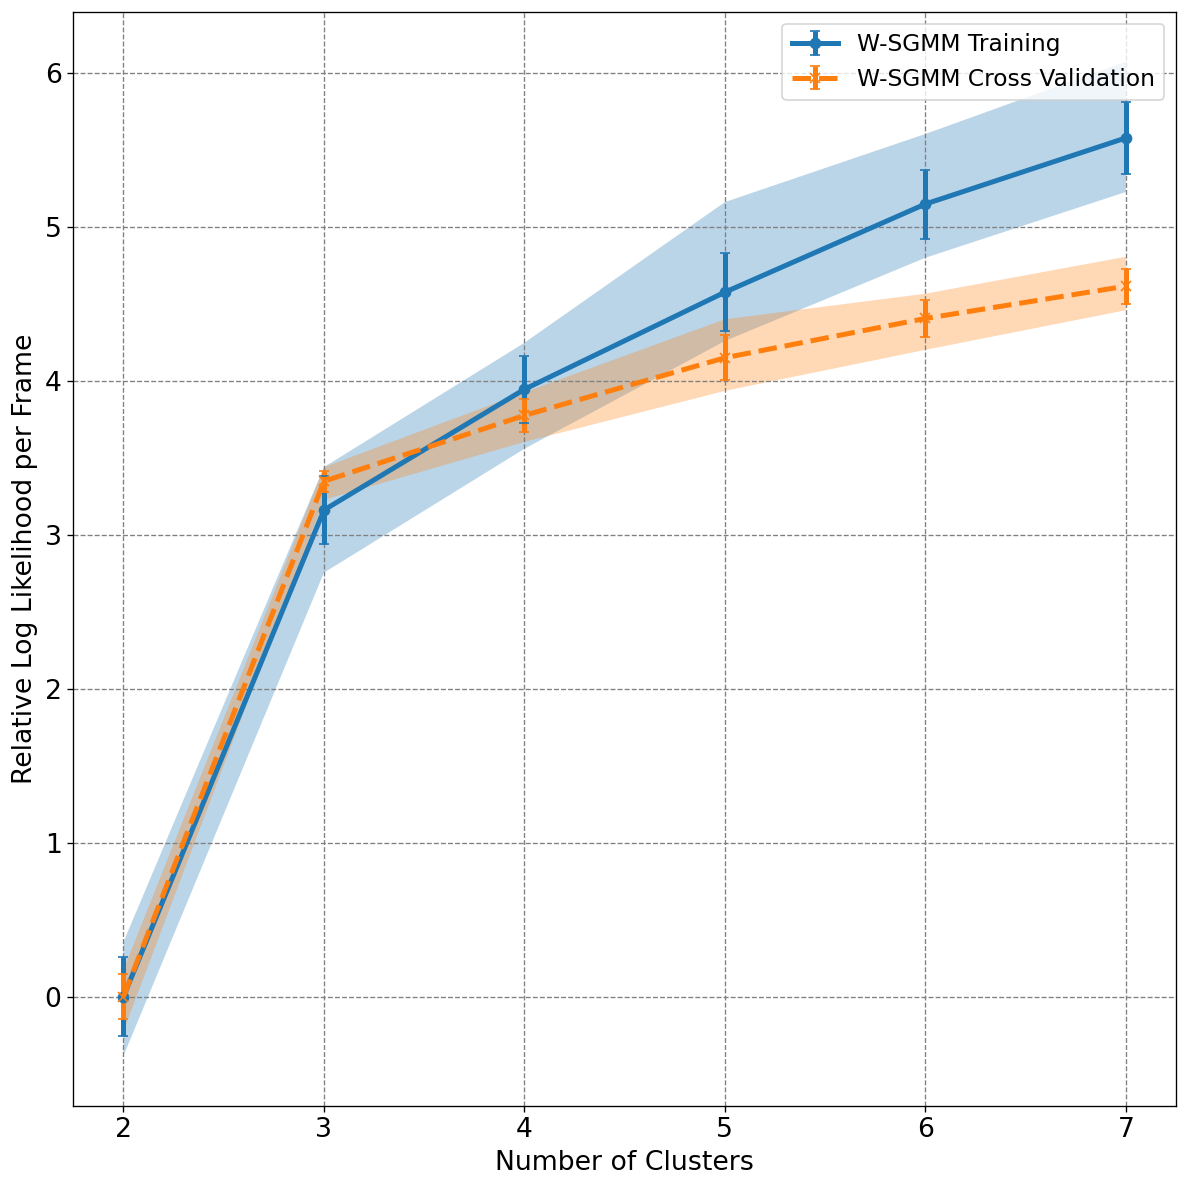

In [30]:
# create figure
plt.figure(figsize=(10,10), dpi= 120, facecolor='w', edgecolor='k')
# weighted SGMM
weighted_train_mean = np.mean(weighted_train_log_lik,axis=1)
weighted_train_mean_min = np.amin(weighted_train_mean)
weighted_train_mean -= weighted_train_mean_min
weighted_train_log_lik -= weighted_train_mean_min
weighted_train_std = np.std(weighted_train_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_train_mean,weighted_train_std,fmt='-o',lw=3,capsize=3,label="W-SGMM Training")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_train_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
weighted_predict_mean = np.mean(weighted_predict_log_lik,axis=1)
weighted_predict_mean_min = np.amin(weighted_predict_mean)
weighted_predict_mean -= weighted_predict_mean_min
weighted_predict_log_lik -= weighted_predict_mean_min
weighted_predict_std = np.std(weighted_predict_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_predict_mean,weighted_predict_std,fmt='--x',lw=3,capsize=3,label="W-SGMM Cross Validation")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_predict_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Relative Log Likelihood per Frame",fontsize=16)
plt.xlabel("Number of Clusters",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig("beaded_helix_log_likelihood_cv.png",dpi=300,transparent=True)

## Run WSGMM for nClusters=3

In [ ]:
delta = 1
beaded_helix_3_clusters_wsgmm = gmm_shapes.ShapeGMM(3,verbose=True)
aligned_traj =  beaded_helix_3_clusters_wsgmm.fit_weighted(trajData[1::delta]) # start at 1

In [7]:
# reorder object
reorder_gmm_cluster_obj(beaded_helix_3_clusters_wsgmm)

Number of clusters: 3
Populations prior to reorder: [0.4635 0.1481 0.3884]
Populations after reorder: [0.4635 0.3884 0.1481]


In [60]:
#predict if you didn't train on entire data set
entire_traj_clusters, entire_traj_traj, entire_traj_log_lik = beaded_helix_3_clusters_wsgmm.predict_weighted(trajData[1:])

## Make 2D FE Plot with clusterings

In [8]:
from shapeGMM._traj_tools import weight_kabsch_dist_align

In [9]:
mahaClusterCenters = np.empty((trajData[1::delta].shape[0],2),dtype=np.float32)
for frame in range(trajData[1::delta].shape[0]):
    mahaClusterCenters[frame,0] = np.sqrt(weight_kabsch_dist_align(trajData[1::delta][frame],beaded_helix_3_clusters_wsgmm.centers[0],beaded_helix_3_clusters_wsgmm.precisions[0]))
    mahaClusterCenters[frame,1] = np.sqrt(weight_kabsch_dist_align(trajData[1::delta][frame],beaded_helix_3_clusters_wsgmm.centers[1],beaded_helix_3_clusters_wsgmm.precisions[1]))

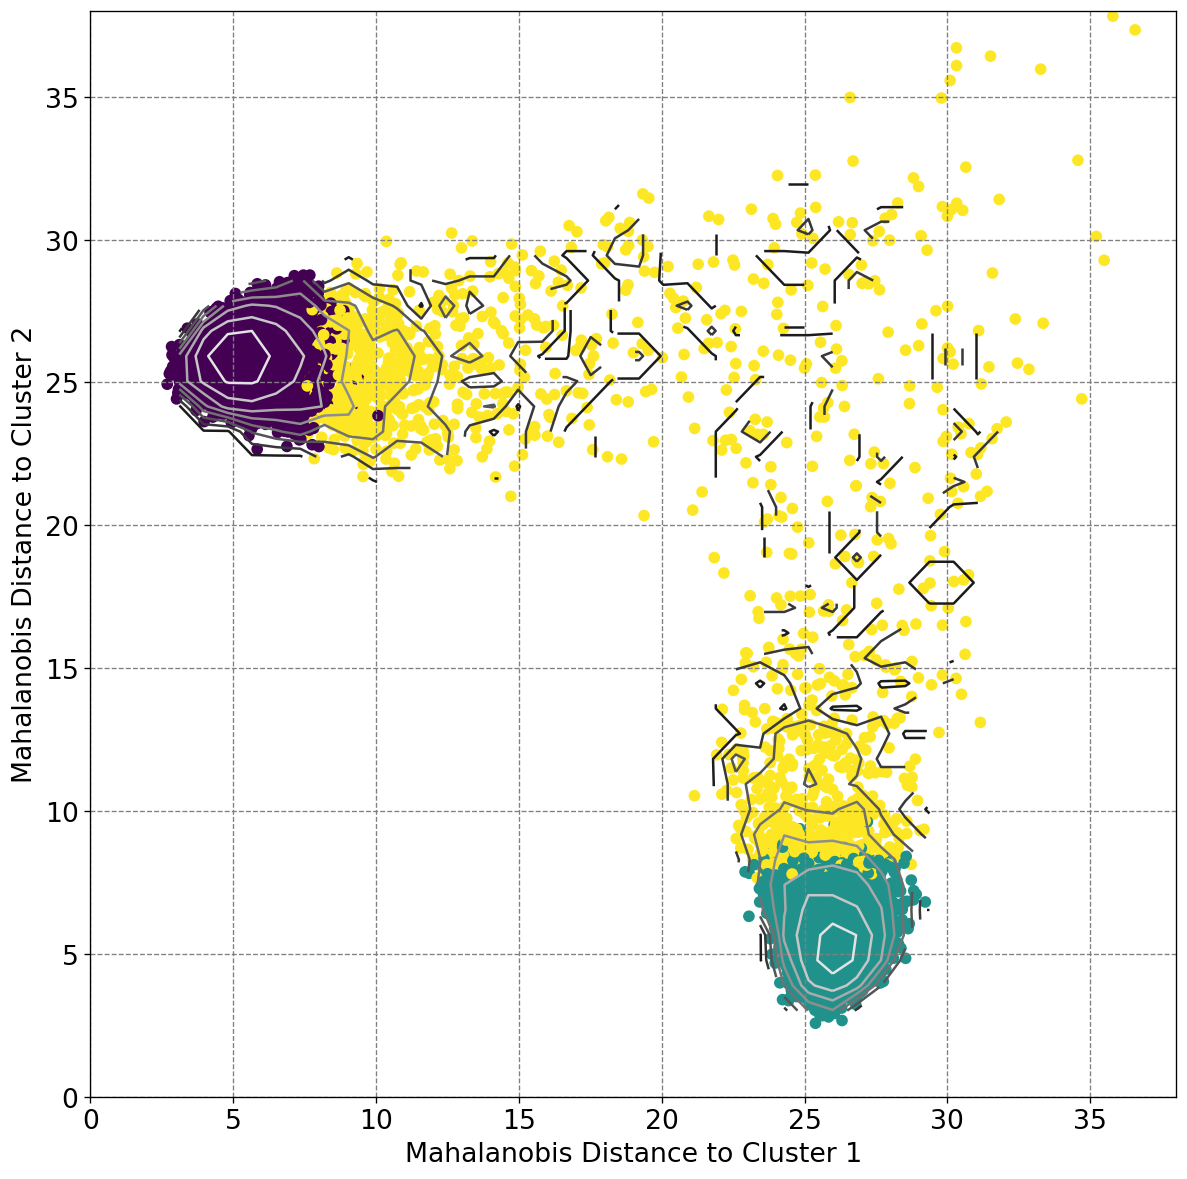

In [11]:
plt.figure(figsize=(10,10), dpi= 120, facecolor='w', edgecolor='k')
x = mahaClusterCenters[:,0]
y = mahaClusterCenters[:,1]
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
plt.contour(xx,yy,H,cmap='binary')
plt.ylabel("Mahalanobis Distance to Cluster 2",fontsize=16)
plt.xlabel("Mahalanobis Distance to Cluster 1",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.scatter(mahaClusterCenters[:,0],mahaClusterCenters[:,1],c=beaded_helix_3_clusters_wsgmm.clusters)#,alpha=0.2)
plt.tight_layout()
plt.xlim(0,38)
plt.ylim(0,38)
plt.gca().set_aspect('equal')
#plt.savefig("beaded_helix_2D_FE_w_clusters.eps",dpi=300)